# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


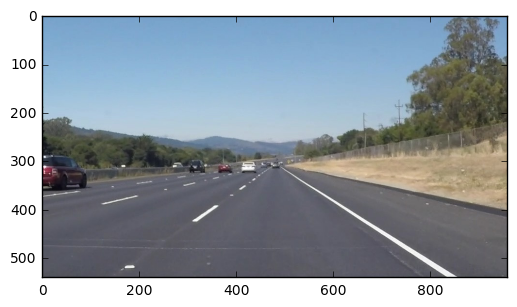

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

gray image shape: (540, 960)


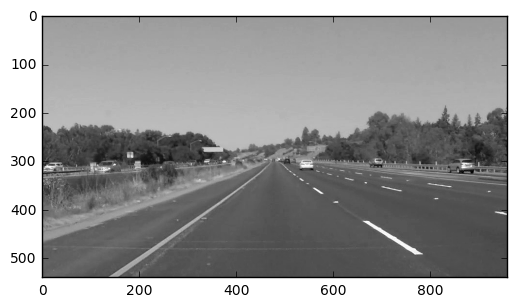

In [3]:
# test image for all unit tests
test_image = (mpimg.imread('test_images/solidYellowLeft.jpg'))

def grayscale(img):
    """Applies the Grayscale transform 
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    #gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

############## UNIT TEST ##############
gray = grayscale(test_image)
#this should be a single channel image shaped like(image.shape[0], image.shape[1])
print("gray image shape: {}".format(gray.shape))
plt.imshow(gray, cmap='gray');
############################

gaussian_blur_test shape: (540, 960)


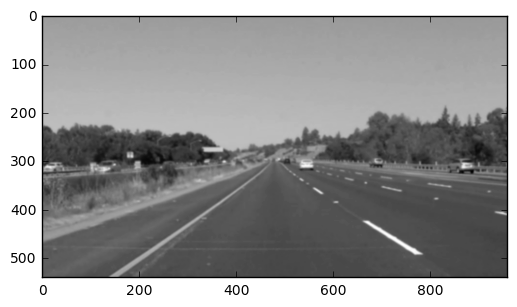

In [4]:
def gaussian_blur(img, kernel_size=7):
    """Applies a Gaussian Noise kernel"""
    
    gray_image = grayscale(img)
    
    return cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)

############## UNIT TEST ##############
gaussian_blur_test = gaussian_blur(test_image)
 # this should still be a single channel image
print("gaussian_blur_test shape: {}".format(gaussian_blur_test.shape))
plt.imshow(gaussian_blur_test, cmap='gray');
######################

canny image shape


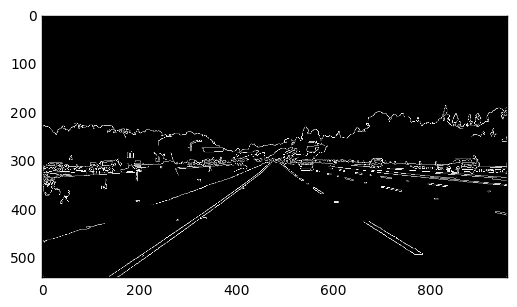

In [5]:
def canny(img, low_threshold=70, high_threshold=210):
    """Applies the Canny transform"""

    return cv2.Canny(img, low_threshold, high_threshold)

############## UNIT TEST ##############
test_edges = canny(test_image)
print("canny image shape".format(test_edges.shape)) 
# this should still be a singel channel image.
plt.imshow(test_edges, cmap='gray')
######################

masked_edges shape (540, 960)


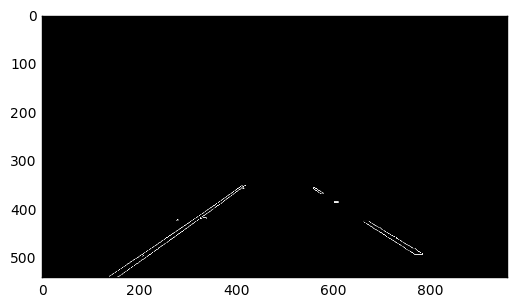

In [6]:
def region_of_interest(edges):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    #defining a blank mask to start with
    """    
    #Create a masked edges image
    mask = np.zeros_like(edges) 
    ignore_mask_color = 255
    
    # Define a four sided polygon to mask.
    # numpy.array returns a tuple of number of rows, columns and channels.
    imshape = edges.shape
    vertices = np.array([[(50,imshape[0]),(380, 350), (580, 350), (900,imshape[0])]], dtype=np.int32)
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_edges = cv2.bitwise_and(edges, mask)
    return masked_edges


############## UNIT TEST ##############
test_edges = canny(test_image)
masked_edges = region_of_interest(test_edges)
print("masked_edges shape {}".format(masked_edges.shape)) 
# again a single channel image
plt.imshow(masked_edges, cmap='gray')
######################

0 [ 417.09088135] [-417.09088135]
0 [ 138.79899597] [-138.79899597]
0 [ 546.53771973] [-546.53771973]
0 [ 862.95684814] [-862.95684814]
masked_edges shape (540, 960, 3)


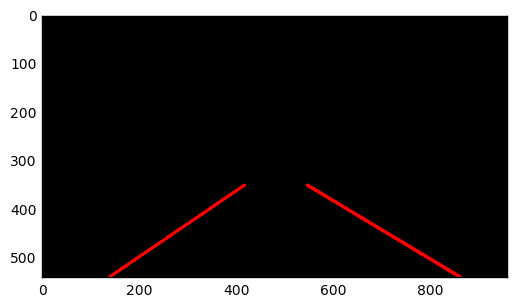

In [7]:
"""
After you separate them, calculate the average slope of the segments per lane. 
With that slope, decide on two Y coordinates where you want the lane lines to start and end 
(for example, use the bottom of the image as a Y_bottom point, and Y_top = 300 or something 
like that – where the horizon is). Now that you have your Y coordinates, calculate the 
X coordinates per lane line.
"""
prev_left_top_x = prev_right_top_x = prev_right_bottom_x = prev_left_bottom_x = 0

def cruise_control (previous, current, factor):
    #print (previous, current, previous - current)
    if (previous - current) <= factor:
        return current
    else:
        return previous


def get_point_horizontal( vx, vy, x1, y1, y_ref ):
    """
    Calculates 'x' matching: 2 points on a line, its slope, and a given 'y' coordinate.
    """
    m = vy / vx
    b = y1 - ( m * x1 )
    x = ( y_ref - b ) / m
    return x


def draw_lines(line_img, lines, color=[255, 0, 0], thickness=6):
    """
    average/extrapolate the line segments you detect to map out the full extent of the lane
    """
    right_segment_points = []
    left_segment_points = [] 
    top_y = 350
    bot_y = line_img.shape[0]
    
    for line in lines:     
        for x1,y1,x2,y2 in line:
            
            # 1, find slope
            slope = float((y2-y1)/(x2-x1))
            # print (slope)
            max_slope_thresh = .85
            min_slope_thresh = .35
            
            # 2, use sloap to split lanes into left and right.
            # theory that a negative slope will be right lane
            if max_slope_thresh >= slope >= min_slope_thresh:
                
                # print (slope)
                # append all points to points array 
                right_segment_points.append([x1,y1])
                right_segment_points.append([x2,y2])
                
                # declare numpy array
                # fit a line with those points
                right_segment = np.array(right_segment_points)
                [r_vx, r_vy, r_cx, r_cy] = cv2.fitLine(right_segment, cv2.DIST_L12, 0, 0.01, 0.01)
                
                # define 2 x points for right lane line
                right_top_x = get_point_horizontal( r_vx, r_vy, r_cx, r_cy, top_y )
                right_bottom_x = get_point_horizontal( r_vx, r_vy, r_cx, r_cy, bot_y )
                
            elif -max_slope_thresh <= slope <= -min_slope_thresh:
                
                # print (slope)
                # append all points to points array 
                left_segment_points.append([x1,y1])
                left_segment_points.append([x2,y2])
                
                # declare numpy array
                # fit a line with those points
                # TODO add something to test if segment points not blank
                left_segment = np.array(left_segment_points)
                [r_vx, r_vy, r_cx, r_cy] = cv2.fitLine(left_segment, cv2.DIST_L12, 0, 0.01, 0.01)
                
                # define 2 x points for left lane line
                left_top_x = get_point_horizontal( r_vx, r_vy, r_cx, r_cy, top_y )
                left_bottom_x = get_point_horizontal( r_vx, r_vy, r_cx, r_cy, bot_y )
    
    global prev_left_top_x
    left_top_x_corrected = cruise_control(prev_left_top_x, left_top_x, 2)
    prev_left_top_x = left_top_x
    
    global prev_left_bottom_x
    left_bottom_x_corrected = cruise_control(prev_left_bottom_x, left_bottom_x, 2)
    prev_left_bottom_x = left_bottom_x
    
    global prev_right_top_x
    right_top_x_corrected = cruise_control(prev_right_top_x, right_top_x, 5)
    prev_right_top_x = right_top_x
    
    global prev_right_bottom_x
    right_bottom_x_corrected = cruise_control(prev_right_bottom_x, right_bottom_x, 5)
    prev_right_bottom_x = right_bottom_x
    
    cv2.line(line_img, (left_bottom_x_corrected, bot_y), (left_top_x_corrected, top_y), color, thickness)
    cv2.line(line_img, (right_bottom_x_corrected, bot_y), (right_top_x_corrected, top_y), color, thickness)


def hough_lines(img, rho=4, theta=np.pi/180, threshold=50, min_line_len=10, max_line_gap=40):
    """
    `img` should be the output of a Canny transform.  
    Run Hough on edge detected image
    Output "lines" is an array containing endpoints of detected line segments
    """

    edges = canny(img)
    masked_edges = region_of_interest(edges)
    
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    
    return line_img

############## UNIT TEST ##############
test_hough = hough_lines(test_image)
print("masked_edges shape {}".format(test_hough.shape))

plt.imshow(test_hough)
######################

[ 417.09088135] [ 417.09088135] [ 0.]
[ 138.79899597] [ 138.79899597] [ 0.]
[ 546.53771973] [ 546.53771973] [ 0.]
[ 862.95684814] [ 862.95684814] [ 0.]
masked_edges shape (540, 960, 3)


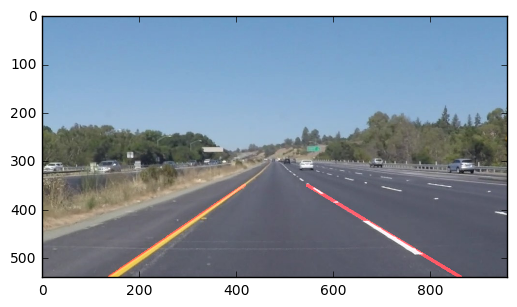

In [8]:
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=1, β=1, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """   
    
    return cv2.addWeighted(initial_img, α, img, β, λ)


############## UNIT TEST ##############
test_hough = hough_lines(test_image)
test_weighted = weighted_img(test_hough, test_image)
print("masked_edges shape {}".format(test_weighted.shape))
plt.imshow(test_weighted)
######################

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [9]:
import os
#os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

In [10]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#cv2.imwrite("test_images/" + "with_lines_" + image, result)

import os
import shutil

test_images = os.listdir("test_images/")

try:
    processed_images = os.listdir("test_images/processed_images/")
except FileNotFoundError:
    print("File not found")
    
#Clean Up from last run
if processed_images:
    shutil.rmtree("test_images/processed_images/", ignore_errors=True)
    #Create New Folder for Processing
    create_success = os.mkdir("test_images/processed_images/")

for img in test_images:
    #Wasn't sure where to add the code to test the images, so I added it here
    if '.jpg' in img:
        image = mpimg.imread("test_images/%(filename)s" % {"filename": img})
        
        hough = hough_lines(image)    
        processed_image = weighted_img(hough, image)
        color_fix = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        
        cv2.imwrite("test_images/processed_images/%(filename)s_processed.jpg" % 
                                    {"filename": img.replace(".jpg","")}, color_fix)


[ 417.09088135] [ 427.91952515] [-10.8286438]
[ 138.79899597] [ 171.22007751] [-32.42108154]
[ 546.53771973] [ 556.24041748] [-9.70269775]
[ 862.95684814] [ 891.93261719] [-28.97576904]
[ 427.91952515] [ 420.84594727] [ 7.07357788]
[ 171.22007751] [ 139.94023132] [ 31.27984619]
[ 556.24041748] [ 548.70404053] [ 7.53637695]
[ 891.93261719] [ 835.06347656] [ 56.86914062]
[ 420.84594727] [ 426.21374512] [-5.36779785]
[ 139.94023132] [ 170.47451782] [-30.5342865]
[ 548.70404053] [ 540.11114502] [ 8.59289551]
[ 835.06347656] [ 849.41003418] [-14.34655762]
[ 426.21374512] [ 424.89672852] [ 1.3170166]
[ 170.47451782] [ 177.40942383] [-6.93490601]
[ 540.11114502] [ 546.41412354] [-6.30297852]
[ 849.41003418] [ 875.94158936] [-26.53155518]
[ 424.89672852] [ 417.09088135] [ 7.80584717]
[ 177.40942383] [ 138.79899597] [ 38.61042786]
[ 546.41412354] [ 546.53771973] [-0.12359619]
[ 875.94158936] [ 862.95684814] [ 12.98474121]
[ 417.09088135] [ 431.64755249] [-14.55667114]
[ 138.79899597] [ 191.2823

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [11]:
import imageio
imageio.plugins.ffmpeg.download()

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
    
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)   
    
    #hough = hough_lines(image, prev_left_top_x, prev_left_bottom_x, prev_right_top_x, prev_right_bottom_x)    
    
        hough = hough_lines(image)
        result = weighted_img(hough, image)

        return result

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")

# applies argument to each frame
"""
white_clip = clip1.fl_image(
    lambda image: process_image(image, prev_left_top_x, prev_left_bottom_x,
                               prev_right_top_x, prev_right_bottom_x))
"""
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[ 431.64755249] [ 412.22424316] [ 19.42330933]
[ 191.28234863] [ 168.45042419] [ 22.83192444]
[ 545.7300415] [ 554.2154541] [-8.4854126]
[ 884.81640625] [ 850.73236084] [ 34.08404541]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

[ 412.22424316] [ 412.22424316] [ 0.]
[ 168.45042419] [ 168.45042419] [ 0.]
[ 554.2154541] [ 554.2154541] [ 0.]
[ 850.73236084] [ 850.73236084] [ 0.]
[ 412.22424316] [ 414.44314575] [-2.21890259]
[ 168.45042419] [ 160.14581299] [ 8.30461121]
[ 554.2154541] [ 554.77270508] [-0.55725098]
[ 850.73236084] [ 868.0067749] [-17.27441406]
[ 414.44314575] [ 418.39532471] [-3.95217896]
[ 160.14581299] [ 151.92831421] [ 8.21749878]
[ 554.77270508] [ 553.9631958] [ 0.80950928]
[ 868.0067749] [ 869.06439209] [-1.05761719]


  1%|▏         | 3/222 [00:00<00:07, 28.97it/s]

[ 418.39532471] [ 415.5541687] [ 2.84115601]
[ 151.92831421] [ 147.97172546] [ 3.95658875]
[ 553.9631958] [ 554.6975708] [-0.734375]
[ 869.06439209] [ 850.77148438] [ 18.29290771]
[ 415.5541687] [ 416.09292603] [-0.53875732]
[ 147.97172546] [ 153.30813599] [-5.33641052]
[ 554.6975708] [ 551.01141357] [ 3.68615723]
[ 850.77148438] [ 851.48675537] [-0.715271]
[ 416.09292603] [ 416.45394897] [-0.36102295]
[ 153.30813599] [ 139.52859497] [ 13.77954102]
[ 551.01141357] [ 551.56433105] [-0.55291748]
[ 851.48675537] [ 854.80871582] [-3.32196045]
[ 416.45394897] [ 415.13043213] [ 1.32351685]
[ 139.52859497] [ 158.35211182] [-18.82351685]
[ 551.56433105] [ 555.66766357] [-4.10333252]
[ 854.80871582] [ 872.50915527] [-17.70043945]


  3%|▎         | 7/222 [00:00<00:07, 30.42it/s]

[ 415.13043213] [ 417.30136108] [-2.17092896]
[ 158.35211182] [ 155.27307129] [ 3.07904053]
[ 555.66766357] [ 556.04626465] [-0.37860107]
[ 872.50915527] [ 872.15258789] [ 0.35656738]
[ 417.30136108] [ 418.05340576] [-0.75204468]
[ 155.27307129] [ 155.07714844] [ 0.19592285]
[ 556.04626465] [ 551.05029297] [ 4.99597168]
[ 872.15258789] [ 872.19158936] [-0.03900146]
[ 418.05340576] [ 417.94265747] [ 0.11074829]
[ 155.07714844] [ 156.62535095] [-1.54820251]
[ 551.05029297] [ 549.06591797] [ 1.984375]
[ 872.19158936] [ 867.3480835] [ 4.84350586]
[ 417.94265747] [ 421.28756714] [-3.34490967]
[ 156.62535095] [ 147.66603088] [ 8.95932007]
[ 549.06591797] [ 545.1461792] [ 3.91973877]
[ 867.3480835] [ 860.3605957] [ 6.98748779]


  5%|▍         | 11/222 [00:00<00:06, 31.27it/s]

[ 421.28756714] [ 422.61230469] [-1.32473755]
[ 147.66603088] [ 147.18800354] [ 0.47802734]
[ 545.1461792] [ 546.10375977] [-0.95758057]
[ 860.3605957] [ 834.60522461] [ 25.75537109]
[ 422.61230469] [ 417.69088745] [ 4.92141724]
[ 147.18800354] [ 161.7852478] [-14.59724426]
[ 546.10375977] [ 550.54370117] [-4.43994141]
[ 834.60522461] [ 832.44439697] [ 2.16082764]
[ 417.69088745] [ 419.07025146] [-1.37936401]
[ 161.7852478] [ 146.22598267] [ 15.55926514]
[ 550.54370117] [ 546.26696777] [ 4.2767334]
[ 832.44439697] [ 836.39691162] [-3.95251465]
[ 419.07025146] [ 415.58560181] [ 3.48464966]
[ 146.22598267] [ 139.22654724] [ 6.99943542]
[ 546.26696777] [ 551.99658203] [-5.72961426]
[ 836.39691162] [ 854.89123535] [-18.49432373]


  7%|▋         | 15/222 [00:00<00:06, 31.94it/s]

[ 415.58560181] [ 409.99996948] [ 5.58563232]
[ 139.22654724] [ 151.30059814] [-12.0740509]
[ 551.99658203] [ 551.36169434] [ 0.6348877]
[ 854.89123535] [ 857.59454346] [-2.70330811]
[ 409.99996948] [ 409.75112915] [ 0.24884033]
[ 151.30059814] [ 143.15765381] [ 8.14294434]
[ 551.36169434] [ 552.11694336] [-0.75524902]
[ 857.59454346] [ 844.35455322] [ 13.23999023]
[ 409.75112915] [ 413.94598389] [-4.19485474]
[ 143.15765381] [ 120.84381866] [ 22.31383514]
[ 552.11694336] [ 552.58660889] [-0.46966553]
[ 844.35455322] [ 860.44854736] [-16.09399414]
[ 413.94598389] [ 417.5473938] [-3.60140991]
[ 120.84381866] [ 147.46711731] [-26.62329865]
[ 552.58660889] [ 548.60583496] [ 3.98077393]
[ 860.44854736] [ 843.65307617] [ 16.79547119]


  9%|▊         | 19/222 [00:00<00:06, 32.34it/s]

[ 417.5473938] [ 419.82601929] [-2.27862549]
[ 147.46711731] [ 131.59590149] [ 15.87121582]
[ 548.60583496] [ 545.16015625] [ 3.44567871]
[ 843.65307617] [ 856.4508667] [-12.79779053]
[ 419.82601929] [ 420.81738281] [-0.99136353]
[ 131.59590149] [ 145.43041992] [-13.83451843]
[ 545.16015625] [ 548.06256104] [-2.90240479]
[ 856.4508667] [ 835.62969971] [ 20.82116699]
[ 420.81738281] [ 420.36517334] [ 0.45220947]
[ 145.43041992] [ 162.43751526] [-17.00709534]
[ 548.06256104] [ 545.34729004] [ 2.715271]
[ 835.62969971] [ 835.79864502] [-0.16894531]
[ 420.36517334] [ 421.2414856] [-0.87631226]
[ 162.43751526] [ 146.37461853] [ 16.06289673]
[ 545.34729004] [ 542.17724609] [ 3.17004395]
[ 835.79864502] [ 853.56152344] [-17.76287842]


 10%|█         | 23/222 [00:00<00:06, 32.91it/s]

[ 421.2414856] [ 419.55984497] [ 1.68164062]
[ 146.37461853] [ 157.11837769] [-10.74375916]
[ 542.17724609] [ 543.88549805] [-1.70825195]
[ 853.56152344] [ 857.24505615] [-3.68353271]
[ 419.55984497] [ 417.32858276] [ 2.23126221]
[ 157.11837769] [ 153.6084137] [ 3.50996399]
[ 543.88549805] [ 551.57318115] [-7.68768311]
[ 857.24505615] [ 836.84637451] [ 20.39868164]
[ 417.32858276] [ 420.27047729] [-2.94189453]
[ 153.6084137] [ 140.91880798] [ 12.68960571]
[ 551.57318115] [ 544.82073975] [ 6.75244141]
[ 836.84637451] [ 847.68792725] [-10.84155273]
[ 420.27047729] [ 420.96911621] [-0.69863892]
[ 140.91880798] [ 141.67790222] [-0.75909424]
[ 544.82073975] [ 551.78741455] [-6.9666748]
[ 847.68792725] [ 835.97869873] [ 11.70922852]


 12%|█▏        | 27/222 [00:00<00:05, 33.07it/s]

[ 420.96911621] [ 422.90982056] [-1.94070435]
[ 141.67790222] [ 142.76799011] [-1.09008789]
[ 551.78741455] [ 547.22662354] [ 4.56079102]
[ 835.97869873] [ 837.37438965] [-1.39569092]
[ 422.90982056] [ 421.49401855] [ 1.415802]
[ 142.76799011] [ 148.50827026] [-5.74028015]
[ 547.22662354] [ 540.35705566] [ 6.86956787]
[ 837.37438965] [ 857.71697998] [-20.34259033]
[ 421.49401855] [ 420.88500977] [ 0.60900879]
[ 148.50827026] [ 144.15696716] [ 4.3513031]
[ 540.35705566] [ 545.90289307] [-5.5458374]
[ 857.71697998] [ 856.97149658] [ 0.7454834]
[ 420.88500977] [ 419.05206299] [ 1.83294678]
[ 144.15696716] [ 138.0471344] [ 6.10983276]
[ 545.90289307] [ 549.29510498] [-3.39221191]
[ 856.97149658] [ 840.89575195] [ 16.07574463]


 14%|█▍        | 31/222 [00:00<00:05, 33.64it/s]

[ 419.05206299] [ 418.92681885] [ 0.12524414]
[ 138.0471344] [ 151.65974426] [-13.61260986]
[ 549.29510498] [ 548.96069336] [ 0.33441162]
[ 840.89575195] [ 860.10961914] [-19.21386719]
[ 418.92681885] [ 418.99380493] [-0.06698608]
[ 151.65974426] [ 155.77114868] [-4.11140442]
[ 548.96069336] [ 550.78796387] [-1.82727051]
[ 860.10961914] [ 841.92419434] [ 18.1854248]
[ 418.99380493] [ 417.7293396] [ 1.26446533]
[ 155.77114868] [ 149.47201538] [ 6.2991333]
[ 550.78796387] [ 554.50793457] [-3.7199707]
[ 841.92419434] [ 840.18157959] [ 1.74261475]
[ 417.7293396] [ 418.61541748] [-0.88607788]
[ 149.47201538] [ 148.93363953] [ 0.53837585]
[ 554.50793457] [ 551.04034424] [ 3.46759033]
[ 840.18157959] [ 853.87298584] [-13.69140625]


 16%|█▌        | 35/222 [00:01<00:05, 33.97it/s]

[ 418.61541748] [ 419.47854614] [-0.86312866]
[ 148.93363953] [ 144.58055115] [ 4.35308838]
[ 551.04034424] [ 549.92272949] [ 1.11761475]
[ 853.87298584] [ 845.52758789] [ 8.34539795]
[ 419.47854614] [ 419.63711548] [-0.15856934]
[ 144.58055115] [ 160.22550964] [-15.6449585]
[ 549.92272949] [ 551.64355469] [-1.7208252]
[ 845.52758789] [ 837.5536499] [ 7.97393799]
[ 419.63711548] [ 419.50750732] [ 0.12960815]
[ 160.22550964] [ 161.67443848] [-1.44892883]
[ 551.64355469] [ 550.78845215] [ 0.85510254]
[ 837.5536499] [ 835.30102539] [ 2.25262451]
[ 419.50750732] [ 418.44241333] [ 1.06509399]
[ 161.67443848] [ 161.24739075] [ 0.42704773]
[ 550.78845215] [ 544.45269775] [ 6.33575439]
[ 835.30102539] [ 855.62127686] [-20.32025146]


 18%|█▊        | 39/222 [00:01<00:05, 33.86it/s]

[ 418.44241333] [ 419.23495483] [-0.7925415]
[ 161.24739075] [ 143.1474762] [ 18.09991455]
[ 544.45269775] [ 544.88916016] [-0.4364624]
[ 855.62127686] [ 847.65240479] [ 7.96887207]
[ 419.23495483] [ 417.68807983] [ 1.546875]
[ 143.1474762] [ 141.82409668] [ 1.32337952]
[ 544.88916016] [ 551.34197998] [-6.45281982]
[ 847.65240479] [ 835.48431396] [ 12.16809082]
[ 417.68807983] [ 414.54769897] [ 3.14038086]
[ 141.82409668] [ 142.71492004] [-0.89082336]
[ 551.34197998] [ 551.08850098] [ 0.253479]
[ 835.48431396] [ 835.44152832] [ 0.04278564]
[ 414.54769897] [ 414.5899353] [-0.04223633]
[ 142.71492004] [ 142.61619568] [ 0.09872437]
[ 551.08850098] [ 539.72381592] [ 11.36468506]
[ 835.44152832] [ 851.92999268] [-16.48846436]


 19%|█▉        | 43/222 [00:01<00:05, 33.86it/s]

[ 414.5899353] [ 412.47024536] [ 2.11968994]
[ 142.61619568] [ 143.79908752] [-1.18289185]
[ 539.72381592] [ 548.36688232] [-8.64306641]
[ 851.92999268] [ 846.309021] [ 5.62097168]
[ 412.47024536] [ 414.53781128] [-2.06756592]
[ 143.79908752] [ 142.70779419] [ 1.09129333]
[ 548.36688232] [ 549.58850098] [-1.22161865]
[ 846.309021] [ 855.79431152] [-9.48529053]
[ 414.53781128] [ 414.83023071] [-0.29241943]
[ 142.70779419] [ 157.3553772] [-14.64758301]
[ 549.58850098] [ 550.7979126] [-1.20941162]
[ 855.79431152] [ 835.59442139] [ 20.19989014]
[ 414.83023071] [ 412.3739624] [ 2.45626831]
[ 157.3553772] [ 156.43115234] [ 0.92422485]
[ 550.7979126] [ 559.06036377] [-8.26245117]
[ 835.59442139] [ 837.71417236] [-2.11975098]


 21%|██        | 47/222 [00:01<00:05, 32.11it/s]

[ 412.3739624] [ 411.33004761] [ 1.04391479]
[ 156.43115234] [ 141.33459473] [ 15.09655762]
[ 559.06036377] [ 547.88415527] [ 11.1762085]
[ 837.71417236] [ 853.33032227] [-15.6161499]
[ 411.33004761] [ 412.8822937] [-1.55224609]
[ 141.33459473] [ 141.60160828] [-0.26701355]
[ 547.88415527] [ 550.58374023] [-2.69958496]
[ 853.33032227] [ 838.08215332] [ 15.24816895]
[ 412.8822937] [ 412.52578735] [ 0.35650635]
[ 141.60160828] [ 142.46182251] [-0.86021423]
[ 550.58374023] [ 554.60113525] [-4.01739502]
[ 838.08215332] [ 854.26831055] [-16.18615723]
[ 412.52578735] [ 410.96398926] [ 1.5617981]
[ 142.46182251] [ 151.35736084] [-8.89553833]
[ 554.60113525] [ 549.21966553] [ 5.38146973]
[ 854.26831055] [ 837.1864624] [ 17.08184814]


 23%|██▎       | 51/222 [00:01<00:05, 31.88it/s]

[ 410.96398926] [ 410.98834229] [-0.02435303]
[ 151.35736084] [ 154.13053894] [-2.7731781]
[ 549.21966553] [ 547.17138672] [ 2.04827881]
[ 837.1864624] [ 854.82250977] [-17.63604736]
[ 410.98834229] [ 410.75430298] [ 0.23403931]
[ 154.13053894] [ 150.45782471] [ 3.67271423]
[ 547.17138672] [ 550.38787842] [-3.2164917]
[ 854.82250977] [ 854.40386963] [ 0.41864014]
[ 410.75430298] [ 411.27966309] [-0.52536011]
[ 150.45782471] [ 134.62663269] [ 15.83119202]
[ 550.38787842] [ 548.54595947] [ 1.84191895]
[ 854.40386963] [ 855.36883545] [-0.96496582]
[ 411.27966309] [ 412.71588135] [-1.43621826]
[ 134.62663269] [ 132.69010925] [ 1.93652344]
[ 548.54595947] [ 548.31756592] [ 0.22839355]
[ 855.36883545] [ 854.74822998] [ 0.62060547]


 25%|██▍       | 55/222 [00:01<00:05, 30.98it/s]

[ 412.71588135] [ 412.99807739] [-0.28219604]
[ 132.69010925] [ 149.08163452] [-16.39152527]
[ 548.31756592] [ 550.74401855] [-2.42645264]
[ 854.74822998] [ 833.67077637] [ 21.07745361]
[ 412.99807739] [ 414.17169189] [-1.1736145]
[ 149.08163452] [ 135.33866882] [ 13.7429657]
[ 550.74401855] [ 546.30627441] [ 4.43774414]
[ 833.67077637] [ 834.84698486] [-1.1762085]
[ 414.17169189] [ 415.74700928] [-1.57531738]
[ 135.33866882] [ 135.43914795] [-0.10047913]
[ 546.30627441] [ 550.1293335] [-3.82305908]
[ 834.84698486] [ 844.91723633] [-10.07025146]
[ 415.74700928] [ 415.50366211] [ 0.24334717]
[ 135.43914795] [ 128.42330933] [ 7.01583862]
[ 550.1293335] [ 547.46276855] [ 2.66656494]
[ 844.91723633] [ 849.87701416] [-4.95977783]


 27%|██▋       | 59/222 [00:01<00:05, 30.14it/s]

[ 415.50366211] [ 412.00689697] [ 3.49676514]
[ 128.42330933] [ 137.0052948] [-8.58198547]
[ 547.46276855] [ 550.25927734] [-2.79650879]
[ 849.87701416] [ 848.75848389] [ 1.11853027]
[ 412.00689697] [ 412.60379028] [-0.59689331]
[ 137.0052948] [ 146.83665466] [-9.83135986]
[ 550.25927734] [ 545.89556885] [ 4.3637085]
[ 848.75848389] [ 846.06872559] [ 2.6897583]
[ 412.60379028] [ 412.99261475] [-0.38882446]
[ 146.83665466] [ 130.18719482] [ 16.64945984]
[ 545.89556885] [ 550.34869385] [-4.453125]
[ 846.06872559] [ 829.73797607] [ 16.33074951]
[ 412.99261475] [ 413.18225098] [-0.18963623]
[ 130.18719482] [ 147.32180786] [-17.13461304]
[ 550.34869385] [ 547.39752197] [ 2.95117188]
[ 829.73797607] [ 829.2946167] [ 0.44335938]


 28%|██▊       | 63/222 [00:01<00:05, 28.48it/s]

[ 413.18225098] [ 418.37588501] [-5.19363403]
[ 147.32180786] [ 130.70396423] [ 16.61784363]
[ 547.39752197] [ 546.44763184] [ 0.94989014]
[ 829.2946167] [ 845.64886475] [-16.35424805]
[ 418.37588501] [ 415.10632324] [ 3.26956177]
[ 130.70396423] [ 131.23701477] [-0.53305054]
[ 546.44763184] [ 547.2131958] [-0.76556396]
[ 845.64886475] [ 844.95019531] [ 0.69866943]
[ 415.10632324] [ 415.32440186] [-0.21807861]
[ 131.23701477] [ 116.9785614] [ 14.25845337]
[ 547.2131958] [ 548.06335449] [-0.85015869]
[ 844.95019531] [ 845.03405762] [-0.0838623]


 30%|██▉       | 66/222 [00:02<00:06, 25.48it/s]

[ 415.32440186] [ 415.11590576] [ 0.20849609]
[ 116.9785614] [ 124.52655792] [-7.54799652]
[ 548.06335449] [ 545.99908447] [ 2.06427002]
[ 845.03405762] [ 829.17651367] [ 15.85754395]
[ 415.11590576] [ 413.25393677] [ 1.86196899]
[ 124.52655792] [ 124.22707367] [ 0.29948425]
[ 545.99908447] [ 543.18548584] [ 2.81359863]
[ 829.17651367] [ 848.93676758] [-19.76025391]
[ 413.25393677] [ 413.91629028] [-0.66235352]
[ 124.22707367] [ 122.74750519] [ 1.47956848]
[ 543.18548584] [ 547.7199707] [-4.53448486]
[ 848.93676758] [ 846.10852051] [ 2.82824707]
[ 413.91629028] [ 413.77374268] [ 0.14254761]
[ 122.74750519] [ 127.38755798] [-4.6400528]
[ 547.7199707] [ 553.60144043] [-5.88146973]
[ 846.10852051] [ 829.31964111] [ 16.78887939]


 32%|███▏      | 70/222 [00:02<00:05, 27.36it/s]

[ 413.77374268] [ 413.43063354] [ 0.34310913]
[ 127.38755798] [ 135.19128418] [-7.8037262]
[ 553.60144043] [ 549.78082275] [ 3.82061768]
[ 829.31964111] [ 843.29852295] [-13.97888184]
[ 413.43063354] [ 412.81097412] [ 0.61965942]
[ 135.19128418] [ 118.01194763] [ 17.17933655]
[ 549.78082275] [ 544.19671631] [ 5.58410645]
[ 843.29852295] [ 845.18859863] [-1.89007568]
[ 412.81097412] [ 412.16726685] [ 0.64370728]
[ 118.01194763] [ 121.628685] [-3.61673737]
[ 544.19671631] [ 547.42523193] [-3.22851562]
[ 845.18859863] [ 827.54669189] [ 17.64190674]


 33%|███▎      | 73/222 [00:02<00:05, 25.88it/s]

[ 412.16726685] [ 413.94522095] [-1.7779541]
[ 121.628685] [ 121.41807556] [ 0.21060944]
[ 547.42523193] [ 547.09942627] [ 0.32580566]
[ 827.54669189] [ 844.57043457] [-17.02374268]
[ 413.94522095] [ 411.18331909] [ 2.76190186]
[ 121.41807556] [ 129.70948792] [-8.29141235]
[ 547.09942627] [ 547.11151123] [-0.01208496]
[ 844.57043457] [ 843.69146729] [ 0.87896729]
[ 411.18331909] [ 409.1960144] [ 1.98730469]
[ 129.70948792] [ 126.19705963] [ 3.51242828]
[ 547.11151123] [ 543.93115234] [ 3.18035889]
[ 843.69146729] [ 843.08514404] [ 0.60632324]
[ 409.1960144] [ 412.71218872] [-3.51617432]
[ 126.19705963] [ 117.721138] [ 8.47592163]
[ 543.93115234] [ 540.93304443] [ 2.99810791]
[ 843.08514404] [ 841.18157959] [ 1.90356445]


 35%|███▍      | 77/222 [00:02<00:05, 27.68it/s]

[ 412.71218872] [ 410.68017578] [ 2.03201294]
[ 117.721138] [ 113.74147797] [ 3.97966003]
[ 540.93304443] [ 541.01873779] [-0.08569336]
[ 841.18157959] [ 838.95135498] [ 2.23022461]
[ 410.68017578] [ 409.4387207] [ 1.24145508]
[ 113.74147797] [ 120.61067963] [-6.86920166]
[ 541.01873779] [ 545.54180908] [-4.52307129]
[ 838.95135498] [ 817.54327393] [ 21.40808105]
[ 409.4387207] [ 410.35070801] [-0.9119873]
[ 120.61067963] [ 123.20466614] [-2.59398651]
[ 545.54180908] [ 543.10064697] [ 2.44116211]
[ 817.54327393] [ 837.784729] [-20.24145508]


 36%|███▌      | 80/222 [00:02<00:05, 25.64it/s]

[ 410.35070801] [ 410.33850098] [ 0.01220703]
[ 123.20466614] [ 118.63619232] [ 4.56847382]
[ 543.10064697] [ 541.28735352] [ 1.81329346]
[ 837.784729] [ 837.05395508] [ 0.73077393]
[ 410.33850098] [ 411.25134277] [-0.9128418]
[ 118.63619232] [ 113.65386963] [ 4.98232269]
[ 541.28735352] [ 545.83782959] [-4.55047607]
[ 837.05395508] [ 817.31848145] [ 19.73547363]
[ 411.25134277] [ 409.99679565] [ 1.25454712]
[ 113.65386963] [ 117.13266754] [-3.47879791]
[ 545.83782959] [ 544.98773193] [ 0.85009766]
[ 817.31848145] [ 815.73596191] [ 1.58251953]
[ 409.99679565] [ 411.11959839] [-1.12280273]
[ 117.13266754] [ 110.61620331] [ 6.51646423]
[ 544.98773193] [ 546.68011475] [-1.69238281]
[ 815.73596191] [ 834.23260498] [-18.49664307]


 38%|███▊      | 84/222 [00:02<00:05, 26.24it/s]

[ 411.11959839] [ 410.87536621] [ 0.24423218]
[ 110.61620331] [ 129.93228149] [-19.31607819]
[ 546.68011475] [ 545.89874268] [ 0.78137207]
[ 834.23260498] [ 834.49267578] [-0.2600708]
[ 410.87536621] [ 412.44671631] [-1.5713501]
[ 129.93228149] [ 115.18258667] [ 14.74969482]
[ 545.89874268] [ 545.80908203] [ 0.08966064]
[ 834.49267578] [ 834.48718262] [ 0.00549316]
[ 412.44671631] [ 409.6730957] [ 2.77362061]
[ 115.18258667] [ 133.80525208] [-18.62266541]
[ 545.80908203] [ 546.03210449] [-0.22302246]
[ 834.48718262] [ 816.10150146] [ 18.38568115]
[ 409.6730957] [ 411.91815186] [-2.24505615]
[ 133.80525208] [ 125.06036377] [ 8.74488831]
[ 546.03210449] [ 540.84100342] [ 5.19110107]
[ 816.10150146] [ 818.10852051] [-2.00701904]


 40%|███▉      | 88/222 [00:02<00:05, 26.63it/s]

[ 411.91815186] [ 412.57556152] [-0.65740967]
[ 125.06036377] [ 121.88437653] [ 3.17598724]
[ 540.84100342] [ 543.31427002] [-2.4732666]
[ 818.10852051] [ 813.81329346] [ 4.29522705]
[ 412.57556152] [ 414.04656982] [-1.4710083]
[ 121.88437653] [ 106.88588715] [ 14.99848938]
[ 543.31427002] [ 545.03302002] [-1.71875]
[ 813.81329346] [ 831.89208984] [-18.07879639]
[ 414.04656982] [ 412.0562439] [ 1.99032593]
[ 106.88588715] [ 135.6178894] [-28.73200226]
[ 545.03302002] [ 547.16802979] [-2.13500977]
[ 831.89208984] [ 810.84729004] [ 21.0447998]


 41%|████      | 91/222 [00:03<00:04, 26.39it/s]

[ 412.0562439] [ 416.64923096] [-4.59298706]
[ 135.6178894] [ 124.2109375] [ 11.4069519]
[ 547.16802979] [ 538.67956543] [ 8.48846436]
[ 810.84729004] [ 826.13360596] [-15.28631592]
[ 416.64923096] [ 417.14318848] [-0.49395752]
[ 124.2109375] [ 120.8682251] [ 3.3427124]
[ 538.67956543] [ 542.05926514] [-3.37969971]
[ 826.13360596] [ 829.35998535] [-3.22637939]
[ 417.14318848] [ 415.81069946] [ 1.33248901]
[ 120.8682251] [ 125.10655212] [-4.23832703]
[ 542.05926514] [ 545.18597412] [-3.12670898]
[ 829.35998535] [ 822.5524292] [ 6.80755615]
[ 415.81069946] [ 416.72219849] [-0.91149902]
[ 125.10655212] [ 128.28779602] [-3.1812439]
[ 545.18597412] [ 542.1730957] [ 3.01287842]
[ 822.5524292] [ 831.91833496] [-9.36590576]


 43%|████▎     | 95/222 [00:03<00:04, 28.03it/s]

[ 416.72219849] [ 414.75036621] [ 1.97183228]
[ 128.28779602] [ 120.12098694] [ 8.16680908]
[ 542.1730957] [ 549.09710693] [-6.92401123]
[ 831.91833496] [ 829.73535156] [ 2.1829834]
[ 414.75036621] [ 413.89144897] [ 0.85891724]
[ 120.12098694] [ 122.11408997] [-1.99310303]
[ 549.09710693] [ 555.99212646] [-6.89501953]
[ 829.73535156] [ 816.77001953] [ 12.96533203]
[ 413.89144897] [ 414.53353882] [-0.64208984]
[ 122.11408997] [ 125.87654877] [-3.7624588]
[ 555.99212646] [ 547.12036133] [ 8.87176514]
[ 816.77001953] [ 826.65844727] [-9.88842773]


 44%|████▍     | 98/222 [00:03<00:04, 25.82it/s]

[ 414.53353882] [ 413.49343872] [ 1.0401001]
[ 125.87654877] [ 121.62017059] [ 4.25637817]
[ 547.12036133] [ 556.76696777] [-9.64660645]
[ 826.65844727] [ 816.88037109] [ 9.77807617]
[ 413.49343872] [ 414.48202515] [-0.98858643]
[ 121.62017059] [ 113.60514832] [ 8.01502228]
[ 556.76696777] [ 550.32366943] [ 6.44329834]
[ 816.88037109] [ 834.48040771] [-17.60003662]
[ 414.48202515] [ 413.38226318] [ 1.09976196]
[ 113.60514832] [ 115.38224792] [-1.77709961]
[ 550.32366943] [ 554.06048584] [-3.73681641]
[ 834.48040771] [ 832.51519775] [ 1.96520996]
[ 413.38226318] [ 414.87783813] [-1.49557495]
[ 115.38224792] [ 127.79627991] [-12.41403198]
[ 554.06048584] [ 549.52563477] [ 4.53485107]
[ 832.51519775] [ 814.14782715] [ 18.36737061]


 46%|████▌     | 102/222 [00:03<00:04, 27.46it/s]

[ 414.87783813] [ 417.59173584] [-2.71389771]
[ 127.79627991] [ 119.92554474] [ 7.87073517]
[ 549.52563477] [ 552.44250488] [-2.91687012]
[ 814.14782715] [ 816.35595703] [-2.20812988]
[ 417.59173584] [ 420.92617798] [-3.33444214]
[ 119.92554474] [ 130.1905365] [-10.26499176]
[ 552.44250488] [ 552.67401123] [-0.23150635]
[ 816.35595703] [ 829.11541748] [-12.75946045]
[ 420.92617798] [ 418.56039429] [ 2.36578369]
[ 130.1905365] [ 131.8432312] [-1.6526947]
[ 552.67401123] [ 549.52020264] [ 3.15380859]
[ 829.11541748] [ 815.88232422] [ 13.23309326]


 47%|████▋     | 105/222 [00:03<00:04, 27.40it/s]

[ 418.56039429] [ 415.94436646] [ 2.61602783]
[ 131.8432312] [ 150.10942078] [-18.26618958]
[ 549.52020264] [ 551.4019165] [-1.88171387]
[ 815.88232422] [ 818.34368896] [-2.46136475]
[ 415.94436646] [ 415.01556396] [ 0.92880249]
[ 150.10942078] [ 150.89588928] [-0.78646851]
[ 551.4019165] [ 550.10473633] [ 1.29718018]
[ 818.34368896] [ 821.85540771] [-3.51171875]
[ 415.01556396] [ 413.41107178] [ 1.60449219]
[ 150.89588928] [ 152.11375427] [-1.21786499]
[ 550.10473633] [ 549.07910156] [ 1.02563477]
[ 821.85540771] [ 839.35272217] [-17.49731445]
[ 413.41107178] [ 414.60339355] [-1.19232178]
[ 152.11375427] [ 143.93006897] [ 8.1836853]
[ 549.07910156] [ 550.30670166] [-1.2276001]
[ 839.35272217] [ 840.33337402] [-0.98065186]


 49%|████▉     | 109/222 [00:03<00:04, 28.14it/s]

[ 414.60339355] [ 417.11450195] [-2.5111084]
[ 143.93006897] [ 131.21282959] [ 12.71723938]
[ 550.30670166] [ 549.15386963] [ 1.15283203]
[ 840.33337402] [ 838.3057251] [ 2.02764893]
[ 417.11450195] [ 417.64910889] [-0.53460693]
[ 131.21282959] [ 129.55595398] [ 1.65687561]
[ 549.15386963] [ 551.03485107] [-1.88098145]
[ 838.3057251] [ 833.9864502] [ 4.3192749]
[ 417.64910889] [ 413.44006348] [ 4.20904541]
[ 129.55595398] [ 148.91036987] [-19.35441589]
[ 551.03485107] [ 550.66833496] [ 0.36651611]
[ 833.9864502] [ 841.9666748] [-7.98022461]


 50%|█████     | 112/222 [00:03<00:04, 26.12it/s]

[ 413.44006348] [ 414.58267212] [-1.14260864]
[ 148.91036987] [ 138.23629761] [ 10.67407227]
[ 550.66833496] [ 558.66259766] [-7.9942627]
[ 841.9666748] [ 821.6282959] [ 20.33837891]
[ 414.58267212] [ 414.09951782] [ 0.4831543]
[ 138.23629761] [ 129.35562134] [ 8.88067627]
[ 558.66259766] [ 552.62548828] [ 6.03710938]
[ 821.6282959] [ 843.10412598] [-21.47583008]
[ 414.09951782] [ 415.45529175] [-1.35577393]
[ 129.35562134] [ 131.28823853] [-1.93261719]
[ 552.62548828] [ 556.30395508] [-3.6784668]
[ 843.10412598] [ 844.06854248] [-0.9644165]
[ 415.45529175] [ 415.00302124] [ 0.45227051]
[ 131.28823853] [ 116.99278259] [ 14.29545593]
[ 556.30395508] [ 555.18707275] [ 1.11688232]
[ 844.06854248] [ 839.62359619] [ 4.44494629]


 52%|█████▏    | 116/222 [00:03<00:03, 27.73it/s]

[ 415.00302124] [ 415.58520508] [-0.58218384]
[ 116.99278259] [ 130.50804138] [-13.51525879]
[ 555.18707275] [ 551.74023438] [ 3.44683838]
[ 839.62359619] [ 848.60968018] [-8.98608398]
[ 415.58520508] [ 418.55831909] [-2.97311401]
[ 130.50804138] [ 128.02798462] [ 2.48005676]
[ 551.74023438] [ 555.36932373] [-3.62908936]
[ 848.60968018] [ 831.29656982] [ 17.31311035]
[ 418.55831909] [ 415.88348389] [ 2.67483521]
[ 128.02798462] [ 126.14116669] [ 1.88681793]
[ 555.36932373] [ 553.27709961] [ 2.09222412]
[ 831.29656982] [ 847.73370361] [-16.43713379]


 54%|█████▎    | 119/222 [00:04<00:03, 26.04it/s]

[ 415.88348389] [ 419.18634033] [-3.30285645]
[ 126.14116669] [ 128.05052185] [-1.90935516]
[ 553.27709961] [ 559.78271484] [-6.50561523]
[ 847.73370361] [ 831.06561279] [ 16.66809082]
[ 419.18634033] [ 421.24438477] [-2.05804443]
[ 128.05052185] [ 124.80497742] [ 3.24554443]
[ 559.78271484] [ 555.86090088] [ 3.92181396]
[ 831.06561279] [ 849.38659668] [-18.32098389]
[ 421.24438477] [ 416.69265747] [ 4.55172729]
[ 124.80497742] [ 147.65740967] [-22.85243225]
[ 555.86090088] [ 549.74163818] [ 6.1192627]
[ 849.38659668] [ 851.784729] [-2.39813232]
[ 416.69265747] [ 419.43151855] [-2.73886108]
[ 147.65740967] [ 145.95663452] [ 1.70077515]
[ 549.74163818] [ 550.39373779] [-0.65209961]
[ 851.784729] [ 853.07159424] [-1.28686523]


 55%|█████▌    | 123/222 [00:04<00:03, 27.38it/s]

[ 419.43151855] [ 420.94845581] [-1.51693726]
[ 145.95663452] [ 136.42929077] [ 9.52734375]
[ 550.39373779] [ 537.95343018] [ 12.44030762]
[ 853.07159424] [ 853.29040527] [-0.21881104]
[ 420.94845581] [ 422.39810181] [-1.449646]
[ 136.42929077] [ 129.46469116] [ 6.96459961]
[ 537.95343018] [ 545.70123291] [-7.74780273]
[ 853.29040527] [ 855.59411621] [-2.30371094]
[ 422.39810181] [ 420.06604004] [ 2.33206177]
[ 129.46469116] [ 138.35726929] [-8.89257812]
[ 545.70123291] [ 547.12615967] [-1.42492676]
[ 855.59411621] [ 852.91522217] [ 2.67889404]


 57%|█████▋    | 126/222 [00:04<00:03, 27.64it/s]

[ 420.06604004] [ 420.40570068] [-0.33966064]
[ 138.35726929] [ 142.25692749] [-3.8996582]
[ 547.12615967] [ 549.42547607] [-2.29931641]
[ 852.91522217] [ 860.08148193] [-7.16625977]
[ 420.40570068] [ 421.71694946] [-1.31124878]
[ 142.25692749] [ 149.68621826] [-7.42929077]
[ 549.42547607] [ 551.74200439] [-2.31652832]
[ 860.08148193] [ 842.94750977] [ 17.13397217]
[ 421.71694946] [ 420.93710327] [ 0.77984619]
[ 149.68621826] [ 144.0509491] [ 5.63526917]
[ 551.74200439] [ 553.83935547] [-2.09735107]
[ 842.94750977] [ 846.67926025] [-3.73175049]
[ 420.93710327] [ 424.88320923] [-3.94610596]
[ 144.0509491] [ 137.29335022] [ 6.75759888]
[ 553.83935547] [ 554.76300049] [-0.92364502]
[ 846.67926025] [ 857.02172852] [-10.34246826]


 59%|█████▊    | 130/222 [00:04<00:03, 28.45it/s]

[ 424.88320923] [ 423.30633545] [ 1.57687378]
[ 137.29335022] [ 141.25325012] [-3.9598999]
[ 554.76300049] [ 549.71484375] [ 5.04815674]
[ 857.02172852] [ 862.59112549] [-5.56939697]
[ 423.30633545] [ 425.72091675] [-2.4145813]
[ 141.25325012] [ 144.2930603] [-3.03981018]
[ 549.71484375] [ 546.93597412] [ 2.77886963]
[ 862.59112549] [ 861.7208252] [ 0.87030029]
[ 425.72091675] [ 424.57937622] [ 1.14154053]
[ 144.2930603] [ 144.09519958] [ 0.19786072]
[ 546.93597412] [ 547.77355957] [-0.83758545]
[ 861.7208252] [ 858.76739502] [ 2.95343018]


 60%|█████▉    | 133/222 [00:04<00:03, 26.76it/s]

[ 424.57937622] [ 423.21652222] [ 1.362854]
[ 144.09519958] [ 144.12155151] [-0.02635193]
[ 547.77355957] [ 550.32818604] [-2.55462646]
[ 858.76739502] [ 861.4175415] [-2.65014648]
[ 423.21652222] [ 416.95596313] [ 6.26055908]
[ 144.12155151] [ 157.1521759] [-13.03062439]
[ 550.32818604] [ 552.65637207] [-2.32818604]
[ 861.4175415] [ 862.07220459] [-0.65466309]
[ 416.95596313] [ 417.33853149] [-0.38256836]
[ 157.1521759] [ 144.20812988] [ 12.94404602]
[ 552.65637207] [ 561.67736816] [-9.02099609]
[ 862.07220459] [ 844.22424316] [ 17.84796143]
[ 417.33853149] [ 416.94204712] [ 0.39648438]
[ 144.20812988] [ 156.5320282] [-12.32389832]
[ 561.67736816] [ 554.13482666] [ 7.5425415]
[ 844.22424316] [ 847.49133301] [-3.26708984]


 62%|██████▏   | 137/222 [00:04<00:03, 27.67it/s]

[ 416.94204712] [ 419.37069702] [-2.4286499]
[ 156.5320282] [ 132.53089905] [ 24.00112915]
[ 554.13482666] [ 554.31695557] [-0.18212891]
[ 847.49133301] [ 854.37304688] [-6.88171387]
[ 419.37069702] [ 421.63537598] [-2.26467896]
[ 132.53089905] [ 144.93995667] [-12.40905762]
[ 554.31695557] [ 552.54541016] [ 1.77154541]
[ 854.37304688] [ 857.8447876] [-3.47174072]
[ 421.63537598] [ 422.71688843] [-1.08151245]
[ 144.93995667] [ 146.88926697] [-1.9493103]
[ 552.54541016] [ 551.13409424] [ 1.41131592]
[ 857.8447876] [ 859.08660889] [-1.24182129]


 63%|██████▎   | 140/222 [00:04<00:02, 27.74it/s]

[ 422.71688843] [ 420.54211426] [ 2.17477417]
[ 146.88926697] [ 151.28367615] [-4.39440918]
[ 551.13409424] [ 552.84448242] [-1.71038818]
[ 859.08660889] [ 861.85784912] [-2.77124023]
[ 420.54211426] [ 424.66409302] [-4.12197876]
[ 151.28367615] [ 160.27449036] [-8.99081421]
[ 552.84448242] [ 545.67382812] [ 7.1706543]
[ 861.85784912] [ 861.04760742] [ 0.8102417]
[ 424.66409302] [ 422.18545532] [ 2.4786377]
[ 160.27449036] [ 149.94918823] [ 10.32530212]
[ 545.67382812] [ 547.25128174] [-1.57745361]
[ 861.04760742] [ 857.17675781] [ 3.87084961]


 64%|██████▍   | 143/222 [00:04<00:03, 25.84it/s]

[ 422.18545532] [ 424.29110718] [-2.10565186]
[ 149.94918823] [ 150.99703979] [-1.04785156]
[ 547.25128174] [ 552.20031738] [-4.94903564]
[ 857.17675781] [ 860.31738281] [-3.140625]
[ 424.29110718] [ 423.30166626] [ 0.98944092]
[ 150.99703979] [ 159.63140869] [-8.6343689]
[ 552.20031738] [ 552.90875244] [-0.70843506]
[ 860.31738281] [ 843.88128662] [ 16.43609619]
[ 423.30166626] [ 417.86938477] [ 5.43228149]
[ 159.63140869] [ 168.02381897] [-8.39241028]
[ 552.90875244] [ 558.04888916] [-5.14013672]
[ 843.88128662] [ 858.60540771] [-14.72412109]


 66%|██████▌   | 146/222 [00:05<00:02, 26.60it/s]

[ 417.86938477] [ 424.39746094] [-6.52807617]
[ 168.02381897] [ 153.45753479] [ 14.56628418]
[ 558.04888916] [ 559.01708984] [-0.96820068]
[ 858.60540771] [ 864.18713379] [-5.58172607]
[ 424.39746094] [ 421.69308472] [ 2.70437622]
[ 153.45753479] [ 149.76823425] [ 3.68930054]
[ 559.01708984] [ 556.31298828] [ 2.70410156]
[ 864.18713379] [ 869.06506348] [-4.87792969]
[ 421.69308472] [ 421.515625] [ 0.17745972]
[ 149.76823425] [ 150.39964294] [-0.63140869]
[ 556.31298828] [ 551.74383545] [ 4.56915283]
[ 869.06506348] [ 865.17431641] [ 3.89074707]
[ 421.515625] [ 422.44577026] [-0.93014526]
[ 150.39964294] [ 149.5718689] [ 0.82777405]
[ 551.74383545] [ 553.22723389] [-1.48339844]
[ 865.17431641] [ 876.14849854] [-10.97418213]


 68%|██████▊   | 150/222 [00:05<00:02, 25.92it/s]

[ 422.44577026] [ 424.3812561] [-1.93548584]
[ 149.5718689] [ 152.10440063] [-2.53253174]
[ 553.22723389] [ 558.90258789] [-5.675354]
[ 876.14849854] [ 852.33953857] [ 23.80895996]
[ 424.3812561] [ 425.68106079] [-1.29980469]
[ 152.10440063] [ 156.12155151] [-4.01715088]
[ 558.90258789] [ 559.74157715] [-0.83898926]
[ 852.33953857] [ 862.55712891] [-10.21759033]
[ 425.68106079] [ 424.48623657] [ 1.19482422]
[ 156.12155151] [ 170.96047974] [-14.83892822]
[ 559.74157715] [ 556.5602417] [ 3.18133545]
[ 862.55712891] [ 851.70532227] [ 10.85180664]


 69%|██████▉   | 153/222 [00:05<00:02, 27.02it/s]

[ 424.48623657] [ 421.23291016] [ 3.25332642]
[ 170.96047974] [ 156.61885071] [ 14.34162903]
[ 556.5602417] [ 561.30847168] [-4.74822998]
[ 851.70532227] [ 853.7701416] [-2.06481934]
[ 421.23291016] [ 425.11956787] [-3.88665771]
[ 156.61885071] [ 146.42684937] [ 10.19200134]
[ 561.30847168] [ 557.75262451] [ 3.55584717]
[ 853.7701416] [ 857.99737549] [-4.22723389]
[ 425.11956787] [ 421.56542969] [ 3.55413818]
[ 146.42684937] [ 158.83616638] [-12.40931702]
[ 557.75262451] [ 557.84613037] [-0.09350586]
[ 857.99737549] [ 857.3548584] [ 0.64251709]


 70%|███████   | 156/222 [00:05<00:02, 27.02it/s]

[ 421.56542969] [ 423.36080933] [-1.79537964]
[ 158.83616638] [ 150.40615845] [ 8.43000793]
[ 557.84613037] [ 558.74633789] [-0.90020752]
[ 857.3548584] [ 873.26733398] [-15.91247559]
[ 423.36080933] [ 423.21383667] [ 0.14697266]
[ 150.40615845] [ 161.33052063] [-10.92436218]
[ 558.74633789] [ 556.10620117] [ 2.64013672]
[ 873.26733398] [ 875.89855957] [-2.63122559]
[ 423.21383667] [ 422.83465576] [ 0.37918091]
[ 161.33052063] [ 156.05223083] [ 5.27828979]
[ 556.10620117] [ 562.20513916] [-6.09893799]
[ 875.89855957] [ 857.72277832] [ 18.17578125]


 72%|███████▏  | 159/222 [00:05<00:02, 26.62it/s]

[ 422.83465576] [ 425.26651001] [-2.43185425]
[ 156.05223083] [ 155.30223083] [ 0.75]
[ 562.20513916] [ 563.67578125] [-1.47064209]
[ 857.72277832] [ 862.90216064] [-5.17938232]
[ 425.26651001] [ 425.67474365] [-0.40823364]
[ 155.30223083] [ 167.75572205] [-12.45349121]
[ 563.67578125] [ 559.21734619] [ 4.45843506]
[ 862.90216064] [ 865.19360352] [-2.29144287]
[ 425.67474365] [ 427.11447144] [-1.43972778]
[ 167.75572205] [ 164.19158936] [ 3.56413269]
[ 559.21734619] [ 561.69866943] [-2.48132324]
[ 865.19360352] [ 885.86700439] [-20.67340088]


 73%|███████▎  | 162/222 [00:05<00:02, 25.51it/s]

[ 427.11447144] [ 426.11843872] [ 0.99603271]
[ 164.19158936] [ 159.04608154] [ 5.14550781]
[ 561.69866943] [ 564.13708496] [-2.43841553]
[ 885.86700439] [ 866.40856934] [ 19.45843506]
[ 426.11843872] [ 427.40734863] [-1.28890991]
[ 159.04608154] [ 163.09976196] [-4.05368042]
[ 564.13708496] [ 559.70294189] [ 4.43414307]
[ 866.40856934] [ 873.47473145] [-7.06616211]
[ 427.40734863] [ 426.94470215] [ 0.46264648]
[ 163.09976196] [ 177.12026978] [-14.02050781]
[ 559.70294189] [ 557.65222168] [ 2.05072021]
[ 873.47473145] [ 869.07415771] [ 4.40057373]


 74%|███████▍  | 165/222 [00:05<00:02, 24.54it/s]

[ 426.94470215] [ 425.89862061] [ 1.04608154]
[ 177.12026978] [ 185.46311951] [-8.34284973]
[ 557.65222168] [ 556.09088135] [ 1.56134033]
[ 869.07415771] [ 869.56286621] [-0.4887085]
[ 425.89862061] [ 426.98352051] [-1.0848999]
[ 185.46311951] [ 174.76005554] [ 10.70306396]
[ 556.09088135] [ 554.73834229] [ 1.35253906]
[ 869.56286621] [ 868.4954834] [ 1.06738281]
[ 426.98352051] [ 427.8500061] [-0.8664856]
[ 174.76005554] [ 169.85813904] [ 4.9019165]
[ 554.73834229] [ 557.21820068] [-2.4798584]
[ 868.4954834] [ 885.32250977] [-16.82702637]
[ 427.8500061] [ 426.42495728] [ 1.42504883]
[ 169.85813904] [ 177.89506531] [-8.03692627]
[ 557.21820068] [ 555.28540039] [ 1.93280029]
[ 885.32250977] [ 887.06152344] [-1.73901367]


 76%|███████▌  | 169/222 [00:05<00:01, 26.54it/s]

[ 426.42495728] [ 429.64160156] [-3.21664429]
[ 177.89506531] [ 173.22000122] [ 4.67506409]
[ 555.28540039] [ 556.48199463] [-1.19659424]
[ 887.06152344] [ 882.32055664] [ 4.7409668]
[ 429.64160156] [ 427.900177] [ 1.74142456]
[ 173.22000122] [ 179.92457581] [-6.70457458]
[ 556.48199463] [ 553.13464355] [ 3.34735107]
[ 882.32055664] [ 885.0043335] [-2.68377686]
[ 427.900177] [ 428.72982788] [-0.82965088]
[ 179.92457581] [ 182.10110474] [-2.17652893]
[ 553.13464355] [ 551.78808594] [ 1.34655762]
[ 885.0043335] [ 867.95471191] [ 17.04962158]


 77%|███████▋  | 172/222 [00:06<00:02, 23.96it/s]

[ 428.72982788] [ 425.81829834] [ 2.91152954]
[ 182.10110474] [ 182.57437134] [-0.4732666]
[ 551.78808594] [ 554.76190186] [-2.97381592]
[ 867.95471191] [ 880.82165527] [-12.86694336]
[ 425.81829834] [ 427.03326416] [-1.21496582]
[ 182.57437134] [ 185.93101501] [-3.35664368]
[ 554.76190186] [ 555.12011719] [-0.35821533]
[ 880.82165527] [ 877.71832275] [ 3.10333252]
[ 427.03326416] [ 425.81039429] [ 1.22286987]
[ 185.93101501] [ 183.76095581] [ 2.1700592]
[ 555.12011719] [ 552.09558105] [ 3.02453613]
[ 877.71832275] [ 872.3168335] [ 5.40148926]


 79%|███████▉  | 175/222 [00:06<00:01, 25.14it/s]

[ 425.81039429] [ 428.39981079] [-2.5894165]
[ 183.76095581] [ 190.64660645] [-6.88565063]
[ 552.09558105] [ 553.96337891] [-1.86779785]
[ 872.3168335] [ 866.44927979] [ 5.86755371]
[ 428.39981079] [ 426.5397644] [ 1.86004639]
[ 190.64660645] [ 191.36195374] [-0.71534729]
[ 553.96337891] [ 552.20184326] [ 1.76153564]
[ 866.44927979] [ 870.94866943] [-4.49938965]
[ 426.5397644] [ 425.28179932] [ 1.25796509]
[ 191.36195374] [ 183.38452148] [ 7.97743225]
[ 552.20184326] [ 555.67175293] [-3.46990967]
[ 870.94866943] [ 887.93591309] [-16.98724365]


 80%|████████  | 178/222 [00:06<00:01, 24.27it/s]

[ 425.28179932] [ 426.40057373] [-1.11877441]
[ 183.38452148] [ 178.03733826] [ 5.34718323]
[ 555.67175293] [ 558.62280273] [-2.9510498]
[ 887.93591309] [ 882.93859863] [ 4.99731445]
[ 426.40057373] [ 426.69061279] [-0.29003906]
[ 178.03733826] [ 181.09866333] [-3.06132507]
[ 558.62280273] [ 557.7098999] [ 0.91290283]
[ 882.93859863] [ 871.89825439] [ 11.04034424]
[ 426.69061279] [ 426.01449585] [ 0.67611694]
[ 181.09866333] [ 183.13592529] [-2.03726196]
[ 557.7098999] [ 556.54864502] [ 1.16125488]
[ 871.89825439] [ 890.24121094] [-18.34295654]
[ 426.01449585] [ 429.75357056] [-3.73907471]
[ 183.13592529] [ 196.16423035] [-13.02830505]
[ 556.54864502] [ 563.79736328] [-7.24871826]
[ 890.24121094] [ 873.86218262] [ 16.37902832]


 82%|████████▏ | 182/222 [00:06<00:01, 23.08it/s]

[ 429.75357056] [ 422.99142456] [ 6.762146]
[ 196.16423035] [ 196.42939758] [-0.26516724]
[ 563.79736328] [ 564.72650146] [-0.92913818]
[ 873.86218262] [ 872.57592773] [ 1.28625488]
[ 422.99142456] [ 427.72763062] [-4.73620605]
[ 196.42939758] [ 179.53459167] [ 16.89480591]
[ 564.72650146] [ 566.80236816] [-2.0758667]
[ 872.57592773] [ 880.56555176] [-7.98962402]
[ 427.72763062] [ 428.80218506] [-1.07455444]
[ 179.53459167] [ 178.44050598] [ 1.09408569]
[ 566.80236816] [ 560.50421143] [ 6.29815674]
[ 880.56555176] [ 874.50994873] [ 6.05560303]
[ 428.80218506] [ 425.36468506] [ 3.4375]
[ 178.44050598] [ 166.09590149] [ 12.34460449]
[ 560.50421143] [ 566.99481201] [-6.49060059]
[ 874.50994873] [ 870.84539795] [ 3.66455078]


 84%|████████▍ | 186/222 [00:06<00:01, 25.02it/s]

[ 425.36468506] [ 425.24954224] [ 0.11514282]
[ 166.09590149] [ 176.32151794] [-10.22561646]
[ 566.99481201] [ 559.91595459] [ 7.07885742]
[ 870.84539795] [ 868.71240234] [ 2.13299561]
[ 425.24954224] [ 424.26025391] [ 0.98928833]
[ 176.32151794] [ 176.94737244] [-0.62585449]
[ 559.91595459] [ 560.77233887] [-0.85638428]
[ 868.71240234] [ 886.89825439] [-18.18585205]
[ 424.26025391] [ 420.76791382] [ 3.49234009]
[ 176.94737244] [ 177.05961609] [-0.11224365]
[ 560.77233887] [ 562.86169434] [-2.08935547]
[ 886.89825439] [ 899.17352295] [-12.27526855]


 85%|████████▌ | 189/222 [00:06<00:01, 23.68it/s]

[ 420.76791382] [ 419.8432312] [ 0.92468262]
[ 177.05961609] [ 170.83283997] [ 6.22677612]
[ 562.86169434] [ 577.45758057] [-14.59588623]
[ 899.17352295] [ 883.97320557] [ 15.20031738]
[ 419.8432312] [ 420.38085938] [-0.53762817]
[ 170.83283997] [ 191.53053284] [-20.69769287]
[ 577.45758057] [ 568.32446289] [ 9.13311768]
[ 883.97320557] [ 886.09698486] [-2.1237793]
[ 420.38085938] [ 420.53381348] [-0.1529541]
[ 191.53053284] [ 175.32926941] [ 16.20126343]
[ 568.32446289] [ 566.97741699] [ 1.3470459]
[ 886.09698486] [ 892.47259521] [-6.37561035]
[ 420.53381348] [ 431.73190308] [-11.1980896]
[ 175.32926941] [ 174.43608093] [ 0.89318848]
[ 566.97741699] [ 562.62854004] [ 4.34887695]
[ 892.47259521] [ 882.08355713] [ 10.38903809]


 87%|████████▋ | 193/222 [00:06<00:01, 25.85it/s]

[ 431.73190308] [ 428.15447998] [ 3.5774231]
[ 174.43608093] [ 182.7960968] [-8.36001587]
[ 562.62854004] [ 555.9442749] [ 6.68426514]
[ 882.08355713] [ 890.60192871] [-8.51837158]
[ 428.15447998] [ 424.44406128] [ 3.7104187]
[ 182.7960968] [ 194.39575195] [-11.59965515]
[ 555.9442749] [ 556.26507568] [-0.32080078]
[ 890.60192871] [ 875.12390137] [ 15.47802734]
[ 424.44406128] [ 428.06585693] [-3.62179565]
[ 194.39575195] [ 180.27987671] [ 14.11587524]
[ 556.26507568] [ 557.75726318] [-1.4921875]
[ 875.12390137] [ 888.03869629] [-12.91479492]


 88%|████████▊ | 196/222 [00:06<00:00, 26.57it/s]

[ 428.06585693] [ 429.86782837] [-1.80197144]
[ 180.27987671] [ 177.52728271] [ 2.75259399]
[ 557.75726318] [ 558.15441895] [-0.39715576]
[ 888.03869629] [ 889.40045166] [-1.36175537]
[ 429.86782837] [ 425.06253052] [ 4.80529785]
[ 177.52728271] [ 180.70909119] [-3.18180847]
[ 558.15441895] [ 558.43249512] [-0.27807617]
[ 889.40045166] [ 876.28912354] [ 13.11132812]
[ 425.06253052] [ 424.5871582] [ 0.47537231]
[ 180.70909119] [ 182.74150085] [-2.03240967]
[ 558.43249512] [ 559.37585449] [-0.94335938]
[ 876.28912354] [ 880.17810059] [-3.88897705]


 90%|████████▉ | 199/222 [00:07<00:00, 26.67it/s]

[ 424.5871582] [ 426.35375977] [-1.76660156]
[ 182.74150085] [ 183.56704712] [-0.82554626]
[ 559.37585449] [ 551.68609619] [ 7.6897583]
[ 880.17810059] [ 893.13012695] [-12.95202637]
[ 426.35375977] [ 424.3140564] [ 2.03970337]
[ 183.56704712] [ 182.75323486] [ 0.81381226]
[ 551.68609619] [ 556.71697998] [-5.03088379]
[ 893.13012695] [ 892.70635986] [ 0.42376709]
[ 424.3140564] [ 422.63702393] [ 1.67703247]
[ 182.75323486] [ 181.87582397] [ 0.87741089]
[ 556.71697998] [ 557.54327393] [-0.82629395]
[ 892.70635986] [ 897.12609863] [-4.41973877]


 91%|█████████ | 202/222 [00:07<00:00, 27.47it/s]

[ 422.63702393] [ 427.16015625] [-4.52313232]
[ 181.87582397] [ 175.39002991] [ 6.48579407]
[ 557.54327393] [ 563.98822021] [-6.44494629]
[ 897.12609863] [ 877.04040527] [ 20.08569336]
[ 427.16015625] [ 423.8024292] [ 3.35772705]
[ 175.39002991] [ 172.45220947] [ 2.93782043]
[ 563.98822021] [ 562.67504883] [ 1.31317139]
[ 877.04040527] [ 881.05810547] [-4.0177002]
[ 423.8024292] [ 424.57177734] [-0.76934814]
[ 172.45220947] [ 172.92233276] [-0.47012329]
[ 562.67504883] [ 561.36920166] [ 1.30584717]
[ 881.05810547] [ 888.34448242] [-7.28637695]


 92%|█████████▏| 205/222 [00:07<00:00, 25.48it/s]

[ 424.57177734] [ 425.46591187] [-0.89413452]
[ 172.92233276] [ 192.93295288] [-20.01062012]
[ 561.36920166] [ 561.24951172] [ 0.11968994]
[ 888.34448242] [ 885.51361084] [ 2.83087158]
[ 425.46591187] [ 416.56210327] [ 8.90380859]
[ 192.93295288] [ 194.97543335] [-2.04248047]
[ 561.24951172] [ 561.04168701] [ 0.20782471]
[ 885.51361084] [ 883.69067383] [ 1.82293701]
[ 416.56210327] [ 421.42172241] [-4.85961914]
[ 194.97543335] [ 176.75067139] [ 18.22476196]
[ 561.04168701] [ 561.16455078] [-0.12286377]
[ 883.69067383] [ 885.44317627] [-1.75250244]


 94%|█████████▎| 208/222 [00:07<00:00, 25.66it/s]

[ 421.42172241] [ 424.20446777] [-2.78274536]
[ 176.75067139] [ 176.99766541] [-0.24699402]
[ 561.16455078] [ 567.43640137] [-6.27185059]
[ 885.44317627] [ 888.20697021] [-2.76379395]
[ 424.20446777] [ 420.67263794] [ 3.53182983]
[ 176.99766541] [ 173.61845398] [ 3.37921143]
[ 567.43640137] [ 559.87207031] [ 7.56433105]
[ 888.20697021] [ 888.37200928] [-0.16503906]
[ 420.67263794] [ 421.52844238] [-0.85580444]
[ 173.61845398] [ 173.21284485] [ 0.40560913]
[ 559.87207031] [ 559.95861816] [-0.08654785]
[ 888.37200928] [ 889.043396] [-0.67138672]
[ 421.52844238] [ 425.68826294] [-4.15982056]
[ 173.21284485] [ 170.26321411] [ 2.94963074]
[ 559.95861816] [ 562.99035645] [-3.03173828]
[ 889.043396] [ 886.6739502] [ 2.3694458]


 95%|█████████▌| 212/222 [00:07<00:00, 27.73it/s]

[ 425.68826294] [ 425.70819092] [-0.01992798]
[ 170.26321411] [ 189.14280701] [-18.8795929]
[ 562.99035645] [ 560.73962402] [ 2.25073242]
[ 886.6739502] [ 901.91864014] [-15.24468994]
[ 425.70819092] [ 424.75964355] [ 0.94854736]
[ 189.14280701] [ 189.74588013] [-0.60307312]
[ 560.73962402] [ 559.39440918] [ 1.34521484]
[ 901.91864014] [ 883.05548096] [ 18.86315918]
[ 424.75964355] [ 423.78811646] [ 0.9715271]
[ 189.74588013] [ 193.76953125] [-4.02365112]
[ 559.39440918] [ 556.62799072] [ 2.76641846]
[ 883.05548096] [ 884.20855713] [-1.15307617]


 97%|█████████▋| 215/222 [00:07<00:00, 26.42it/s]

[ 423.78811646] [ 429.37304688] [-5.58493042]
[ 193.76953125] [ 173.36450195] [ 20.4050293]
[ 556.62799072] [ 552.24560547] [ 4.38238525]
[ 884.20855713] [ 882.84436035] [ 1.36419678]
[ 429.37304688] [ 425.10235596] [ 4.27069092]
[ 173.36450195] [ 174.67218018] [-1.30767822]
[ 552.24560547] [ 553.76202393] [-1.51641846]
[ 882.84436035] [ 893.65838623] [-10.81402588]
[ 425.10235596] [ 422.98916626] [ 2.1131897]
[ 174.67218018] [ 177.95788574] [-3.28570557]
[ 553.76202393] [ 552.07922363] [ 1.68280029]
[ 893.65838623] [ 879.86462402] [ 13.79376221]


 98%|█████████▊| 218/222 [00:07<00:00, 26.18it/s]

[ 422.98916626] [ 429.89105225] [-6.90188599]
[ 177.95788574] [ 175.26148987] [ 2.69639587]
[ 552.07922363] [ 556.8503418] [-4.77111816]
[ 879.86462402] [ 899.59613037] [-19.73150635]
[ 429.89105225] [ 425.00982666] [ 4.88122559]
[ 175.26148987] [ 172.55334473] [ 2.70814514]
[ 556.8503418] [ 551.71008301] [ 5.14025879]
[ 899.59613037] [ 879.70092773] [ 19.89520264]
[ 425.00982666] [ 424.03405762] [ 0.97576904]
[ 172.55334473] [ 177.8074646] [-5.25411987]
[ 551.71008301] [ 551.39300537] [ 0.31707764]
[ 879.70092773] [ 899.58990479] [-19.88897705]


100%|█████████▉| 221/222 [00:08<00:00, 22.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 8.99 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[ 424.03405762] [ 418.7805481] [ 5.25350952]
[ 177.8074646] [ 120.08706665] [ 57.72039795]
[ 551.39300537] [ 552.67285156] [-1.27984619]
[ 899.58990479] [ 828.24578857] [ 71.34411621]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

[ 418.7805481] [ 418.7805481] [ 0.]
[ 120.08706665] [ 120.08706665] [ 0.]
[ 552.67285156] [ 552.67285156] [ 0.]
[ 828.24578857] [ 828.24578857] [ 0.]
[ 418.7805481] [ 422.39016724] [-3.60961914]
[ 120.08706665] [ 121.5384903] [-1.45142365]
[ 552.67285156] [ 553.48284912] [-0.80999756]
[ 828.24578857] [ 837.69512939] [-9.44934082]
[ 422.39016724] [ 423.98501587] [-1.59484863]
[ 121.5384903] [ 105.1805191] [ 16.35797119]
[ 553.48284912] [ 552.49926758] [ 0.98358154]
[ 837.69512939] [ 822.14886475] [ 15.54626465]
[ 423.98501587] [ 419.04251099] [ 4.94250488]
[ 105.1805191] [ 110.35665894] [-5.17613983]
[ 552.49926758] [ 551.04150391] [ 1.45776367]
[ 822.14886475] [ 833.85131836] [-11.70245361]


  1%|          | 4/682 [00:00<00:19, 34.17it/s]

[ 419.04251099] [ 419.66320801] [-0.62069702]
[ 110.35665894] [ 111.65270996] [-1.29605103]
[ 551.04150391] [ 555.94671631] [-4.9052124]
[ 833.85131836] [ 825.21472168] [ 8.63659668]
[ 419.66320801] [ 423.85003662] [-4.18682861]
[ 111.65270996] [ 120.00717163] [-8.35446167]
[ 555.94671631] [ 553.25427246] [ 2.69244385]
[ 825.21472168] [ 824.24359131] [ 0.97113037]
[ 423.85003662] [ 424.9543457] [-1.10430908]
[ 120.00717163] [ 120.84690094] [-0.83972931]
[ 553.25427246] [ 552.88928223] [ 0.36499023]
[ 824.24359131] [ 826.80078125] [-2.55718994]
[ 424.9543457] [ 425.28201294] [-0.32766724]
[ 120.84690094] [ 135.56007385] [-14.71317291]
[ 552.88928223] [ 554.47058105] [-1.58129883]
[ 826.80078125] [ 841.75439453] [-14.95361328]


  1%|          | 8/682 [00:00<00:19, 34.26it/s]

[ 425.28201294] [ 425.22445679] [ 0.05755615]
[ 135.56007385] [ 134.78822327] [ 0.77185059]
[ 554.47058105] [ 555.30657959] [-0.83599854]
[ 841.75439453] [ 849.34741211] [-7.59301758]
[ 425.22445679] [ 424.96011353] [ 0.26434326]
[ 134.78822327] [ 134.95582581] [-0.16760254]
[ 555.30657959] [ 556.29119873] [-0.98461914]
[ 849.34741211] [ 836.83068848] [ 12.51672363]
[ 424.96011353] [ 419.57235718] [ 5.38775635]
[ 134.95582581] [ 121.62102509] [ 13.33480072]
[ 556.29119873] [ 557.56262207] [-1.27142334]
[ 836.83068848] [ 848.82397461] [-11.99328613]
[ 419.57235718] [ 424.94741821] [-5.37506104]
[ 121.62102509] [ 121.44335175] [ 0.17767334]
[ 557.56262207] [ 549.32037354] [ 8.24224854]
[ 848.82397461] [ 862.85113525] [-14.02716064]


  2%|▏         | 12/682 [00:00<00:19, 34.05it/s]

[ 424.94741821] [ 419.52416992] [ 5.42324829]
[ 121.44335175] [ 141.75862122] [-20.31526947]
[ 549.32037354] [ 556.51379395] [-7.19342041]
[ 862.85113525] [ 839.25488281] [ 23.59625244]
[ 419.52416992] [ 423.44491577] [-3.92074585]
[ 141.75862122] [ 126.10679626] [ 15.65182495]
[ 556.51379395] [ 554.04821777] [ 2.46557617]
[ 839.25488281] [ 841.42608643] [-2.17120361]
[ 423.44491577] [ 424.21310425] [-0.76818848]
[ 126.10679626] [ 146.33694458] [-20.23014832]
[ 554.04821777] [ 553.50811768] [ 0.5401001]
[ 841.42608643] [ 842.69592285] [-1.26983643]
[ 424.21310425] [ 420.82937622] [ 3.38372803]
[ 146.33694458] [ 151.64002991] [-5.30308533]
[ 553.50811768] [ 556.32275391] [-2.81463623]
[ 842.69592285] [ 841.30181885] [ 1.394104]


  2%|▏         | 16/682 [00:00<00:19, 34.13it/s]

[ 420.82937622] [ 421.91699219] [-1.08761597]
[ 151.64002991] [ 150.89015198] [ 0.74987793]
[ 556.32275391] [ 555.53137207] [ 0.79138184]
[ 841.30181885] [ 843.76116943] [-2.45935059]
[ 421.91699219] [ 418.965271] [ 2.95172119]
[ 150.89015198] [ 153.26647949] [-2.37632751]
[ 555.53137207] [ 553.60913086] [ 1.92224121]
[ 843.76116943] [ 852.54425049] [-8.78308105]
[ 418.965271] [ 422.69369507] [-3.72842407]
[ 153.26647949] [ 149.9487915] [ 3.31768799]
[ 553.60913086] [ 554.72485352] [-1.11572266]
[ 852.54425049] [ 862.39788818] [-9.8536377]
[ 422.69369507] [ 422.87680054] [-0.18310547]
[ 149.9487915] [ 139.04101562] [ 10.90777588]
[ 554.72485352] [ 552.20397949] [ 2.52087402]
[ 862.39788818] [ 865.25872803] [-2.86083984]


  3%|▎         | 20/682 [00:00<00:19, 34.23it/s]

[ 422.87680054] [ 420.69262695] [ 2.18417358]
[ 139.04101562] [ 133.67817688] [ 5.36283875]
[ 552.20397949] [ 559.26293945] [-7.05895996]
[ 865.25872803] [ 841.6506958] [ 23.60803223]
[ 420.69262695] [ 415.64767456] [ 5.04495239]
[ 133.67817688] [ 131.11465454] [ 2.56352234]
[ 559.26293945] [ 555.99121094] [ 3.27172852]
[ 841.6506958] [ 860.0333252] [-18.38262939]
[ 415.64767456] [ 414.88647461] [ 0.76119995]
[ 131.11465454] [ 133.29368591] [-2.17903137]
[ 555.99121094] [ 558.76367188] [-2.77246094]
[ 860.0333252] [ 863.82794189] [-3.7946167]
[ 414.88647461] [ 413.72103882] [ 1.16543579]
[ 133.29368591] [ 148.9417572] [-15.64807129]
[ 558.76367188] [ 558.24169922] [ 0.52197266]
[ 863.82794189] [ 857.57244873] [ 6.25549316]


  4%|▎         | 24/682 [00:00<00:19, 34.57it/s]

[ 413.72103882] [ 421.55081177] [-7.82977295]
[ 148.9417572] [ 134.35369873] [ 14.58805847]
[ 558.24169922] [ 554.9786377] [ 3.26306152]
[ 857.57244873] [ 864.17974854] [-6.6072998]
[ 421.55081177] [ 424.6940918] [-3.14328003]
[ 134.35369873] [ 134.42521667] [-0.07151794]
[ 554.9786377] [ 552.00231934] [ 2.97631836]
[ 864.17974854] [ 851.6496582] [ 12.53009033]
[ 424.6940918] [ 419.98388672] [ 4.71020508]
[ 134.42521667] [ 146.03616333] [-11.61094666]
[ 552.00231934] [ 557.26361084] [-5.2612915]
[ 851.6496582] [ 851.63842773] [ 0.01123047]
[ 419.98388672] [ 421.72872925] [-1.74484253]
[ 146.03616333] [ 154.28797913] [-8.2518158]
[ 557.26361084] [ 556.67077637] [ 0.59283447]
[ 851.63842773] [ 856.25018311] [-4.61175537]


  4%|▍         | 28/682 [00:00<00:19, 34.01it/s]

[ 421.72872925] [ 420.22076416] [ 1.50796509]
[ 154.28797913] [ 157.85333252] [-3.56535339]
[ 556.67077637] [ 558.93658447] [-2.26580811]
[ 856.25018311] [ 867.23815918] [-10.98797607]
[ 420.22076416] [ 415.52404785] [ 4.69671631]
[ 157.85333252] [ 157.23814392] [ 0.6151886]
[ 558.93658447] [ 558.47613525] [ 0.46044922]
[ 867.23815918] [ 877.02227783] [-9.78411865]
[ 415.52404785] [ 416.715271] [-1.19122314]
[ 157.23814392] [ 143.49256897] [ 13.74557495]
[ 558.47613525] [ 560.16101074] [-1.68487549]
[ 877.02227783] [ 853.46325684] [ 23.559021]
[ 416.715271] [ 418.88952637] [-2.17425537]
[ 143.49256897] [ 141.58097839] [ 1.91159058]
[ 560.16101074] [ 559.35656738] [ 0.80444336]
[ 853.46325684] [ 861.22674561] [-7.76348877]


  5%|▍         | 32/682 [00:00<00:18, 34.45it/s]

[ 418.88952637] [ 421.42431641] [-2.53479004]
[ 141.58097839] [ 141.95785522] [-0.37687683]
[ 559.35656738] [ 560.58221436] [-1.22564697]
[ 861.22674561] [ 863.64355469] [-2.41680908]
[ 421.42431641] [ 414.28649902] [ 7.13781738]
[ 141.95785522] [ 160.54133606] [-18.58348083]
[ 560.58221436] [ 562.93530273] [-2.35308838]
[ 863.64355469] [ 866.46496582] [-2.82141113]
[ 414.28649902] [ 414.44332886] [-0.15682983]
[ 160.54133606] [ 164.37898254] [-3.83764648]
[ 562.93530273] [ 560.39941406] [ 2.53588867]
[ 866.46496582] [ 860.73010254] [ 5.73486328]
[ 414.44332886] [ 413.44598389] [ 0.99734497]
[ 164.37898254] [ 164.74153137] [-0.36254883]
[ 560.39941406] [ 567.0994873] [-6.70007324]
[ 860.73010254] [ 860.43151855] [ 0.29858398]


  5%|▌         | 36/682 [00:01<00:18, 34.54it/s]

[ 413.44598389] [ 414.45126343] [-1.00527954]
[ 164.74153137] [ 165.18125916] [-0.43972778]
[ 567.0994873] [ 565.76904297] [ 1.33044434]
[ 860.43151855] [ 863.67053223] [-3.23901367]
[ 414.45126343] [ 414.85131836] [-0.40005493]
[ 165.18125916] [ 148.04122925] [ 17.14002991]
[ 565.76904297] [ 566.09350586] [-0.32446289]
[ 863.67053223] [ 874.02728271] [-10.35675049]
[ 414.85131836] [ 413.64373779] [ 1.20758057]
[ 148.04122925] [ 144.67915344] [ 3.36207581]
[ 566.09350586] [ 561.46343994] [ 4.63006592]
[ 874.02728271] [ 880.67364502] [-6.6463623]
[ 413.64373779] [ 413.11523438] [ 0.52850342]
[ 144.67915344] [ 156.87901306] [-12.19985962]
[ 561.46343994] [ 565.04083252] [-3.57739258]
[ 880.67364502] [ 868.98706055] [ 11.68658447]


  6%|▌         | 40/682 [00:01<00:18, 34.08it/s]

[ 413.11523438] [ 411.44943237] [ 1.665802]
[ 156.87901306] [ 162.35543823] [-5.47642517]
[ 565.04083252] [ 564.21875] [ 0.82208252]
[ 868.98706055] [ 864.63232422] [ 4.35473633]
[ 411.44943237] [ 410.33291626] [ 1.11651611]
[ 162.35543823] [ 160.51876831] [ 1.83666992]
[ 564.21875] [ 558.5871582] [ 5.6315918]
[ 864.63232422] [ 877.41381836] [-12.78149414]
[ 410.33291626] [ 410.30303955] [ 0.02987671]
[ 160.51876831] [ 160.21949768] [ 0.29927063]
[ 558.5871582] [ 558.60681152] [-0.01965332]
[ 877.41381836] [ 875.70898438] [ 1.70483398]
[ 410.30303955] [ 412.84957886] [-2.54653931]
[ 160.21949768] [ 157.34220886] [ 2.87728882]
[ 558.60681152] [ 565.11187744] [-6.50506592]
[ 875.70898438] [ 858.57952881] [ 17.12945557]


  6%|▋         | 44/682 [00:01<00:18, 33.93it/s]

[ 412.84957886] [ 414.64294434] [-1.79336548]
[ 157.34220886] [ 144.7492981] [ 12.59291077]
[ 565.11187744] [ 560.74456787] [ 4.36730957]
[ 858.57952881] [ 854.71191406] [ 3.86761475]
[ 414.64294434] [ 413.19641113] [ 1.4465332]
[ 144.7492981] [ 162.12226868] [-17.37297058]
[ 560.74456787] [ 558.23114014] [ 2.51342773]
[ 854.71191406] [ 871.31445312] [-16.60253906]
[ 413.19641113] [ 414.64382935] [-1.44741821]
[ 162.12226868] [ 162.5153656] [-0.39309692]
[ 558.23114014] [ 559.97161865] [-1.74047852]
[ 871.31445312] [ 861.91729736] [ 9.39715576]
[ 414.64382935] [ 411.28713989] [ 3.35668945]
[ 162.5153656] [ 166.31509399] [-3.79972839]
[ 559.97161865] [ 559.37078857] [ 0.60083008]
[ 861.91729736] [ 865.14276123] [-3.22546387]


  7%|▋         | 48/682 [00:01<00:19, 33.12it/s]

[ 411.28713989] [ 408.95275879] [ 2.3343811]
[ 166.31509399] [ 165.01509094] [ 1.30000305]
[ 559.37078857] [ 556.71697998] [ 2.65380859]
[ 865.14276123] [ 864.31958008] [ 0.82318115]
[ 408.95275879] [ 409.05255127] [-0.09979248]
[ 165.01509094] [ 149.15301514] [ 15.86207581]
[ 556.71697998] [ 559.33447266] [-2.61749268]
[ 864.31958008] [ 858.9631958] [ 5.35638428]
[ 409.05255127] [ 411.83416748] [-2.78161621]
[ 149.15301514] [ 142.55432129] [ 6.59869385]
[ 559.33447266] [ 559.24859619] [ 0.08587646]
[ 858.9631958] [ 861.29931641] [-2.33612061]
[ 411.83416748] [ 413.67956543] [-1.84539795]
[ 142.55432129] [ 143.09153748] [-0.53721619]
[ 559.24859619] [ 561.60321045] [-2.35461426]
[ 861.29931641] [ 864.95446777] [-3.65515137]


  8%|▊         | 52/682 [00:01<00:19, 32.93it/s]

[ 413.67956543] [ 411.02682495] [ 2.65274048]
[ 143.09153748] [ 161.70326233] [-18.61172485]
[ 561.60321045] [ 558.51947021] [ 3.08374023]
[ 864.95446777] [ 858.65264893] [ 6.30181885]
[ 411.02682495] [ 415.28213501] [-4.25531006]
[ 161.70326233] [ 160.9168396] [ 0.78642273]
[ 558.51947021] [ 553.57299805] [ 4.94647217]
[ 858.65264893] [ 873.57446289] [-14.92181396]
[ 415.28213501] [ 416.26193237] [-0.97979736]
[ 160.9168396] [ 160.30697632] [ 0.60986328]
[ 553.57299805] [ 553.92614746] [-0.35314941]
[ 873.57446289] [ 868.98266602] [ 4.59179688]
[ 416.26193237] [ 412.85125732] [ 3.41067505]
[ 160.30697632] [ 142.03727722] [ 18.2696991]
[ 553.92614746] [ 558.75128174] [-4.82513428]
[ 868.98266602] [ 844.54827881] [ 24.43438721]


  8%|▊         | 56/682 [00:01<00:21, 29.14it/s]

[ 412.85125732] [ 411.33901978] [ 1.51223755]
[ 142.03727722] [ 140.24725342] [ 1.7900238]
[ 558.75128174] [ 554.75402832] [ 3.99725342]
[ 844.54827881] [ 873.90112305] [-29.35284424]
[ 411.33901978] [ 410.53076172] [ 0.80825806]
[ 140.24725342] [ 158.77198792] [-18.5247345]
[ 554.75402832] [ 557.16168213] [-2.40765381]
[ 873.90112305] [ 845.78283691] [ 28.11828613]
[ 410.53076172] [ 414.86715698] [-4.33639526]
[ 158.77198792] [ 158.44580078] [ 0.32618713]
[ 557.16168213] [ 557.68634033] [-0.5246582]
[ 845.78283691] [ 852.45983887] [-6.67700195]
[ 414.86715698] [ 415.45059204] [-0.58343506]
[ 158.44580078] [ 156.76976013] [ 1.67604065]
[ 557.68634033] [ 553.06481934] [ 4.621521]
[ 852.45983887] [ 855.89208984] [-3.43225098]


  9%|▉         | 60/682 [00:01<00:20, 30.59it/s]

[ 415.45059204] [ 417.40490723] [-1.95431519]
[ 156.76976013] [ 138.62690735] [ 18.14285278]
[ 553.06481934] [ 555.97369385] [-2.90887451]
[ 855.89208984] [ 844.16870117] [ 11.72338867]
[ 417.40490723] [ 413.30108643] [ 4.1038208]
[ 138.62690735] [ 136.15309143] [ 2.47381592]
[ 555.97369385] [ 551.02081299] [ 4.95288086]
[ 844.16870117] [ 869.31646729] [-25.14776611]
[ 413.30108643] [ 409.7331543] [ 3.56793213]
[ 136.15309143] [ 134.47358704] [ 1.67950439]
[ 551.02081299] [ 551.31964111] [-0.29882812]
[ 869.31646729] [ 868.4798584] [ 0.83660889]
[ 409.7331543] [ 411.65148926] [-1.91833496]
[ 134.47358704] [ 136.11151123] [-1.63792419]
[ 551.31964111] [ 552.43444824] [-1.11480713]
[ 868.4798584] [ 860.43359375] [ 8.04626465]


  9%|▉         | 64/682 [00:01<00:21, 28.12it/s]

[ 411.65148926] [ 411.271698] [ 0.37979126]
[ 136.11151123] [ 134.71156311] [ 1.39994812]
[ 552.43444824] [ 553.18768311] [-0.75323486]
[ 860.43359375] [ 857.32043457] [ 3.11315918]
[ 411.271698] [ 413.89129639] [-2.61959839]
[ 134.71156311] [ 152.91459656] [-18.20303345]
[ 553.18768311] [ 552.72705078] [ 0.46063232]
[ 857.32043457] [ 870.90606689] [-13.58563232]
[ 413.89129639] [ 412.7802124] [ 1.11108398]
[ 152.91459656] [ 135.73950195] [ 17.1750946]
[ 552.72705078] [ 553.2442627] [-0.51721191]
[ 870.90606689] [ 860.88720703] [ 10.01885986]


 10%|▉         | 67/682 [00:02<00:22, 27.74it/s]

[ 412.7802124] [ 416.9463501] [-4.1661377]
[ 135.73950195] [ 138.14759827] [-2.40809631]
[ 553.2442627] [ 549.00488281] [ 4.23937988]
[ 860.88720703] [ 863.20068359] [-2.31347656]
[ 416.9463501] [ 414.35693359] [ 2.5894165]
[ 138.14759827] [ 154.90148926] [-16.75389099]
[ 549.00488281] [ 554.05151367] [-5.04663086]
[ 863.20068359] [ 852.55419922] [ 10.64648438]
[ 414.35693359] [ 418.27694702] [-3.92001343]
[ 154.90148926] [ 134.89784241] [ 20.00364685]
[ 554.05151367] [ 551.09698486] [ 2.95452881]
[ 852.55419922] [ 852.73693848] [-0.18273926]


 10%|█         | 70/682 [00:02<00:23, 26.53it/s]

[ 418.27694702] [ 417.55252075] [ 0.72442627]
[ 134.89784241] [ 153.07467651] [-18.17683411]
[ 551.09698486] [ 553.82910156] [-2.7321167]
[ 852.73693848] [ 845.64044189] [ 7.09649658]
[ 417.55252075] [ 414.81747437] [ 2.73504639]
[ 153.07467651] [ 154.76292419] [-1.68824768]
[ 553.82910156] [ 549.10687256] [ 4.722229]
[ 845.64044189] [ 849.31097412] [-3.67053223]
[ 414.81747437] [ 415.98254395] [-1.16506958]
[ 154.76292419] [ 153.91256714] [ 0.85035706]
[ 549.10687256] [ 554.0534668] [-4.94659424]
[ 849.31097412] [ 844.36743164] [ 4.94354248]
[ 415.98254395] [ 417.28396606] [-1.30142212]
[ 153.91256714] [ 157.27705383] [-3.36448669]
[ 554.0534668] [ 551.58410645] [ 2.46936035]
[ 844.36743164] [ 848.57446289] [-4.20703125]


 11%|█         | 74/682 [00:02<00:21, 28.53it/s]

[ 417.28396606] [ 418.16714478] [-0.88317871]
[ 157.27705383] [ 142.75444031] [ 14.52261353]
[ 551.58410645] [ 547.55847168] [ 4.02563477]
[ 848.57446289] [ 860.60546875] [-12.03100586]
[ 418.16714478] [ 416.85977173] [ 1.30737305]
[ 142.75444031] [ 155.20292664] [-12.44848633]
[ 547.55847168] [ 551.80023193] [-4.24176025]
[ 860.60546875] [ 838.26141357] [ 22.34405518]
[ 416.85977173] [ 414.20465088] [ 2.65512085]
[ 155.20292664] [ 158.0004425] [-2.79751587]
[ 551.80023193] [ 548.33843994] [ 3.46179199]
[ 838.26141357] [ 849.83776855] [-11.57635498]


 11%|█▏        | 77/682 [00:02<00:22, 26.60it/s]

[ 414.20465088] [ 413.84780884] [ 0.35684204]
[ 158.0004425] [ 156.31390381] [ 1.6865387]
[ 548.33843994] [ 547.89306641] [ 0.44537354]
[ 849.83776855] [ 845.63397217] [ 4.20379639]
[ 413.84780884] [ 414.86529541] [-1.01748657]
[ 156.31390381] [ 139.26231384] [ 17.05158997]
[ 547.89306641] [ 549.50378418] [-1.61071777]
[ 845.63397217] [ 844.800354] [ 0.83361816]
[ 414.86529541] [ 414.61254883] [ 0.25274658]
[ 139.26231384] [ 156.25534058] [-16.99302673]
[ 549.50378418] [ 547.99353027] [ 1.51025391]
[ 844.800354] [ 859.44158936] [-14.64123535]


 12%|█▏        | 80/682 [00:02<00:22, 27.12it/s]

[ 414.61254883] [ 416.4788208] [-1.86627197]
[ 156.25534058] [ 152.1493988] [ 4.10594177]
[ 547.99353027] [ 552.37915039] [-4.38562012]
[ 859.44158936] [ 820.5736084] [ 38.86798096]
[ 416.4788208] [ 409.12091064] [ 7.35791016]
[ 152.1493988] [ 151.84617615] [ 0.30322266]
[ 552.37915039] [ 552.75811768] [-0.37896729]
[ 820.5736084] [ 834.58032227] [-14.00671387]
[ 409.12091064] [ 417.15838623] [-8.03747559]
[ 151.84617615] [ 145.94125366] [ 5.90492249]
[ 552.75811768] [ 551.32836914] [ 1.42974854]
[ 834.58032227] [ 841.65100098] [-7.07067871]


 12%|█▏        | 83/682 [00:02<00:21, 27.73it/s]

[ 417.15838623] [ 409.7901001] [ 7.36828613]
[ 145.94125366] [ 140.79020691] [ 5.15104675]
[ 551.32836914] [ 551.51409912] [-0.18572998]
[ 841.65100098] [ 834.76947021] [ 6.88153076]
[ 409.7901001] [ 418.46078491] [-8.67068481]
[ 140.79020691] [ 132.06854248] [ 8.72166443]
[ 551.51409912] [ 554.081604] [-2.56750488]
[ 834.76947021] [ 837.35809326] [-2.58862305]
[ 418.46078491] [ 411.99798584] [ 6.46279907]
[ 132.06854248] [ 144.72225952] [-12.65371704]
[ 554.081604] [ 550.41693115] [ 3.66467285]
[ 837.35809326] [ 845.95526123] [-8.59716797]


 13%|█▎        | 86/682 [00:02<00:21, 27.17it/s]

[ 411.99798584] [ 414.7507019] [-2.75271606]
[ 144.72225952] [ 145.385849] [-0.66358948]
[ 550.41693115] [ 552.7791748] [-2.36224365]
[ 845.95526123] [ 836.96972656] [ 8.98553467]
[ 414.7507019] [ 419.80670166] [-5.05599976]
[ 145.385849] [ 128.02526855] [ 17.36058044]
[ 552.7791748] [ 550.4697876] [ 2.30938721]
[ 836.96972656] [ 842.42303467] [-5.45330811]
[ 419.80670166] [ 418.5715332] [ 1.23516846]
[ 128.02526855] [ 127.14862061] [ 0.87664795]
[ 550.4697876] [ 549.29125977] [ 1.17852783]
[ 842.42303467] [ 861.69934082] [-19.27630615]


 13%|█▎        | 89/682 [00:02<00:21, 27.80it/s]

[ 418.5715332] [ 417.40020752] [ 1.17132568]
[ 127.14862061] [ 128.95205688] [-1.80343628]
[ 549.29125977] [ 546.5916748] [ 2.69958496]
[ 861.69934082] [ 856.16455078] [ 5.53479004]
[ 417.40020752] [ 417.91598511] [-0.51577759]
[ 128.95205688] [ 129.42597961] [-0.47392273]
[ 546.5916748] [ 546.46514893] [ 0.12652588]
[ 856.16455078] [ 845.86071777] [ 10.30383301]
[ 417.91598511] [ 421.08010864] [-3.16412354]
[ 129.42597961] [ 130.14422607] [-0.71824646]
[ 546.46514893] [ 545.74151611] [ 0.72363281]
[ 845.86071777] [ 843.81030273] [ 2.05041504]


 13%|█▎        | 92/682 [00:03<00:22, 26.75it/s]

[ 421.08010864] [ 415.32394409] [ 5.75616455]
[ 130.14422607] [ 152.26933289] [-22.12510681]
[ 545.74151611] [ 547.03759766] [-1.29608154]
[ 843.81030273] [ 847.53161621] [-3.72131348]
[ 415.32394409] [ 418.83465576] [-3.51071167]
[ 152.26933289] [ 155.32093811] [-3.05160522]
[ 547.03759766] [ 546.82678223] [ 0.21081543]
[ 847.53161621] [ 825.06781006] [ 22.46380615]
[ 418.83465576] [ 423.66653442] [-4.83187866]
[ 155.32093811] [ 135.28689575] [ 20.03404236]
[ 546.82678223] [ 542.98590088] [ 3.84088135]
[ 825.06781006] [ 854.56903076] [-29.5012207]
[ 423.66653442] [ 423.9453125] [-0.27877808]
[ 135.28689575] [ 151.26239014] [-15.97549438]
[ 542.98590088] [ 543.9263916] [-0.94049072]
[ 854.56903076] [ 835.84521484] [ 18.72381592]


 14%|█▍        | 96/682 [00:03<00:21, 26.69it/s]

[ 423.9453125] [ 422.65249634] [ 1.29281616]
[ 151.26239014] [ 150.77926636] [ 0.48312378]
[ 543.9263916] [ 546.01556396] [-2.08917236]
[ 835.84521484] [ 837.56634521] [-1.72113037]
[ 422.65249634] [ 425.7543335] [-3.10183716]
[ 150.77926636] [ 151.82362366] [-1.0443573]
[ 546.01556396] [ 550.62188721] [-4.60632324]
[ 837.56634521] [ 834.22344971] [ 3.34289551]
[ 425.7543335] [ 420.77557373] [ 4.97875977]
[ 151.82362366] [ 152.63742065] [-0.813797]
[ 550.62188721] [ 550.11932373] [ 0.50256348]
[ 834.22344971] [ 843.37243652] [-9.14898682]


 15%|█▍        | 99/682 [00:03<00:21, 27.45it/s]

[ 420.77557373] [ 426.40557861] [-5.63000488]
[ 152.63742065] [ 149.16362] [ 3.47380066]
[ 550.11932373] [ 547.15759277] [ 2.96173096]
[ 843.37243652] [ 834.23394775] [ 9.13848877]
[ 426.40557861] [ 420.17929077] [ 6.22628784]
[ 149.16362] [ 137.81985474] [ 11.34376526]
[ 547.15759277] [ 546.82983398] [ 0.32775879]
[ 834.23394775] [ 843.24743652] [-9.01348877]
[ 420.17929077] [ 417.98446655] [ 2.19482422]
[ 137.81985474] [ 152.72491455] [-14.90505981]
[ 546.82983398] [ 548.7713623] [-1.94152832]
[ 843.24743652] [ 842.56762695] [ 0.67980957]


 15%|█▍        | 102/682 [00:03<00:20, 28.12it/s]

[ 417.98446655] [ 419.41290283] [-1.42843628]
[ 152.72491455] [ 150.28157043] [ 2.44334412]
[ 548.7713623] [ 550.46929932] [-1.69793701]
[ 842.56762695] [ 834.59411621] [ 7.97351074]
[ 419.41290283] [ 422.10134888] [-2.68844604]
[ 150.28157043] [ 149.6348114] [ 0.64675903]
[ 550.46929932] [ 551.3104248] [-0.84112549]
[ 834.59411621] [ 844.98669434] [-10.39257812]
[ 422.10134888] [ 420.83609009] [ 1.26525879]
[ 149.6348114] [ 148.94338989] [ 0.69142151]
[ 551.3104248] [ 548.66143799] [ 2.64898682]
[ 844.98669434] [ 846.83929443] [-1.8526001]


 15%|█▌        | 105/682 [00:03<00:22, 25.64it/s]

[ 420.83609009] [ 413.32617188] [ 7.50991821]
[ 148.94338989] [ 160.76876831] [-11.82537842]
[ 548.66143799] [ 551.37341309] [-2.7119751]
[ 846.83929443] [ 855.17938232] [-8.34008789]
[ 413.32617188] [ 418.03289795] [-4.70672607]
[ 160.76876831] [ 130.83843994] [ 29.93032837]
[ 551.37341309] [ 549.17828369] [ 2.19512939]
[ 855.17938232] [ 855.61907959] [-0.43969727]
[ 418.03289795] [ 420.0206604] [-1.98776245]
[ 130.83843994] [ 132.50141907] [-1.66297913]
[ 549.17828369] [ 549.2355957] [-0.05731201]
[ 855.61907959] [ 830.21472168] [ 25.40435791]
[ 420.0206604] [ 420.72470093] [-0.70404053]
[ 132.50141907] [ 148.10379028] [-15.60237122]
[ 549.2355957] [ 546.79925537] [ 2.43634033]
[ 830.21472168] [ 837.26312256] [-7.04840088]


 16%|█▌        | 109/682 [00:03<00:21, 26.96it/s]

[ 420.72470093] [ 415.83731079] [ 4.88739014]
[ 148.10379028] [ 155.96142578] [-7.8576355]
[ 546.79925537] [ 549.12890625] [-2.32965088]
[ 837.26312256] [ 835.17144775] [ 2.0916748]
[ 415.83731079] [ 416.61523438] [-0.77792358]
[ 155.96142578] [ 156.25752258] [-0.2960968]
[ 549.12890625] [ 547.98345947] [ 1.14544678]
[ 835.17144775] [ 845.52740479] [-10.35595703]
[ 416.61523438] [ 423.39981079] [-6.78457642]
[ 156.25752258] [ 144.82757568] [ 11.4299469]
[ 547.98345947] [ 547.93322754] [ 0.05023193]
[ 845.52740479] [ 831.46954346] [ 14.05786133]


 16%|█▋        | 112/682 [00:03<00:21, 26.94it/s]

[ 423.39981079] [ 422.46328735] [ 0.93652344]
[ 144.82757568] [ 154.17036438] [-9.3427887]
[ 547.93322754] [ 545.49023438] [ 2.44299316]
[ 831.46954346] [ 851.2598877] [-19.79034424]
[ 422.46328735] [ 426.84170532] [-4.37841797]
[ 154.17036438] [ 143.90881348] [ 10.2615509]
[ 545.49023438] [ 546.64813232] [-1.15789795]
[ 851.2598877] [ 850.22143555] [ 1.03845215]
[ 426.84170532] [ 422.04037476] [ 4.80133057]
[ 143.90881348] [ 154.71975708] [-10.8109436]
[ 546.64813232] [ 548.1239624] [-1.47583008]
[ 850.22143555] [ 840.55566406] [ 9.66577148]


 17%|█▋        | 115/682 [00:03<00:21, 26.53it/s]

[ 422.04037476] [ 419.82522583] [ 2.21514893]
[ 154.71975708] [ 152.8588562] [ 1.86090088]
[ 548.1239624] [ 550.42150879] [-2.29754639]
[ 840.55566406] [ 840.1819458] [ 0.37371826]
[ 419.82522583] [ 420.12457275] [-0.29934692]
[ 152.8588562] [ 154.02970886] [-1.17085266]
[ 550.42150879] [ 549.91821289] [ 0.5032959]
[ 840.1819458] [ 846.32550049] [-6.14355469]
[ 420.12457275] [ 421.34799194] [-1.22341919]
[ 154.02970886] [ 149.40609741] [ 4.62361145]
[ 549.91821289] [ 550.08532715] [-0.16711426]
[ 846.32550049] [ 842.59301758] [ 3.73248291]


 17%|█▋        | 118/682 [00:03<00:20, 27.03it/s]

[ 421.34799194] [ 421.73895264] [-0.39096069]
[ 149.40609741] [ 136.41854858] [ 12.98754883]
[ 550.08532715] [ 550.20385742] [-0.11853027]
[ 842.59301758] [ 842.78546143] [-0.19244385]
[ 421.73895264] [ 418.96685791] [ 2.77209473]
[ 136.41854858] [ 157.08248901] [-20.66394043]
[ 550.20385742] [ 552.84967041] [-2.64581299]
[ 842.78546143] [ 829.46179199] [ 13.32366943]
[ 418.96685791] [ 420.22970581] [-1.2628479]
[ 157.08248901] [ 155.46273804] [ 1.61975098]
[ 552.84967041] [ 548.25445557] [ 4.59521484]
[ 829.46179199] [ 846.22680664] [-16.76501465]


 18%|█▊        | 121/682 [00:04<00:20, 27.29it/s]

[ 420.22970581] [ 420.1633606] [ 0.06634521]
[ 155.46273804] [ 158.38490295] [-2.92216492]
[ 548.25445557] [ 551.49822998] [-3.24377441]
[ 846.22680664] [ 856.12219238] [-9.89538574]
[ 420.1633606] [ 415.0305481] [ 5.1328125]
[ 158.38490295] [ 158.7081604] [-0.32325745]
[ 551.49822998] [ 549.71673584] [ 1.78149414]
[ 856.12219238] [ 858.91534424] [-2.79315186]
[ 415.0305481] [ 417.72009277] [-2.68954468]
[ 158.7081604] [ 154.69572449] [ 4.01243591]
[ 549.71673584] [ 550.97302246] [-1.25628662]
[ 858.91534424] [ 852.88171387] [ 6.03363037]


 18%|█▊        | 124/682 [00:04<00:20, 27.69it/s]

[ 417.72009277] [ 419.6902771] [-1.97018433]
[ 154.69572449] [ 142.70315552] [ 11.99256897]
[ 550.97302246] [ 550.04455566] [ 0.9284668]
[ 852.88171387] [ 838.63995361] [ 14.24176025]
[ 419.6902771] [ 417.3543396] [ 2.3359375]
[ 142.70315552] [ 141.89030457] [ 0.81285095]
[ 550.04455566] [ 550.67657471] [-0.63201904]
[ 838.63995361] [ 842.31988525] [-3.67993164]
[ 417.3543396] [ 419.56884766] [-2.21450806]
[ 141.89030457] [ 141.34552002] [ 0.54478455]
[ 550.67657471] [ 549.2635498] [ 1.4130249]
[ 842.31988525] [ 840.07885742] [ 2.24102783]


 19%|█▊        | 127/682 [00:04<00:21, 25.68it/s]

[ 419.56884766] [ 423.17184448] [-3.60299683]
[ 141.34552002] [ 157.95487976] [-16.60935974]
[ 549.2635498] [ 546.20581055] [ 3.05773926]
[ 840.07885742] [ 859.88000488] [-19.80114746]
[ 423.17184448] [ 422.91287231] [ 0.25897217]
[ 157.95487976] [ 156.74717712] [ 1.20770264]
[ 546.20581055] [ 550.15594482] [-3.95013428]
[ 859.88000488] [ 842.6963501] [ 17.18365479]
[ 422.91287231] [ 422.05667114] [ 0.85620117]
[ 156.74717712] [ 140.63619995] [ 16.11097717]
[ 550.15594482] [ 545.69073486] [ 4.46520996]
[ 842.6963501] [ 857.57409668] [-14.87774658]
[ 422.05667114] [ 422.17904663] [-0.12237549]
[ 140.63619995] [ 151.03869629] [-10.40249634]
[ 545.69073486] [ 549.9432373] [-4.25250244]
[ 857.57409668] [ 842.08837891] [ 15.48571777]


 19%|█▉        | 131/682 [00:04<00:21, 25.62it/s]

[ 422.17904663] [ 420.32501221] [ 1.85403442]
[ 151.03869629] [ 141.63392639] [ 9.4047699]
[ 549.9432373] [ 550.08074951] [-0.13751221]
[ 842.08837891] [ 832.38354492] [ 9.70483398]
[ 420.32501221] [ 416.54483032] [ 3.78018188]
[ 141.63392639] [ 160.5357666] [-18.90184021]
[ 550.08074951] [ 548.51623535] [ 1.56451416]
[ 832.38354492] [ 849.64093018] [-17.25738525]
[ 416.54483032] [ 419.34838867] [-2.80355835]
[ 160.5357666] [ 162.11022949] [-1.57446289]
[ 548.51623535] [ 548.07873535] [ 0.4375]
[ 849.64093018] [ 847.11572266] [ 2.52520752]
[ 419.34838867] [ 423.86846924] [-4.52008057]
[ 162.11022949] [ 142.87586975] [ 19.23435974]
[ 548.07873535] [ 548.81420898] [-0.73547363]
[ 847.11572266] [ 841.8951416] [ 5.22058105]


 20%|█▉        | 135/682 [00:04<00:19, 27.67it/s]

[ 423.86846924] [ 425.44503784] [-1.5765686]
[ 142.87586975] [ 160.39949036] [-17.52362061]
[ 548.81420898] [ 548.41729736] [ 0.39691162]
[ 841.8951416] [ 850.24816895] [-8.35302734]
[ 425.44503784] [ 420.57821655] [ 4.86682129]
[ 160.39949036] [ 150.01841736] [ 10.381073]
[ 548.41729736] [ 545.62530518] [ 2.79199219]
[ 850.24816895] [ 839.14086914] [ 11.1072998]
[ 420.57821655] [ 422.25817871] [-1.67996216]
[ 150.01841736] [ 140.81492615] [ 9.20349121]
[ 545.62530518] [ 550.94384766] [-5.31854248]
[ 839.14086914] [ 835.56872559] [ 3.57214355]


 20%|██        | 138/682 [00:04<00:20, 26.38it/s]

[ 422.25817871] [ 419.86114502] [ 2.39703369]
[ 140.81492615] [ 159.53057861] [-18.71565247]
[ 550.94384766] [ 547.63067627] [ 3.31317139]
[ 835.56872559] [ 862.6729126] [-27.10418701]
[ 419.86114502] [ 425.23028564] [-5.36914062]
[ 159.53057861] [ 139.27645874] [ 20.25411987]
[ 547.63067627] [ 551.65447998] [-4.02380371]
[ 862.6729126] [ 840.13861084] [ 22.53430176]
[ 425.23028564] [ 421.1661377] [ 4.06414795]
[ 139.27645874] [ 141.65844727] [-2.38198853]
[ 551.65447998] [ 550.67108154] [ 0.98339844]
[ 840.13861084] [ 843.99133301] [-3.85272217]
[ 421.1661377] [ 419.61471558] [ 1.55142212]
[ 141.65844727] [ 143.44761658] [-1.78916931]
[ 550.67108154] [ 550.14807129] [ 0.52301025]
[ 843.99133301] [ 842.47570801] [ 1.515625]


 21%|██        | 142/682 [00:04<00:20, 25.80it/s]

[ 419.61471558] [ 420.28564453] [-0.67092896]
[ 143.44761658] [ 142.69035339] [ 0.75726318]
[ 550.14807129] [ 547.03173828] [ 3.11633301]
[ 842.47570801] [ 842.68823242] [-0.21252441]
[ 420.28564453] [ 419.75738525] [ 0.52825928]
[ 142.69035339] [ 142.25158691] [ 0.43876648]
[ 547.03173828] [ 548.74310303] [-1.71136475]
[ 842.68823242] [ 857.12969971] [-14.44146729]
[ 419.75738525] [ 426.26751709] [-6.51013184]
[ 142.25158691] [ 147.71247864] [-5.46089172]
[ 548.74310303] [ 546.40026855] [ 2.34283447]
[ 857.12969971] [ 862.777771] [-5.64807129]
[ 426.26751709] [ 420.19055176] [ 6.07696533]
[ 147.71247864] [ 141.42277527] [ 6.28970337]
[ 546.40026855] [ 550.88775635] [-4.48748779]
[ 862.777771] [ 853.14227295] [ 9.63549805]


 21%|██▏       | 146/682 [00:05<00:19, 27.50it/s]

[ 420.19055176] [ 421.77124023] [-1.58068848]
[ 141.42277527] [ 142.22341919] [-0.80064392]
[ 550.88775635] [ 549.40228271] [ 1.48547363]
[ 853.14227295] [ 839.3605957] [ 13.78167725]
[ 421.77124023] [ 417.86911011] [ 3.90213013]
[ 142.22341919] [ 140.08935547] [ 2.13406372]
[ 549.40228271] [ 549.15710449] [ 0.24517822]
[ 839.3605957] [ 837.6918335] [ 1.66876221]
[ 417.86911011] [ 423.4442749] [-5.57516479]
[ 140.08935547] [ 139.80332947] [ 0.286026]
[ 549.15710449] [ 550.25750732] [-1.10040283]
[ 837.6918335] [ 837.79882812] [-0.10699463]


 22%|██▏       | 149/682 [00:05<00:20, 25.60it/s]

[ 423.4442749] [ 422.50619507] [ 0.93807983]
[ 139.80332947] [ 141.35369873] [-1.55036926]
[ 550.25750732] [ 551.89306641] [-1.63555908]
[ 837.79882812] [ 856.84509277] [-19.04626465]
[ 422.50619507] [ 419.75537109] [ 2.75082397]
[ 141.35369873] [ 161.67803955] [-20.32434082]
[ 551.89306641] [ 548.87011719] [ 3.02294922]
[ 856.84509277] [ 859.21807861] [-2.37298584]
[ 419.75537109] [ 425.96914673] [-6.21377563]
[ 161.67803955] [ 139.54066467] [ 22.13737488]
[ 548.87011719] [ 552.91668701] [-4.04656982]
[ 859.21807861] [ 840.35528564] [ 18.86279297]
[ 425.96914673] [ 423.37335205] [ 2.59579468]
[ 139.54066467] [ 142.9692688] [-3.42860413]
[ 552.91668701] [ 549.49139404] [ 3.42529297]
[ 840.35528564] [ 857.28161621] [-16.92633057]


 22%|██▏       | 153/682 [00:05<00:19, 27.17it/s]

[ 423.37335205] [ 425.81439209] [-2.44104004]
[ 142.9692688] [ 162.59666443] [-19.62739563]
[ 549.49139404] [ 551.80865479] [-2.31726074]
[ 857.28161621] [ 846.62060547] [ 10.66101074]
[ 425.81439209] [ 430.12506104] [-4.31066895]
[ 162.59666443] [ 155.48728943] [ 7.109375]
[ 551.80865479] [ 547.79681396] [ 4.01184082]
[ 846.62060547] [ 849.37402344] [-2.75341797]
[ 430.12506104] [ 430.84368896] [-0.71862793]
[ 155.48728943] [ 145.90943909] [ 9.57785034]
[ 547.79681396] [ 547.83221436] [-0.03540039]
[ 849.37402344] [ 847.58026123] [ 1.79376221]


 23%|██▎       | 156/682 [00:05<00:19, 27.35it/s]

[ 430.84368896] [ 422.91290283] [ 7.93078613]
[ 145.90943909] [ 165.30160522] [-19.39216614]
[ 547.83221436] [ 544.80310059] [ 3.02911377]
[ 847.58026123] [ 869.47332764] [-21.89306641]
[ 422.91290283] [ 428.82073975] [-5.90783691]
[ 165.30160522] [ 148.69796753] [ 16.6036377]
[ 544.80310059] [ 544.14727783] [ 0.65582275]
[ 869.47332764] [ 859.3425293] [ 10.13079834]
[ 428.82073975] [ 431.73690796] [-2.91616821]
[ 148.69796753] [ 148.89146423] [-0.1934967]
[ 544.14727783] [ 548.82781982] [-4.68054199]
[ 859.3425293] [ 846.99932861] [ 12.34320068]


 23%|██▎       | 159/682 [00:05<00:20, 25.84it/s]

[ 431.73690796] [ 433.21020508] [-1.47329712]
[ 148.89146423] [ 148.41642761] [ 0.47503662]
[ 548.82781982] [ 546.90869141] [ 1.91912842]
[ 846.99932861] [ 860.10168457] [-13.10235596]
[ 433.21020508] [ 430.54541016] [ 2.66479492]
[ 148.41642761] [ 153.28622437] [-4.86979675]
[ 546.90869141] [ 546.95568848] [-0.04699707]
[ 860.10168457] [ 851.15014648] [ 8.95153809]
[ 430.54541016] [ 432.40814209] [-1.86273193]
[ 153.28622437] [ 152.5330658] [ 0.75315857]
[ 546.95568848] [ 547.53833008] [-0.5826416]
[ 851.15014648] [ 860.46026611] [-9.31011963]
[ 432.40814209] [ 434.22665405] [-1.81851196]
[ 152.5330658] [ 153.40098572] [-0.86791992]
[ 547.53833008] [ 547.36401367] [ 0.17431641]
[ 860.46026611] [ 866.86035156] [-6.40008545]


 24%|██▍       | 163/682 [00:05<00:18, 27.45it/s]

[ 434.22665405] [ 429.44619751] [ 4.78045654]
[ 153.40098572] [ 153.75349426] [-0.35250854]
[ 547.36401367] [ 551.31958008] [-3.95556641]
[ 866.86035156] [ 866.99224854] [-0.13189697]
[ 429.44619751] [ 431.74020386] [-2.29400635]
[ 153.75349426] [ 153.97924805] [-0.22575378]
[ 551.31958008] [ 547.2411499] [ 4.07843018]
[ 866.99224854] [ 870.00311279] [-3.01086426]
[ 431.74020386] [ 433.78387451] [-2.04367065]
[ 153.97924805] [ 168.04196167] [-14.06271362]
[ 547.2411499] [ 552.89367676] [-5.65252686]
[ 870.00311279] [ 859.43212891] [ 10.57098389]


 24%|██▍       | 166/682 [00:05<00:19, 26.66it/s]

[ 433.78387451] [ 430.80096436] [ 2.98291016]
[ 168.04196167] [ 159.61006165] [ 8.43190002]
[ 552.89367676] [ 553.29901123] [-0.40533447]
[ 859.43212891] [ 864.16821289] [-4.73608398]
[ 430.80096436] [ 434.11611938] [-3.31515503]
[ 159.61006165] [ 153.58981323] [ 6.02024841]
[ 553.29901123] [ 552.34375] [ 0.95526123]
[ 864.16821289] [ 874.91705322] [-10.74884033]
[ 434.11611938] [ 428.33288574] [ 5.78323364]
[ 153.58981323] [ 174.60813904] [-21.01832581]
[ 552.34375] [ 551.69049072] [ 0.65325928]
[ 874.91705322] [ 866.53729248] [ 8.37976074]


 25%|██▍       | 169/682 [00:05<00:19, 26.41it/s]

[ 428.33288574] [ 434.53024292] [-6.19735718]
[ 174.60813904] [ 155.68057251] [ 18.92756653]
[ 551.69049072] [ 552.33642578] [-0.64593506]
[ 866.53729248] [ 882.80004883] [-16.26275635]
[ 434.53024292] [ 432.0586853] [ 2.47155762]
[ 155.68057251] [ 158.15101624] [-2.47044373]
[ 552.33642578] [ 552.22003174] [ 0.11639404]
[ 882.80004883] [ 871.14550781] [ 11.65454102]
[ 432.0586853] [ 430.84753418] [ 1.21115112]
[ 158.15101624] [ 178.68936157] [-20.53834534]
[ 552.22003174] [ 555.55102539] [-3.33099365]
[ 871.14550781] [ 879.77459717] [-8.62908936]
[ 430.84753418] [ 428.56323242] [ 2.28430176]
[ 178.68936157] [ 178.34768677] [ 0.3416748]
[ 555.55102539] [ 552.74536133] [ 2.80566406]
[ 879.77459717] [ 872.28051758] [ 7.49407959]


 25%|██▌       | 173/682 [00:06<00:19, 25.64it/s]

[ 428.56323242] [ 432.95401001] [-4.39077759]
[ 178.34768677] [ 179.06381226] [-0.71612549]
[ 552.74536133] [ 554.70501709] [-1.95965576]
[ 872.28051758] [ 883.41687012] [-11.13635254]
[ 432.95401001] [ 431.30340576] [ 1.65060425]
[ 179.06381226] [ 161.73687744] [ 17.32693481]
[ 554.70501709] [ 555.6003418] [-0.89532471]
[ 883.41687012] [ 872.4743042] [ 10.94256592]
[ 431.30340576] [ 431.17410278] [ 0.12930298]
[ 161.73687744] [ 165.81500244] [-4.078125]
[ 555.6003418] [ 553.71563721] [ 1.88470459]
[ 872.4743042] [ 888.84417725] [-16.36987305]


 26%|██▌       | 176/682 [00:06<00:19, 26.38it/s]

[ 431.17410278] [ 433.34963989] [-2.17553711]
[ 165.81500244] [ 181.5896759] [-15.77467346]
[ 553.71563721] [ 554.2052002] [-0.48956299]
[ 888.84417725] [ 883.77502441] [ 5.06915283]
[ 433.34963989] [ 432.99029541] [ 0.35934448]
[ 181.5896759] [ 184.69458008] [-3.10490417]
[ 554.2052002] [ 553.7935791] [ 0.41162109]
[ 883.77502441] [ 891.91802979] [-8.14300537]
[ 432.99029541] [ 433.41693115] [-0.42663574]
[ 184.69458008] [ 167.99012756] [ 16.70445251]
[ 553.7935791] [ 551.7098999] [ 2.0836792]
[ 891.91802979] [ 887.33337402] [ 4.58465576]


 26%|██▌       | 179/682 [00:06<00:18, 26.92it/s]

[ 433.41693115] [ 432.41464233] [ 1.00228882]
[ 167.99012756] [ 189.77290344] [-21.78277588]
[ 551.7098999] [ 550.40991211] [ 1.29998779]
[ 887.33337402] [ 885.85797119] [ 1.47540283]
[ 432.41464233] [ 434.47122192] [-2.05657959]
[ 189.77290344] [ 171.15116882] [ 18.62173462]
[ 550.40991211] [ 550.96331787] [-0.55340576]
[ 885.85797119] [ 889.74676514] [-3.88879395]
[ 434.47122192] [ 428.93914795] [ 5.53207397]
[ 171.15116882] [ 171.38560486] [-0.23443604]
[ 550.96331787] [ 551.66204834] [-0.69873047]
[ 889.74676514] [ 899.01422119] [-9.26745605]


 27%|██▋       | 182/682 [00:06<00:18, 27.17it/s]

[ 428.93914795] [ 428.65664673] [ 0.28250122]
[ 171.38560486] [ 173.54501343] [-2.15940857]
[ 551.66204834] [ 549.24084473] [ 2.42120361]
[ 899.01422119] [ 906.25079346] [-7.23657227]
[ 428.65664673] [ 429.48937988] [-0.83273315]
[ 173.54501343] [ 169.40313721] [ 4.14187622]
[ 549.24084473] [ 548.12414551] [ 1.11669922]
[ 906.25079346] [ 887.08282471] [ 19.16796875]
[ 429.48937988] [ 430.48001099] [-0.9906311]
[ 169.40313721] [ 172.49081421] [-3.087677]
[ 548.12414551] [ 547.9206543] [ 0.20349121]
[ 887.08282471] [ 893.71405029] [-6.63122559]


 27%|██▋       | 185/682 [00:06<00:18, 26.27it/s]

[ 430.48001099] [ 430.7807312] [-0.30072021]
[ 172.49081421] [ 171.58065796] [ 0.91015625]
[ 547.9206543] [ 549.21459961] [-1.29394531]
[ 893.71405029] [ 895.41278076] [-1.69873047]
[ 430.7807312] [ 431.33569336] [-0.55496216]
[ 171.58065796] [ 171.33190918] [ 0.24874878]
[ 549.21459961] [ 549.1887207] [ 0.02587891]
[ 895.41278076] [ 890.00744629] [ 5.40533447]
[ 431.33569336] [ 432.8656311] [-1.52993774]
[ 171.33190918] [ 171.85314941] [-0.52124023]
[ 549.1887207] [ 549.14239502] [ 0.04632568]
[ 890.00744629] [ 877.43225098] [ 12.57519531]


 28%|██▊       | 188/682 [00:06<00:20, 24.30it/s]

[ 432.8656311] [ 422.72503662] [ 10.14059448]
[ 171.85314941] [ 191.24937439] [-19.39622498]
[ 549.14239502] [ 551.50238037] [-2.35998535]
[ 877.43225098] [ 887.45477295] [-10.02252197]
[ 422.72503662] [ 429.79455566] [-7.06951904]
[ 191.24937439] [ 171.95611572] [ 19.29325867]
[ 551.50238037] [ 544.89178467] [ 6.6105957]
[ 887.45477295] [ 897.24932861] [-9.79455566]
[ 429.79455566] [ 426.35733032] [ 3.43722534]
[ 171.95611572] [ 188.40931702] [-16.45320129]
[ 544.89178467] [ 547.07769775] [-2.18591309]
[ 897.24932861] [ 896.19622803] [ 1.05310059]


 28%|██▊       | 191/682 [00:06<00:22, 22.19it/s]

[ 426.35733032] [ 425.49429321] [ 0.86303711]
[ 188.40931702] [ 180.8134613] [ 7.59585571]
[ 547.07769775] [ 549.4564209] [-2.37872314]
[ 896.19622803] [ 886.82476807] [ 9.37145996]
[ 425.49429321] [ 428.72937012] [-3.2350769]
[ 180.8134613] [ 186.11714172] [-5.30368042]
[ 549.4564209] [ 548.87194824] [ 0.58447266]
[ 886.82476807] [ 879.31439209] [ 7.51037598]
[ 428.72937012] [ 423.21710205] [ 5.51226807]
[ 186.11714172] [ 174.74797058] [ 11.36917114]
[ 548.87194824] [ 548.6550293] [ 0.21691895]
[ 879.31439209] [ 886.15338135] [-6.83898926]
[ 423.21710205] [ 427.58554077] [-4.36843872]
[ 174.74797058] [ 175.63853455] [-0.89056396]
[ 548.6550293] [ 548.7144165] [-0.05938721]
[ 886.15338135] [ 881.67236328] [ 4.48101807]


 29%|██▊       | 195/682 [00:06<00:20, 24.01it/s]

[ 427.58554077] [ 427.79650879] [-0.21096802]
[ 175.63853455] [ 174.06880188] [ 1.56973267]
[ 548.7144165] [ 545.4730835] [ 3.24133301]
[ 881.67236328] [ 878.60540771] [ 3.06695557]
[ 427.79650879] [ 428.13470459] [-0.3381958]
[ 174.06880188] [ 170.61538696] [ 3.45341492]
[ 545.4730835] [ 548.05749512] [-2.58441162]
[ 878.60540771] [ 873.87835693] [ 4.72705078]
[ 428.13470459] [ 422.48022461] [ 5.65447998]
[ 170.61538696] [ 184.64164734] [-14.02626038]
[ 548.05749512] [ 547.18743896] [ 0.87005615]
[ 873.87835693] [ 884.33917236] [-10.46081543]


 29%|██▉       | 198/682 [00:07<00:22, 21.62it/s]

[ 422.48022461] [ 426.35153198] [-3.87130737]
[ 184.64164734] [ 184.53219604] [ 0.10945129]
[ 547.18743896] [ 548.01098633] [-0.82354736]
[ 884.33917236] [ 885.81866455] [-1.47949219]
[ 426.35153198] [ 432.67282104] [-6.32128906]
[ 184.53219604] [ 178.46812439] [ 6.06407166]
[ 548.01098633] [ 546.60565186] [ 1.40533447]
[ 885.81866455] [ 879.91827393] [ 5.90039062]
[ 432.67282104] [ 419.19525146] [ 13.47756958]
[ 178.46812439] [ 184.48925781] [-6.02113342]
[ 546.60565186] [ 545.63470459] [ 0.97094727]
[ 879.91827393] [ 873.78729248] [ 6.13098145]
[ 419.19525146] [ 431.1529541] [-11.95770264]
[ 184.48925781] [ 165.271698] [ 19.21755981]
[ 545.63470459] [ 545.00500488] [ 0.62969971]
[ 873.78729248] [ 887.4296875] [-13.64239502]


 30%|██▉       | 202/682 [00:07<00:20, 23.92it/s]

[ 431.1529541] [ 424.61398315] [ 6.53897095]
[ 165.271698] [ 170.93119812] [-5.65950012]
[ 545.00500488] [ 542.05657959] [ 2.94842529]
[ 887.4296875] [ 884.16845703] [ 3.26123047]
[ 424.61398315] [ 425.82891846] [-1.2149353]
[ 170.93119812] [ 169.32867432] [ 1.6025238]
[ 542.05657959] [ 541.90814209] [ 0.1484375]
[ 884.16845703] [ 867.62268066] [ 16.54577637]
[ 425.82891846] [ 425.10839844] [ 0.72052002]
[ 169.32867432] [ 165.56248474] [ 3.76618958]
[ 541.90814209] [ 541.63146973] [ 0.27667236]
[ 867.62268066] [ 866.31054688] [ 1.31213379]


 30%|███       | 205/682 [00:07<00:23, 20.15it/s]

[ 425.10839844] [ 428.33435059] [-3.22595215]
[ 165.56248474] [ 163.98033142] [ 1.58215332]
[ 541.63146973] [ 540.7835083] [ 0.84796143]
[ 866.31054688] [ 874.45678711] [-8.14624023]
[ 428.33435059] [ 425.14108276] [ 3.19326782]
[ 163.98033142] [ 180.88188171] [-16.90155029]
[ 540.7835083] [ 543.47851562] [-2.69500732]
[ 874.45678711] [ 859.1975708] [ 15.25921631]
[ 425.14108276] [ 428.54055786] [-3.3994751]
[ 180.88188171] [ 172.69888306] [ 8.18299866]
[ 543.47851562] [ 539.87225342] [ 3.60626221]
[ 859.1975708] [ 869.54852295] [-10.35095215]


 30%|███       | 208/682 [00:07<00:21, 22.03it/s]

[ 428.54055786] [ 425.69552612] [ 2.84503174]
[ 172.69888306] [ 178.73744202] [-6.03855896]
[ 539.87225342] [ 542.22198486] [-2.34973145]
[ 869.54852295] [ 885.03192139] [-15.48339844]
[ 425.69552612] [ 422.23934937] [ 3.45617676]
[ 178.73744202] [ 177.11022949] [ 1.62721252]
[ 542.22198486] [ 543.03399658] [-0.81201172]
[ 885.03192139] [ 865.34234619] [ 19.6895752]
[ 422.23934937] [ 421.98590088] [ 0.25344849]
[ 177.11022949] [ 174.9156189] [ 2.1946106]
[ 543.03399658] [ 539.6194458] [ 3.41455078]
[ 865.34234619] [ 876.87261963] [-11.53027344]


 31%|███       | 211/682 [00:07<00:20, 23.43it/s]

[ 421.98590088] [ 425.36444092] [-3.37854004]
[ 174.9156189] [ 156.69766235] [ 18.21795654]
[ 539.6194458] [ 543.65197754] [-4.03253174]
[ 876.87261963] [ 872.55273438] [ 4.31988525]
[ 425.36444092] [ 428.73590088] [-3.37145996]
[ 156.69766235] [ 156.42372131] [ 0.27394104]
[ 543.65197754] [ 539.06915283] [ 4.58282471]
[ 872.55273438] [ 876.49475098] [-3.9420166]
[ 428.73590088] [ 422.02639771] [ 6.70950317]
[ 156.42372131] [ 159.18167114] [-2.75794983]
[ 539.06915283] [ 541.2512207] [-2.18206787]
[ 876.49475098] [ 858.32226562] [ 18.17248535]


 31%|███▏      | 214/682 [00:07<00:21, 21.91it/s]

[ 422.02639771] [ 424.95849609] [-2.93209839]
[ 159.18167114] [ 166.13908386] [-6.95741272]
[ 541.2512207] [ 537.23059082] [ 4.02062988]
[ 858.32226562] [ 873.034729] [-14.71246338]
[ 424.95849609] [ 423.84228516] [ 1.11621094]
[ 166.13908386] [ 153.51004028] [ 12.62904358]
[ 537.23059082] [ 540.3838501] [-3.15325928]
[ 873.034729] [ 854.57299805] [ 18.46173096]
[ 423.84228516] [ 422.79229736] [ 1.04998779]
[ 153.51004028] [ 152.97203064] [ 0.53800964]
[ 540.3838501] [ 541.26702881] [-0.88317871]
[ 854.57299805] [ 852.63952637] [ 1.93347168]
[ 422.79229736] [ 425.04312134] [-2.25082397]
[ 152.97203064] [ 169.60395813] [-16.63192749]
[ 541.26702881] [ 540.87750244] [ 0.38952637]
[ 852.63952637] [ 867.18804932] [-14.54852295]


 32%|███▏      | 218/682 [00:07<00:20, 23.09it/s]

[ 425.04312134] [ 424.94659424] [ 0.0965271]
[ 169.60395813] [ 170.6655426] [-1.06158447]
[ 540.87750244] [ 539.33856201] [ 1.53894043]
[ 867.18804932] [ 872.94671631] [-5.75866699]
[ 424.94659424] [ 422.18978882] [ 2.75680542]
[ 170.6655426] [ 169.01046753] [ 1.65507507]
[ 539.33856201] [ 539.55487061] [-0.21630859]
[ 872.94671631] [ 860.27111816] [ 12.67559814]
[ 422.18978882] [ 423.8833313] [-1.69354248]
[ 169.01046753] [ 161.71696472] [ 7.29350281]
[ 539.55487061] [ 542.49060059] [-2.93572998]
[ 860.27111816] [ 866.32025146] [-6.0491333]


 32%|███▏      | 221/682 [00:08<00:19, 23.60it/s]

[ 423.8833313] [ 422.95629883] [ 0.92703247]
[ 161.71696472] [ 166.82568359] [-5.10871887]
[ 542.49060059] [ 543.07458496] [-0.58398438]
[ 866.32025146] [ 863.51739502] [ 2.80285645]
[ 422.95629883] [ 422.37197876] [ 0.58432007]
[ 166.82568359] [ 168.91157532] [-2.08589172]
[ 543.07458496] [ 542.53582764] [ 0.53875732]
[ 863.51739502] [ 852.45898438] [ 11.05841064]
[ 422.37197876] [ 421.17782593] [ 1.19415283]
[ 168.91157532] [ 153.77767944] [ 15.13389587]
[ 542.53582764] [ 542.36798096] [ 0.16784668]
[ 852.45898438] [ 872.04418945] [-19.58520508]


 33%|███▎      | 224/682 [00:08<00:18, 24.74it/s]

[ 421.17782593] [ 420.37426758] [ 0.80355835]
[ 153.77767944] [ 170.49423218] [-16.71655273]
[ 542.36798096] [ 546.27325439] [-3.90527344]
[ 872.04418945] [ 861.36358643] [ 10.68060303]
[ 420.37426758] [ 422.05789185] [-1.68362427]
[ 170.49423218] [ 151.64562988] [ 18.84860229]
[ 546.27325439] [ 546.04614258] [ 0.22711182]
[ 861.36358643] [ 849.57110596] [ 11.79248047]
[ 422.05789185] [ 418.2081604] [ 3.84973145]
[ 151.64562988] [ 165.4026947] [-13.75706482]
[ 546.04614258] [ 542.13104248] [ 3.9151001]
[ 849.57110596] [ 871.94567871] [-22.37457275]


 33%|███▎      | 227/682 [00:08<00:36, 12.57it/s]

[ 418.2081604] [ 422.83666992] [-4.62850952]
[ 165.4026947] [ 150.42481995] [ 14.97787476]
[ 542.13104248] [ 541.97949219] [ 0.15155029]
[ 871.94567871] [ 869.67675781] [ 2.2689209]
[ 422.83666992] [ 424.73001099] [-1.89334106]
[ 150.42481995] [ 163.33641052] [-12.91159058]
[ 541.97949219] [ 547.25415039] [-5.2746582]
[ 869.67675781] [ 853.29034424] [ 16.38641357]


 34%|███▎      | 229/682 [00:08<00:41, 11.01it/s]

[ 424.73001099] [ 423.05606079] [ 1.6739502]
[ 163.33641052] [ 165.89352417] [-2.55711365]
[ 547.25415039] [ 544.9621582] [ 2.29199219]
[ 853.29034424] [ 856.02636719] [-2.73602295]
[ 423.05606079] [ 423.31506348] [-0.25900269]
[ 165.89352417] [ 159.42192078] [ 6.47160339]
[ 544.9621582] [ 543.00115967] [ 1.96099854]
[ 856.02636719] [ 873.01721191] [-16.99084473]


 34%|███▍      | 231/682 [00:09<00:54,  8.29it/s]

[ 423.31506348] [ 423.50790405] [-0.19284058]
[ 159.42192078] [ 144.25431824] [ 15.16760254]
[ 543.00115967] [ 548.18988037] [-5.1887207]
[ 873.01721191] [ 846.15307617] [ 26.86413574]
[ 423.50790405] [ 422.87017822] [ 0.63772583]
[ 144.25431824] [ 162.58547974] [-18.3311615]
[ 548.18988037] [ 544.77935791] [ 3.41052246]
[ 846.15307617] [ 852.28240967] [-6.1293335]


 34%|███▍      | 233/682 [00:09<00:44, 10.06it/s]

[ 422.87017822] [ 423.99835205] [-1.12817383]
[ 162.58547974] [ 163.40577698] [-0.82029724]
[ 544.77935791] [ 545.87878418] [-1.09942627]
[ 852.28240967] [ 848.00518799] [ 4.27722168]
[ 423.99835205] [ 426.46206665] [-2.4637146]
[ 163.40577698] [ 144.18496704] [ 19.22080994]
[ 545.87878418] [ 547.16436768] [-1.2855835]
[ 848.00518799] [ 850.41137695] [-2.40618896]
[ 426.46206665] [ 422.30792236] [ 4.15414429]
[ 144.18496704] [ 142.39413452] [ 1.79083252]
[ 547.16436768] [ 547.48809814] [-0.32373047]
[ 850.41137695] [ 862.88684082] [-12.47546387]


 35%|███▍      | 236/682 [00:09<00:35, 12.51it/s]

[ 422.30792236] [ 417.90823364] [ 4.39968872]
[ 142.39413452] [ 147.06166077] [-4.66752625]
[ 547.48809814] [ 548.88604736] [-1.39794922]
[ 862.88684082] [ 872.48016357] [-9.59332275]
[ 417.90823364] [ 418.431427] [-0.52319336]
[ 147.06166077] [ 144.83839417] [ 2.2232666]
[ 548.88604736] [ 549.20880127] [-0.32275391]
[ 872.48016357] [ 870.71337891] [ 1.76678467]
[ 418.431427] [ 420.40921021] [-1.9777832]
[ 144.83839417] [ 142.08543396] [ 2.75296021]
[ 549.20880127] [ 549.01531982] [ 0.19348145]
[ 870.71337891] [ 852.10144043] [ 18.61193848]


 35%|███▌      | 239/682 [00:09<00:30, 14.36it/s]

[ 420.40921021] [ 419.10861206] [ 1.30059814]
[ 142.08543396] [ 146.44062805] [-4.35519409]
[ 549.01531982] [ 548.00061035] [ 1.01470947]
[ 852.10144043] [ 853.92633057] [-1.82489014]
[ 419.10861206] [ 424.27166748] [-5.16305542]
[ 146.44062805] [ 160.10942078] [-13.66879272]
[ 548.00061035] [ 547.25958252] [ 0.74102783]
[ 853.92633057] [ 867.44488525] [-13.51855469]
[ 424.27166748] [ 423.63830566] [ 0.63336182]
[ 160.10942078] [ 161.54344177] [-1.434021]
[ 547.25958252] [ 546.39837646] [ 0.86120605]
[ 867.44488525] [ 866.58007812] [ 0.86480713]


 35%|███▌      | 242/682 [00:09<00:26, 16.54it/s]

[ 423.63830566] [ 415.11074829] [ 8.52755737]
[ 161.54344177] [ 150.70027161] [ 10.84317017]
[ 546.39837646] [ 544.13641357] [ 2.26196289]
[ 866.58007812] [ 872.55883789] [-5.97875977]
[ 415.11074829] [ 420.63690186] [-5.52615356]
[ 150.70027161] [ 142.24972534] [ 8.45054626]
[ 544.13641357] [ 549.41156006] [-5.27514648]
[ 872.55883789] [ 853.50634766] [ 19.05249023]
[ 420.63690186] [ 425.03231812] [-4.39541626]
[ 142.24972534] [ 145.73544312] [-3.48571777]
[ 549.41156006] [ 544.80023193] [ 4.61132812]
[ 853.50634766] [ 865.07049561] [-11.56414795]


 36%|███▌      | 245/682 [00:09<00:26, 16.63it/s]

[ 425.03231812] [ 425.84848022] [-0.81616211]
[ 145.73544312] [ 162.65724182] [-16.92179871]
[ 544.80023193] [ 542.75238037] [ 2.04785156]
[ 865.07049561] [ 862.35644531] [ 2.71405029]
[ 425.84848022] [ 430.48693848] [-4.63845825]
[ 162.65724182] [ 141.39399719] [ 21.26324463]
[ 542.75238037] [ 544.97912598] [-2.22674561]
[ 862.35644531] [ 861.3125] [ 1.04394531]
[ 430.48693848] [ 422.70431519] [ 7.78262329]
[ 141.39399719] [ 162.10772705] [-20.71372986]
[ 544.97912598] [ 546.85668945] [-1.87756348]
[ 861.3125] [ 850.91418457] [ 10.39831543]
[ 422.70431519] [ 426.46203613] [-3.75772095]
[ 162.10772705] [ 157.92175293] [ 4.18597412]
[ 546.85668945] [ 542.7444458] [ 4.11224365]
[ 850.91418457] [ 853.0994873] [-2.18530273]


 37%|███▋      | 249/682 [00:10<00:22, 19.23it/s]

[ 426.46203613] [ 421.65383911] [ 4.80819702]
[ 157.92175293] [ 141.92123413] [ 16.0005188]
[ 542.7444458] [ 545.08679199] [-2.34234619]
[ 853.0994873] [ 847.12335205] [ 5.97613525]
[ 421.65383911] [ 429.2850647] [-7.63122559]
[ 141.92123413] [ 139.679245] [ 2.24198914]
[ 545.08679199] [ 545.11578369] [-0.0289917]
[ 847.12335205] [ 867.85681152] [-20.73345947]
[ 429.2850647] [ 422.49258423] [ 6.79248047]
[ 139.679245] [ 164.83592224] [-25.15667725]
[ 545.11578369] [ 544.29162598] [ 0.82415771]
[ 867.85681152] [ 848.01647949] [ 19.84033203]


 37%|███▋      | 252/682 [00:10<00:21, 20.22it/s]

[ 422.49258423] [ 419.92987061] [ 2.56271362]
[ 164.83592224] [ 164.90856934] [-0.07264709]
[ 544.29162598] [ 544.27227783] [ 0.01934814]
[ 848.01647949] [ 847.43792725] [ 0.57855225]
[ 419.92987061] [ 425.79452515] [-5.86465454]
[ 164.90856934] [ 145.66854858] [ 19.24002075]
[ 544.27227783] [ 545.45678711] [-1.18450928]
[ 847.43792725] [ 846.90142822] [ 0.53649902]
[ 425.79452515] [ 424.85455322] [ 0.93997192]
[ 145.66854858] [ 166.40437317] [-20.73582458]
[ 545.45678711] [ 541.40942383] [ 4.04736328]
[ 846.90142822] [ 858.52374268] [-11.62231445]


 37%|███▋      | 255/682 [00:10<00:19, 22.26it/s]

[ 424.85455322] [ 426.35769653] [-1.50314331]
[ 166.40437317] [ 149.49162292] [ 16.91275024]
[ 541.40942383] [ 543.35424805] [-1.94482422]
[ 858.52374268] [ 864.36065674] [-5.83691406]
[ 426.35769653] [ 418.89413452] [ 7.46356201]
[ 149.49162292] [ 153.5990448] [-4.10742188]
[ 543.35424805] [ 543.11505127] [ 0.23919678]
[ 864.36065674] [ 852.37561035] [ 11.98504639]
[ 418.89413452] [ 419.34588623] [-0.45175171]
[ 153.5990448] [ 153.1703186] [ 0.4287262]
[ 543.11505127] [ 543.68621826] [-0.57116699]
[ 852.37561035] [ 863.46014404] [-11.08453369]


 38%|███▊      | 258/682 [00:10<00:19, 21.76it/s]

[ 419.34588623] [ 420.29995728] [-0.95407104]
[ 153.1703186] [ 168.28656006] [-15.11624146]
[ 543.68621826] [ 542.42633057] [ 1.2598877]
[ 863.46014404] [ 861.67913818] [ 1.78100586]
[ 420.29995728] [ 423.66986084] [-3.36990356]
[ 168.28656006] [ 168.0877533] [ 0.19880676]
[ 542.42633057] [ 545.17443848] [-2.74810791]
[ 861.67913818] [ 852.8717041] [ 8.80743408]
[ 423.66986084] [ 424.0043335] [-0.33447266]
[ 168.0877533] [ 166.74261475] [ 1.34513855]
[ 545.17443848] [ 545.49359131] [-0.31915283]
[ 852.8717041] [ 863.75238037] [-10.88067627]
[ 424.0043335] [ 427.08776855] [-3.08343506]
[ 166.74261475] [ 166.11978149] [ 0.62283325]
[ 545.49359131] [ 542.71020508] [ 2.78338623]
[ 863.75238037] [ 864.46337891] [-0.71099854]


 38%|███▊      | 262/682 [00:10<00:17, 23.39it/s]

[ 427.08776855] [ 423.78012085] [ 3.30764771]
[ 166.11978149] [ 167.55557251] [-1.43579102]
[ 542.71020508] [ 542.90948486] [-0.19927979]
[ 864.46337891] [ 861.13873291] [ 3.324646]
[ 423.78012085] [ 426.56268311] [-2.78256226]
[ 167.55557251] [ 156.17990112] [ 11.37567139]
[ 542.90948486] [ 544.04919434] [-1.13970947]
[ 861.13873291] [ 857.55133057] [ 3.58740234]
[ 426.56268311] [ 426.07855225] [ 0.48413086]
[ 156.17990112] [ 147.72799683] [ 8.4519043]
[ 544.04919434] [ 548.79302979] [-4.74383545]
[ 857.55133057] [ 851.58862305] [ 5.96270752]


 39%|███▉      | 265/682 [00:10<00:18, 23.02it/s]

[ 426.07855225] [ 422.7166748] [ 3.36187744]
[ 147.72799683] [ 163.57281494] [-15.84481812]
[ 548.79302979] [ 549.42596436] [-0.63293457]
[ 851.58862305] [ 850.55328369] [ 1.03533936]
[ 422.7166748] [ 421.89813232] [ 0.81854248]
[ 163.57281494] [ 146.50141907] [ 17.07139587]
[ 549.42596436] [ 545.65014648] [ 3.77581787]
[ 850.55328369] [ 865.08050537] [-14.52722168]
[ 421.89813232] [ 420.85821533] [ 1.03991699]
[ 146.50141907] [ 165.6713562] [-19.16993713]
[ 545.65014648] [ 549.74902344] [-4.09887695]
[ 865.08050537] [ 848.97546387] [ 16.1050415]


 39%|███▉      | 268/682 [00:10<00:16, 24.75it/s]

[ 420.85821533] [ 426.36984253] [-5.5116272]
[ 165.6713562] [ 151.19529724] [ 14.47605896]
[ 549.74902344] [ 547.19451904] [ 2.55450439]
[ 848.97546387] [ 853.13153076] [-4.15606689]
[ 426.36984253] [ 425.12005615] [ 1.24978638]
[ 151.19529724] [ 147.44361877] [ 3.75167847]
[ 547.19451904] [ 550.49829102] [-3.30377197]
[ 853.13153076] [ 854.22473145] [-1.09320068]
[ 425.12005615] [ 428.16702271] [-3.04696655]
[ 147.44361877] [ 146.78651428] [ 0.65710449]
[ 550.49829102] [ 547.45513916] [ 3.04315186]
[ 854.22473145] [ 875.08886719] [-20.86413574]
[ 428.16702271] [ 427.70870972] [ 0.45831299]
[ 146.78651428] [ 148.0806427] [-1.29412842]
[ 547.45513916] [ 547.44451904] [ 0.01062012]
[ 875.08886719] [ 878.82275391] [-3.73388672]


 40%|███▉      | 272/682 [00:10<00:15, 25.75it/s]

[ 427.70870972] [ 433.1362915] [-5.42758179]
[ 148.0806427] [ 152.96543884] [-4.88479614]
[ 547.44451904] [ 547.81506348] [-0.37054443]
[ 878.82275391] [ 877.53167725] [ 1.29107666]
[ 433.1362915] [ 430.83712769] [ 2.29916382]
[ 152.96543884] [ 150.16313171] [ 2.80230713]
[ 547.81506348] [ 550.52130127] [-2.70623779]
[ 877.53167725] [ 855.66998291] [ 21.86169434]
[ 430.83712769] [ 425.74642944] [ 5.09069824]
[ 150.16313171] [ 162.88796997] [-12.72483826]
[ 550.52130127] [ 546.46508789] [ 4.05621338]
[ 855.66998291] [ 876.50183105] [-20.83184814]


 40%|████      | 275/682 [00:11<00:16, 24.64it/s]

[ 425.74642944] [ 429.40509033] [-3.65866089]
[ 162.88796997] [ 150.2953186] [ 12.59265137]
[ 546.46508789] [ 548.59625244] [-2.13116455]
[ 876.50183105] [ 877.25073242] [-0.74890137]
[ 429.40509033] [ 429.8711853] [-0.46609497]
[ 150.2953186] [ 148.53378296] [ 1.76153564]
[ 548.59625244] [ 547.79919434] [ 0.79705811]
[ 877.25073242] [ 883.63946533] [-6.38873291]
[ 429.8711853] [ 426.81491089] [ 3.05627441]
[ 148.53378296] [ 149.65072632] [-1.11694336]
[ 547.79919434] [ 551.36407471] [-3.56488037]
[ 883.63946533] [ 860.79626465] [ 22.84320068]
[ 426.81491089] [ 426.21453857] [ 0.60037231]
[ 149.65072632] [ 167.01119995] [-17.36047363]
[ 551.36407471] [ 543.0279541] [ 8.33612061]
[ 860.79626465] [ 876.68939209] [-15.89312744]


 41%|████      | 279/682 [00:11<00:15, 26.05it/s]

[ 426.21453857] [ 430.62939453] [-4.41485596]
[ 167.01119995] [ 164.96937561] [ 2.04182434]
[ 543.0279541] [ 545.67553711] [-2.64758301]
[ 876.68939209] [ 858.78967285] [ 17.89971924]
[ 430.62939453] [ 429.74542236] [ 0.88397217]
[ 164.96937561] [ 168.90719604] [-3.93782043]
[ 545.67553711] [ 541.85241699] [ 3.82312012]
[ 858.78967285] [ 870.29638672] [-11.50671387]
[ 429.74542236] [ 428.33703613] [ 1.40838623]
[ 168.90719604] [ 150.49971008] [ 18.40748596]
[ 541.85241699] [ 538.80804443] [ 3.04437256]
[ 870.29638672] [ 871.74029541] [-1.44390869]


 41%|████▏     | 282/682 [00:11<00:16, 24.79it/s]

[ 428.33703613] [ 425.11737061] [ 3.21966553]
[ 150.49971008] [ 161.6867218] [-11.18701172]
[ 538.80804443] [ 539.10827637] [-0.30023193]
[ 871.74029541] [ 868.89654541] [ 2.84375]
[ 425.11737061] [ 424.71438599] [ 0.40298462]
[ 161.6867218] [ 155.51396179] [ 6.17276001]
[ 539.10827637] [ 539.54180908] [-0.43353271]
[ 868.89654541] [ 880.71221924] [-11.81567383]
[ 424.71438599] [ 429.69821167] [-4.98382568]
[ 155.51396179] [ 167.55563354] [-12.04167175]
[ 539.54180908] [ 539.44067383] [ 0.10113525]
[ 880.71221924] [ 869.09997559] [ 11.61224365]


 42%|████▏     | 285/682 [00:11<00:16, 24.76it/s]

[ 429.69821167] [ 427.7130127] [ 1.98519897]
[ 167.55563354] [ 152.73033142] [ 14.82530212]
[ 539.44067383] [ 540.76708984] [-1.32641602]
[ 869.09997559] [ 875.39294434] [-6.29296875]
[ 427.7130127] [ 426.61407471] [ 1.09893799]
[ 152.73033142] [ 152.06999207] [ 0.66033936]
[ 540.76708984] [ 537.27752686] [ 3.48956299]
[ 875.39294434] [ 859.50488281] [ 15.88806152]
[ 426.61407471] [ 429.71801758] [-3.10394287]
[ 152.06999207] [ 151.94393921] [ 0.12605286]
[ 537.27752686] [ 533.93414307] [ 3.34338379]
[ 859.50488281] [ 864.65606689] [-5.15118408]
[ 429.71801758] [ 434.55227661] [-4.83425903]
[ 151.94393921] [ 152.79985046] [-0.85591125]
[ 533.93414307] [ 531.23907471] [ 2.69506836]
[ 864.65606689] [ 870.15600586] [-5.49993896]


 42%|████▏     | 289/682 [00:11<00:15, 25.11it/s]

[ 434.55227661] [ 426.6774292] [ 7.87484741]
[ 152.79985046] [ 170.49783325] [-17.69798279]
[ 531.23907471] [ 535.76599121] [-4.5269165]
[ 870.15600586] [ 855.8538208] [ 14.30218506]
[ 426.6774292] [ 432.06323242] [-5.38580322]
[ 170.49783325] [ 152.13446045] [ 18.3633728]
[ 535.76599121] [ 535.56610107] [ 0.19989014]
[ 855.8538208] [ 853.18664551] [ 2.66717529]
[ 432.06323242] [ 432.83462524] [-0.77139282]
[ 152.13446045] [ 148.73287964] [ 3.40158081]
[ 535.56610107] [ 534.55743408] [ 1.00866699]
[ 853.18664551] [ 857.75567627] [-4.56903076]


 43%|████▎     | 292/682 [00:11<00:15, 25.07it/s]

[ 432.83462524] [ 424.40771484] [ 8.4269104]
[ 148.73287964] [ 172.36216736] [-23.62928772]
[ 534.55743408] [ 537.98577881] [-3.42834473]
[ 857.75567627] [ 848.16107178] [ 9.59460449]
[ 424.40771484] [ 428.95544434] [-4.54772949]
[ 172.36216736] [ 150.83810425] [ 21.52406311]
[ 537.98577881] [ 537.89050293] [ 0.09527588]
[ 848.16107178] [ 850.98553467] [-2.82446289]
[ 428.95544434] [ 427.74319458] [ 1.21224976]
[ 150.83810425] [ 171.84793091] [-21.00982666]
[ 537.89050293] [ 537.70397949] [ 0.18652344]
[ 850.98553467] [ 846.43969727] [ 4.5458374]


 43%|████▎     | 295/682 [00:11<00:16, 23.91it/s]

[ 427.74319458] [ 428.65029907] [-0.90710449]
[ 171.84793091] [ 166.26489258] [ 5.58303833]
[ 537.70397949] [ 538.36938477] [-0.66540527]
[ 846.43969727] [ 850.56237793] [-4.12268066]
[ 428.65029907] [ 429.89324951] [-1.24295044]
[ 166.26489258] [ 153.22299194] [ 13.04190063]
[ 538.36938477] [ 542.01861572] [-3.64923096]
[ 850.56237793] [ 850.4921875] [ 0.07019043]
[ 429.89324951] [ 427.60650635] [ 2.28674316]
[ 153.22299194] [ 170.86427307] [-17.64128113]
[ 542.01861572] [ 538.22717285] [ 3.79144287]
[ 850.4921875] [ 854.17138672] [-3.67919922]


 44%|████▎     | 298/682 [00:12<00:15, 25.04it/s]

[ 427.60650635] [ 428.04815674] [-0.44165039]
[ 170.86427307] [ 169.40904236] [ 1.45523071]
[ 538.22717285] [ 540.18579102] [-1.95861816]
[ 854.17138672] [ 847.77453613] [ 6.39685059]
[ 428.04815674] [ 427.73388672] [ 0.31427002]
[ 169.40904236] [ 168.68162537] [ 0.72741699]
[ 540.18579102] [ 540.18151855] [ 0.00427246]
[ 847.77453613] [ 839.66345215] [ 8.11108398]
[ 427.73388672] [ 427.0670166] [ 0.66687012]
[ 168.68162537] [ 154.5133667] [ 14.16825867]
[ 540.18151855] [ 541.9956665] [-1.81414795]
[ 839.66345215] [ 857.09533691] [-17.43188477]


 44%|████▍     | 301/682 [00:12<00:15, 25.24it/s]

[ 427.0670166] [ 426.80187988] [ 0.26513672]
[ 154.5133667] [ 171.67401123] [-17.16064453]
[ 541.9956665] [ 543.37286377] [-1.37719727]
[ 857.09533691] [ 858.49212646] [-1.39678955]
[ 426.80187988] [ 430.0899353] [-3.28805542]
[ 171.67401123] [ 153.44831848] [ 18.22569275]
[ 543.37286377] [ 543.15777588] [ 0.21508789]
[ 858.49212646] [ 857.21502686] [ 1.27709961]
[ 430.0899353] [ 420.99993896] [ 9.08999634]
[ 153.44831848] [ 171.96685791] [-18.51853943]
[ 543.15777588] [ 547.2020874] [-4.04431152]
[ 857.21502686] [ 842.81195068] [ 14.40307617]
[ 420.99993896] [ 416.72644043] [ 4.27349854]
[ 171.96685791] [ 170.24061584] [ 1.72624207]
[ 547.2020874] [ 545.24230957] [ 1.95977783]
[ 842.81195068] [ 841.42077637] [ 1.39117432]


 45%|████▍     | 305/682 [00:12<00:14, 26.62it/s]

[ 416.72644043] [ 428.84741211] [-12.12097168]
[ 170.24061584] [ 151.49188232] [ 18.74873352]
[ 545.24230957] [ 545.83306885] [-0.59075928]
[ 841.42077637] [ 859.2567749] [-17.83599854]
[ 428.84741211] [ 419.31860352] [ 9.52880859]
[ 151.49188232] [ 167.47805786] [-15.98617554]
[ 545.83306885] [ 546.49285889] [-0.65979004]
[ 859.2567749] [ 852.98248291] [ 6.27429199]
[ 419.31860352] [ 420.07073975] [-0.75213623]
[ 167.47805786] [ 168.91374207] [-1.4356842]
[ 546.49285889] [ 545.92834473] [ 0.56451416]
[ 852.98248291] [ 868.76580811] [-15.7833252]


 45%|████▌     | 308/682 [00:12<00:13, 26.92it/s]

[ 420.07073975] [ 423.44396973] [-3.37322998]
[ 168.91374207] [ 164.74911499] [ 4.16462708]
[ 545.92834473] [ 549.21832275] [-3.28997803]
[ 868.76580811] [ 861.33032227] [ 7.43548584]
[ 423.44396973] [ 420.43533325] [ 3.00863647]
[ 164.74911499] [ 149.63273621] [ 15.11637878]
[ 549.21832275] [ 549.28540039] [-0.06707764]
[ 861.33032227] [ 846.47009277] [ 14.86022949]
[ 420.43533325] [ 421.10302734] [-0.66769409]
[ 149.63273621] [ 162.45030212] [-12.81756592]
[ 549.28540039] [ 546.7989502] [ 2.4864502]
[ 846.47009277] [ 861.39898682] [-14.92889404]
[ 421.10302734] [ 422.83261108] [-1.72958374]
[ 162.45030212] [ 162.74156189] [-0.29125977]
[ 546.7989502] [ 547.93463135] [-1.13568115]
[ 861.39898682] [ 866.49414062] [-5.09515381]


 46%|████▌     | 312/682 [00:12<00:13, 28.29it/s]

[ 422.83261108] [ 418.23968506] [ 4.59292603]
[ 162.74156189] [ 145.19493103] [ 17.54663086]
[ 547.93463135] [ 547.34265137] [ 0.59197998]
[ 866.49414062] [ 864.45996094] [ 2.03417969]
[ 418.23968506] [ 419.16165161] [-0.92196655]
[ 145.19493103] [ 147.13960266] [-1.94467163]
[ 547.34265137] [ 542.78039551] [ 4.56225586]
[ 864.45996094] [ 867.97467041] [-3.51470947]
[ 419.16165161] [ 420.17276001] [-1.0111084]
[ 147.13960266] [ 143.41329956] [ 3.7263031]
[ 542.78039551] [ 542.85388184] [-0.07348633]
[ 867.97467041] [ 867.5647583] [ 0.40991211]


 46%|████▌     | 315/682 [00:12<00:14, 25.94it/s]

[ 420.17276001] [ 421.67489624] [-1.50213623]
[ 143.41329956] [ 143.66329956] [-0.25]
[ 542.85388184] [ 548.06030273] [-5.2064209]
[ 867.5647583] [ 848.13751221] [ 19.42724609]
[ 421.67489624] [ 422.94894409] [-1.27404785]
[ 143.66329956] [ 145.3286438] [-1.66534424]
[ 548.06030273] [ 545.09637451] [ 2.96392822]
[ 848.13751221] [ 853.67272949] [-5.53521729]
[ 422.94894409] [ 422.41860962] [ 0.53033447]
[ 145.3286438] [ 147.7137146] [-2.3850708]
[ 545.09637451] [ 541.70739746] [ 3.38897705]
[ 853.67272949] [ 865.98852539] [-12.3157959]
[ 422.41860962] [ 419.17727661] [ 3.24133301]
[ 147.7137146] [ 157.50097656] [-9.78726196]
[ 541.70739746] [ 542.89788818] [-1.19049072]
[ 865.98852539] [ 858.99267578] [ 6.99584961]


 47%|████▋     | 319/682 [00:12<00:14, 25.57it/s]

[ 419.17727661] [ 422.62536621] [-3.4480896]
[ 157.50097656] [ 148.48025513] [ 9.02072144]
[ 542.89788818] [ 543.07806396] [-0.18017578]
[ 858.99267578] [ 880.43963623] [-21.44696045]
[ 422.62536621] [ 416.76916504] [ 5.85620117]
[ 148.48025513] [ 164.41339111] [-15.93313599]
[ 543.07806396] [ 542.4987793] [ 0.57928467]
[ 880.43963623] [ 871.75848389] [ 8.68115234]
[ 416.76916504] [ 417.15518188] [-0.38601685]
[ 164.41339111] [ 165.93556213] [-1.52217102]
[ 542.4987793] [ 544.05114746] [-1.55236816]
[ 871.75848389] [ 872.40307617] [-0.64459229]
[ 417.15518188] [ 422.04058838] [-4.88540649]
[ 165.93556213] [ 155.61434937] [ 10.32121277]
[ 544.05114746] [ 546.24853516] [-2.1973877]
[ 872.40307617] [ 853.29498291] [ 19.10809326]


 47%|████▋     | 323/682 [00:12<00:13, 26.66it/s]

[ 422.04058838] [ 420.98452759] [ 1.05606079]
[ 155.61434937] [ 142.68205261] [ 12.93229675]
[ 546.24853516] [ 544.90826416] [ 1.340271]
[ 853.29498291] [ 868.44433594] [-15.14935303]
[ 420.98452759] [ 421.95492554] [-0.97039795]
[ 142.68205261] [ 143.79104614] [-1.10899353]
[ 544.90826416] [ 543.45471191] [ 1.45355225]
[ 868.44433594] [ 863.2255249] [ 5.21881104]
[ 421.95492554] [ 420.859375] [ 1.09555054]
[ 143.79104614] [ 161.54768372] [-17.75663757]
[ 543.45471191] [ 544.90789795] [-1.45318604]
[ 863.2255249] [ 849.8961792] [ 13.3293457]


 48%|████▊     | 326/682 [00:13<00:13, 25.77it/s]

[ 420.859375] [ 421.15609741] [-0.29672241]
[ 161.54768372] [ 145.84872437] [ 15.69895935]
[ 544.90789795] [ 538.36383057] [ 6.54406738]
[ 849.8961792] [ 861.2633667] [-11.3671875]
[ 421.15609741] [ 424.24835205] [-3.09225464]
[ 145.84872437] [ 159.31211853] [-13.46339417]
[ 538.36383057] [ 543.16668701] [-4.80285645]
[ 861.2633667] [ 845.61590576] [ 15.64746094]
[ 424.24835205] [ 419.1907959] [ 5.05755615]
[ 159.31211853] [ 161.65441895] [-2.34230042]
[ 543.16668701] [ 539.70947266] [ 3.45721436]
[ 845.61590576] [ 847.9708252] [-2.35491943]


 48%|████▊     | 329/682 [00:13<00:13, 26.83it/s]

[ 419.1907959] [ 421.86978149] [-2.6789856]
[ 161.65441895] [ 153.07226562] [ 8.58215332]
[ 539.70947266] [ 541.9175415] [-2.20806885]
[ 847.9708252] [ 857.88769531] [-9.91687012]
[ 421.86978149] [ 417.62973022] [ 4.24005127]
[ 153.07226562] [ 139.97328186] [ 13.09898376]
[ 541.9175415] [ 546.77648926] [-4.85894775]
[ 857.88769531] [ 849.39984131] [ 8.487854]
[ 417.62973022] [ 420.31484985] [-2.68511963]
[ 139.97328186] [ 138.20632935] [ 1.76695251]
[ 546.77648926] [ 545.22521973] [ 1.55126953]
[ 849.39984131] [ 859.61706543] [-10.21722412]


 49%|████▊     | 332/682 [00:13<00:13, 26.81it/s]

[ 420.31484985] [ 416.95959473] [ 3.35525513]
[ 138.20632935] [ 138.93640137] [-0.73007202]
[ 545.22521973] [ 542.8380127] [ 2.38720703]
[ 859.61706543] [ 866.81298828] [-7.19592285]
[ 416.95959473] [ 422.53231812] [-5.57272339]
[ 138.93640137] [ 138.97782898] [-0.04142761]
[ 542.8380127] [ 543.81634521] [-0.97833252]
[ 866.81298828] [ 843.2489624] [ 23.56402588]
[ 422.53231812] [ 421.25408936] [ 1.27822876]
[ 138.97782898] [ 154.96022034] [-15.98239136]
[ 543.81634521] [ 541.90863037] [ 1.90771484]
[ 843.2489624] [ 844.21832275] [-0.96936035]


 49%|████▉     | 335/682 [00:13<00:13, 25.40it/s]

[ 421.25408936] [ 422.28201294] [-1.02792358]
[ 154.96022034] [ 155.28477478] [-0.32455444]
[ 541.90863037] [ 538.42657471] [ 3.48205566]
[ 844.21832275] [ 849.14141846] [-4.9230957]
[ 422.28201294] [ 418.95056152] [ 3.33145142]
[ 155.28477478] [ 153.29789734] [ 1.98687744]
[ 538.42657471] [ 544.68804932] [-6.26147461]
[ 849.14141846] [ 839.07495117] [ 10.06646729]
[ 418.95056152] [ 422.86227417] [-3.91171265]
[ 153.29789734] [ 152.28771973] [ 1.01017761]
[ 544.68804932] [ 543.57678223] [ 1.11126709]
[ 839.07495117] [ 845.10534668] [-6.03039551]
[ 422.86227417] [ 421.81741333] [ 1.04486084]
[ 152.28771973] [ 133.28282166] [ 19.00489807]
[ 543.57678223] [ 543.7979126] [-0.22113037]
[ 845.10534668] [ 841.99645996] [ 3.10888672]


 50%|████▉     | 339/682 [00:13<00:12, 27.18it/s]

[ 421.81741333] [ 420.59042358] [ 1.22698975]
[ 133.28282166] [ 154.96479797] [-21.68197632]
[ 543.7979126] [ 543.75170898] [ 0.04620361]
[ 841.99645996] [ 840.56542969] [ 1.43103027]
[ 420.59042358] [ 421.39834595] [-0.80792236]
[ 154.96479797] [ 152.83068848] [ 2.1341095]
[ 543.75170898] [ 542.08557129] [ 1.6661377]
[ 840.56542969] [ 845.13360596] [-4.56817627]
[ 421.39834595] [ 420.67105103] [ 0.72729492]
[ 152.83068848] [ 135.57185364] [ 17.25883484]
[ 542.08557129] [ 538.61975098] [ 3.46582031]
[ 845.13360596] [ 860.81384277] [-15.68023682]


 50%|█████     | 342/682 [00:13<00:13, 25.73it/s]

[ 420.67105103] [ 420.50622559] [ 0.16482544]
[ 135.57185364] [ 133.83732605] [ 1.73452759]
[ 538.61975098] [ 542.66668701] [-4.04693604]
[ 860.81384277] [ 843.73260498] [ 17.08123779]
[ 420.50622559] [ 422.3651123] [-1.85888672]
[ 133.83732605] [ 138.41072083] [-4.57339478]
[ 542.66668701] [ 542.10296631] [ 0.5637207]
[ 843.73260498] [ 862.04797363] [-18.31536865]
[ 422.3651123] [ 419.45968628] [ 2.90542603]
[ 138.41072083] [ 134.67579651] [ 3.73492432]
[ 542.10296631] [ 544.73876953] [-2.63580322]
[ 862.04797363] [ 842.6618042] [ 19.38616943]


 51%|█████     | 345/682 [00:13<00:12, 26.81it/s]

[ 419.45968628] [ 427.20126343] [-7.74157715]
[ 134.67579651] [ 150.60798645] [-15.93218994]
[ 544.73876953] [ 543.36132812] [ 1.37744141]
[ 842.6618042] [ 853.13067627] [-10.46887207]
[ 427.20126343] [ 422.56289673] [ 4.6383667]
[ 150.60798645] [ 135.65155029] [ 14.95643616]
[ 543.36132812] [ 543.66033936] [-0.29901123]
[ 853.13067627] [ 839.69897461] [ 13.43170166]
[ 422.56289673] [ 422.13406372] [ 0.42883301]
[ 135.65155029] [ 139.59388733] [-3.94233704]
[ 543.66033936] [ 544.00030518] [-0.33996582]
[ 839.69897461] [ 844.08703613] [-4.38806152]


 51%|█████     | 348/682 [00:13<00:12, 27.69it/s]

[ 422.13406372] [ 426.18237305] [-4.04830933]
[ 139.59388733] [ 136.39245605] [ 3.20143127]
[ 544.00030518] [ 542.79278564] [ 1.20751953]
[ 844.08703613] [ 843.33898926] [ 0.74804688]
[ 426.18237305] [ 425.75921631] [ 0.42315674]
[ 136.39245605] [ 156.07862854] [-19.68617249]
[ 542.79278564] [ 542.74981689] [ 0.04296875]
[ 843.33898926] [ 857.78540039] [-14.44641113]
[ 425.75921631] [ 427.39743042] [-1.63821411]
[ 156.07862854] [ 136.79032898] [ 19.28829956]
[ 542.74981689] [ 543.38427734] [-0.63446045]
[ 857.78540039] [ 848.71356201] [ 9.07183838]


 51%|█████▏    | 351/682 [00:13<00:12, 27.11it/s]

[ 427.39743042] [ 424.60269165] [ 2.79473877]
[ 136.79032898] [ 156.29875183] [-19.50842285]
[ 543.38427734] [ 545.52130127] [-2.13702393]
[ 848.71356201] [ 856.62963867] [-7.91607666]
[ 424.60269165] [ 425.66894531] [-1.06625366]
[ 156.29875183] [ 136.12094116] [ 20.17781067]
[ 545.52130127] [ 541.8092041] [ 3.71209717]
[ 856.62963867] [ 858.62145996] [-1.99182129]
[ 425.66894531] [ 436.15197754] [-10.48303223]
[ 136.12094116] [ 140.9881134] [-4.86717224]
[ 541.8092041] [ 544.38861084] [-2.57940674]
[ 858.62145996] [ 840.71490479] [ 17.90655518]


 52%|█████▏    | 354/682 [00:14<00:12, 26.54it/s]

[ 436.15197754] [ 424.95269775] [ 11.19927979]
[ 140.9881134] [ 153.22564697] [-12.23753357]
[ 544.38861084] [ 545.55511475] [-1.16650391]
[ 840.71490479] [ 852.66564941] [-11.95074463]
[ 424.95269775] [ 422.2984314] [ 2.65426636]
[ 153.22564697] [ 135.76933289] [ 17.45631409]
[ 545.55511475] [ 541.04345703] [ 4.51165771]
[ 852.66564941] [ 876.31170654] [-23.64605713]
[ 422.2984314] [ 425.61968994] [-3.32125854]
[ 135.76933289] [ 153.3883667] [-17.61903381]
[ 541.04345703] [ 541.20562744] [-0.16217041]
[ 876.31170654] [ 853.2088623] [ 23.10284424]


 52%|█████▏    | 357/682 [00:14<00:12, 25.46it/s]

[ 425.61968994] [ 421.11291504] [ 4.5067749]
[ 153.3883667] [ 152.56640625] [ 0.82196045]
[ 541.20562744] [ 542.14416504] [-0.9385376]
[ 853.2088623] [ 848.46746826] [ 4.74139404]
[ 421.11291504] [ 420.94625854] [ 0.16665649]
[ 152.56640625] [ 133.79948425] [ 18.766922]
[ 542.14416504] [ 540.50378418] [ 1.64038086]
[ 848.46746826] [ 855.77069092] [-7.30322266]
[ 420.94625854] [ 423.03512573] [-2.08886719]
[ 133.79948425] [ 133.04585266] [ 0.75363159]
[ 540.50378418] [ 541.9251709] [-1.42138672]
[ 855.77069092] [ 838.47589111] [ 17.2947998]
[ 423.03512573] [ 423.59069824] [-0.55557251]
[ 133.04585266] [ 134.67826843] [-1.63241577]
[ 541.9251709] [ 542.4932251] [-0.5680542]
[ 838.47589111] [ 837.75646973] [ 0.71942139]


 53%|█████▎    | 361/682 [00:14<00:11, 26.98it/s]

[ 423.59069824] [ 423.14846802] [ 0.44223022]
[ 134.67826843] [ 135.9912262] [-1.31295776]
[ 542.4932251] [ 539.53839111] [ 2.95483398]
[ 837.75646973] [ 851.72833252] [-13.97186279]
[ 423.14846802] [ 420.40411377] [ 2.74435425]
[ 135.9912262] [ 139.75894165] [-3.76771545]
[ 539.53839111] [ 540.2277832] [-0.68939209]
[ 851.72833252] [ 844.76965332] [ 6.9586792]
[ 420.40411377] [ 421.80441284] [-1.40029907]
[ 139.75894165] [ 139.07710266] [ 0.68183899]
[ 540.2277832] [ 543.58099365] [-3.35321045]
[ 844.76965332] [ 840.35479736] [ 4.41485596]


 53%|█████▎    | 364/682 [00:14<00:13, 23.92it/s]

[ 421.80441284] [ 421.63803101] [ 0.16638184]
[ 139.07710266] [ 156.18399048] [-17.10688782]
[ 543.58099365] [ 540.68969727] [ 2.89129639]
[ 840.35479736] [ 860.64117432] [-20.28637695]
[ 421.63803101] [ 423.51449585] [-1.87646484]
[ 156.18399048] [ 157.42034912] [-1.23635864]
[ 540.68969727] [ 539.96508789] [ 0.72460938]
[ 860.64117432] [ 852.69390869] [ 7.94726562]
[ 423.51449585] [ 422.07363892] [ 1.44085693]
[ 157.42034912] [ 148.88322449] [ 8.53712463]
[ 539.96508789] [ 538.82891846] [ 1.13616943]
[ 852.69390869] [ 859.86773682] [-7.17382812]
[ 422.07363892] [ 422.14367676] [-0.07003784]
[ 148.88322449] [ 141.22045898] [ 7.6627655]
[ 538.82891846] [ 537.73718262] [ 1.09173584]
[ 859.86773682] [ 873.55718994] [-13.68945312]


 54%|█████▍    | 368/682 [00:14<00:12, 25.78it/s]

[ 422.14367676] [ 419.05404663] [ 3.08963013]
[ 141.22045898] [ 150.43930054] [-9.21884155]
[ 537.73718262] [ 540.92376709] [-3.18658447]
[ 873.55718994] [ 850.08892822] [ 23.46826172]
[ 419.05404663] [ 415.88482666] [ 3.16921997]
[ 150.43930054] [ 159.37519836] [-8.93589783]
[ 540.92376709] [ 538.29138184] [ 2.63238525]
[ 850.08892822] [ 857.65942383] [-7.57049561]
[ 415.88482666] [ 424.80606079] [-8.92123413]
[ 159.37519836] [ 141.25631714] [ 18.11888123]
[ 538.29138184] [ 537.98968506] [ 0.30169678]
[ 857.65942383] [ 853.36181641] [ 4.29760742]


 54%|█████▍    | 371/682 [00:14<00:12, 25.50it/s]

[ 424.80606079] [ 419.97781372] [ 4.82824707]
[ 141.25631714] [ 141.79286194] [-0.5365448]
[ 537.98968506] [ 542.03527832] [-4.04559326]
[ 853.36181641] [ 848.84185791] [ 4.5199585]
[ 419.97781372] [ 420.146698] [-0.16888428]
[ 141.79286194] [ 144.42501831] [-2.63215637]
[ 542.03527832] [ 539.70941162] [ 2.3258667]
[ 848.84185791] [ 845.04272461] [ 3.7991333]
[ 420.146698] [ 421.47946167] [-1.33276367]
[ 144.42501831] [ 142.44882202] [ 1.97619629]
[ 539.70941162] [ 534.75671387] [ 4.95269775]
[ 845.04272461] [ 865.6986084] [-20.65588379]
[ 421.47946167] [ 421.78689575] [-0.30743408]
[ 142.44882202] [ 142.63957214] [-0.19075012]
[ 534.75671387] [ 537.66833496] [-2.91162109]
[ 865.6986084] [ 859.33349609] [ 6.3651123]


 55%|█████▍    | 375/682 [00:14<00:11, 27.29it/s]

[ 421.78689575] [ 418.21261597] [ 3.57427979]
[ 142.63957214] [ 160.4934082] [-17.85383606]
[ 537.66833496] [ 540.33227539] [-2.66394043]
[ 859.33349609] [ 857.45983887] [ 1.87365723]
[ 418.21261597] [ 418.21243286] [ 0.00018311]
[ 160.4934082] [ 154.97575378] [ 5.51765442]
[ 540.33227539] [ 539.38525391] [ 0.94702148]
[ 857.45983887] [ 856.93634033] [ 0.52349854]
[ 418.21243286] [ 412.76766968] [ 5.44476318]
[ 154.97575378] [ 143.04248047] [ 11.93327332]
[ 539.38525391] [ 537.64385986] [ 1.74139404]
[ 856.93634033] [ 855.47192383] [ 1.4644165]


 55%|█████▌    | 378/682 [00:15<00:11, 26.04it/s]

[ 412.76766968] [ 414.32220459] [-1.55453491]
[ 143.04248047] [ 153.99795532] [-10.95547485]
[ 537.64385986] [ 538.78637695] [-1.14251709]
[ 855.47192383] [ 853.23626709] [ 2.23565674]
[ 414.32220459] [ 422.8956604] [-8.57345581]
[ 153.99795532] [ 105.3562851] [ 48.64167023]
[ 538.78637695] [ 538.19256592] [ 0.59381104]
[ 853.23626709] [ 859.41107178] [-6.17480469]
[ 422.8956604] [ 414.39187622] [ 8.50378418]
[ 105.3562851] [ 137.31156921] [-31.95528412]
[ 538.19256592] [ 539.6005249] [-1.40795898]
[ 859.41107178] [ 847.70141602] [ 11.70965576]


 56%|█████▌    | 381/682 [00:15<00:11, 27.07it/s]

[ 414.39187622] [ 415.41113281] [-1.01925659]
[ 137.31156921] [ 136.21923828] [ 1.09233093]
[ 539.6005249] [ 537.62896729] [ 1.97155762]
[ 847.70141602] [ 852.49090576] [-4.78948975]
[ 415.41113281] [ 416.10055542] [-0.68942261]
[ 136.21923828] [ 154.17150879] [-17.95227051]
[ 537.62896729] [ 536.20678711] [ 1.42218018]
[ 852.49090576] [ 845.32470703] [ 7.16619873]
[ 416.10055542] [ 414.3319397] [ 1.76861572]
[ 154.17150879] [ 149.03742981] [ 5.13407898]
[ 536.20678711] [ 537.69726562] [-1.49047852]
[ 845.32470703] [ 843.09655762] [ 2.22814941]


 56%|█████▋    | 384/682 [00:15<00:11, 25.83it/s]

[ 414.3319397] [ 417.82470703] [-3.49276733]
[ 149.03742981] [ 135.71824646] [ 13.31918335]
[ 537.69726562] [ 537.95935059] [-0.26208496]
[ 843.09655762] [ 860.31994629] [-17.22338867]
[ 417.82470703] [ 415.8894043] [ 1.93530273]
[ 135.71824646] [ 153.83409119] [-18.11584473]
[ 537.95935059] [ 536.33526611] [ 1.62408447]
[ 860.31994629] [ 861.85357666] [-1.53363037]
[ 415.8894043] [ 413.02526855] [ 2.86413574]
[ 153.83409119] [ 141.78283691] [ 12.05125427]
[ 536.33526611] [ 538.48797607] [-2.15270996]
[ 861.85357666] [ 850.11291504] [ 11.74066162]
[ 413.02526855] [ 418.04492188] [-5.01965332]
[ 141.78283691] [ 151.17617798] [-9.39334106]
[ 538.48797607] [ 542.19287109] [-3.70489502]
[ 850.11291504] [ 858.19805908] [-8.08514404]


 57%|█████▋    | 388/682 [00:15<00:11, 25.52it/s]

[ 418.04492188] [ 419.48046875] [-1.43554688]
[ 151.17617798] [ 150.58673096] [ 0.58944702]
[ 542.19287109] [ 542.22906494] [-0.03619385]
[ 858.19805908] [ 838.01245117] [ 20.18560791]
[ 419.48046875] [ 420.50592041] [-1.02545166]
[ 150.58673096] [ 149.33642578] [ 1.25030518]
[ 542.22906494] [ 538.38769531] [ 3.84136963]
[ 838.01245117] [ 850.54626465] [-12.53381348]
[ 420.50592041] [ 419.43746948] [ 1.06845093]
[ 149.33642578] [ 151.42189026] [-2.08546448]
[ 538.38769531] [ 539.59783936] [-1.21014404]
[ 850.54626465] [ 844.81933594] [ 5.72692871]


 57%|█████▋    | 391/682 [00:15<00:11, 26.43it/s]

[ 419.43746948] [ 417.05252075] [ 2.38494873]
[ 151.42189026] [ 129.40632629] [ 22.01556396]
[ 539.59783936] [ 537.54888916] [ 2.0489502]
[ 844.81933594] [ 847.68023682] [-2.86090088]
[ 417.05252075] [ 420.48532104] [-3.43280029]
[ 129.40632629] [ 132.81570435] [-3.40937805]
[ 537.54888916] [ 540.45776367] [-2.90887451]
[ 847.68023682] [ 847.67919922] [ 0.0010376]
[ 420.48532104] [ 421.61456299] [-1.12924194]
[ 132.81570435] [ 130.88647461] [ 1.92922974]
[ 540.45776367] [ 539.2456665] [ 1.21209717]
[ 847.67919922] [ 835.17376709] [ 12.50543213]


 58%|█████▊    | 394/682 [00:15<00:10, 26.32it/s]

[ 421.61456299] [ 420.90338135] [ 0.71118164]
[ 130.88647461] [ 148.89477539] [-18.00830078]
[ 539.2456665] [ 539.62182617] [-0.37615967]
[ 835.17376709] [ 850.61328125] [-15.43951416]
[ 420.90338135] [ 413.34658813] [ 7.55679321]
[ 148.89477539] [ 149.36924744] [-0.47447205]
[ 539.62182617] [ 543.31134033] [-3.68951416]
[ 850.61328125] [ 836.39056396] [ 14.22271729]
[ 413.34658813] [ 422.76370239] [-9.41711426]
[ 149.36924744] [ 129.19067383] [ 20.17857361]
[ 543.31134033] [ 536.1317749] [ 7.17956543]
[ 836.39056396] [ 854.88140869] [-18.49084473]
[ 422.76370239] [ 412.84762573] [ 9.91607666]
[ 129.19067383] [ 148.60667419] [-19.41600037]
[ 536.1317749] [ 537.90209961] [-1.77032471]
[ 854.88140869] [ 851.33612061] [ 3.54528809]


 58%|█████▊    | 398/682 [00:15<00:10, 26.32it/s]

[ 412.84762573] [ 414.93362427] [-2.08599854]
[ 148.60667419] [ 129.28952026] [ 19.31715393]
[ 537.90209961] [ 539.73602295] [-1.83392334]
[ 851.33612061] [ 836.75634766] [ 14.57977295]
[ 414.93362427] [ 422.40579224] [-7.47216797]
[ 129.28952026] [ 127.78639221] [ 1.50312805]
[ 539.73602295] [ 537.88061523] [ 1.85540771]
[ 836.75634766] [ 843.97424316] [-7.21789551]
[ 422.40579224] [ 415.86026001] [ 6.54553223]
[ 127.78639221] [ 128.50762939] [-0.72123718]
[ 537.88061523] [ 537.87127686] [ 0.00933838]
[ 843.97424316] [ 840.83837891] [ 3.13586426]
[ 415.86026001] [ 422.09759521] [-6.23733521]
[ 128.50762939] [ 129.03346252] [-0.52583313]
[ 537.87127686] [ 536.59844971] [ 1.27282715]
[ 840.83837891] [ 843.29437256] [-2.45599365]


 59%|█████▉    | 402/682 [00:15<00:10, 26.87it/s]

[ 422.09759521] [ 424.88952637] [-2.79193115]
[ 129.03346252] [ 125.67715454] [ 3.35630798]
[ 536.59844971] [ 541.2421875] [-4.64373779]
[ 843.29437256] [ 823.18353271] [ 20.11083984]
[ 424.88952637] [ 417.54171753] [ 7.34780884]
[ 125.67715454] [ 145.24186707] [-19.56471252]
[ 541.2421875] [ 535.32958984] [ 5.91259766]
[ 823.18353271] [ 834.58898926] [-11.40545654]
[ 417.54171753] [ 421.20306396] [-3.66134644]
[ 145.24186707] [ 143.7699585] [ 1.47190857]
[ 535.32958984] [ 541.47247314] [-6.1428833]
[ 834.58898926] [ 833.16442871] [ 1.42456055]


 59%|█████▉    | 405/682 [00:16<00:10, 25.67it/s]

[ 421.20306396] [ 418.67486572] [ 2.52819824]
[ 143.7699585] [ 144.21235657] [-0.44239807]
[ 541.47247314] [ 539.88995361] [ 1.58251953]
[ 833.16442871] [ 831.26696777] [ 1.89746094]
[ 418.67486572] [ 420.55389404] [-1.87902832]
[ 144.21235657] [ 148.19056702] [-3.97821045]
[ 539.88995361] [ 538.23553467] [ 1.65441895]
[ 831.26696777] [ 840.44927979] [-9.18231201]
[ 420.55389404] [ 419.95275879] [ 0.60113525]
[ 148.19056702] [ 129.82650757] [ 18.36405945]
[ 538.23553467] [ 539.07049561] [-0.83496094]
[ 840.44927979] [ 824.77612305] [ 15.67315674]
[ 419.95275879] [ 420.83416748] [-0.88140869]
[ 129.82650757] [ 129.01693726] [ 0.80957031]
[ 539.07049561] [ 537.91363525] [ 1.15686035]
[ 824.77612305] [ 843.55828857] [-18.78216553]


 60%|█████▉    | 409/682 [00:16<00:10, 26.29it/s]

[ 420.83416748] [ 419.87945557] [ 0.95471191]
[ 129.01693726] [ 131.84712219] [-2.83018494]
[ 537.91363525] [ 538.57995605] [-0.6663208]
[ 843.55828857] [ 832.80352783] [ 10.75476074]
[ 419.87945557] [ 417.39007568] [ 2.48937988]
[ 131.84712219] [ 129.12849426] [ 2.71862793]
[ 538.57995605] [ 539.97229004] [-1.39233398]
[ 832.80352783] [ 838.69415283] [-5.890625]
[ 417.39007568] [ 416.25881958] [ 1.1312561]
[ 129.12849426] [ 128.73188782] [ 0.39660645]
[ 539.97229004] [ 542.57922363] [-2.60693359]
[ 838.69415283] [ 832.0112915] [ 6.68286133]
[ 416.25881958] [ 414.09835815] [ 2.16046143]
[ 128.73188782] [ 146.92778015] [-18.19589233]
[ 542.57922363] [ 546.61114502] [-4.03192139]
[ 832.0112915] [ 827.2210083] [ 4.7902832]


 61%|██████    | 413/682 [00:16<00:09, 26.98it/s]

[ 414.09835815] [ 417.85891724] [-3.76055908]
[ 146.92778015] [ 129.70372009] [ 17.22406006]
[ 546.61114502] [ 545.94799805] [ 0.66314697]
[ 827.2210083] [ 844.28924561] [-17.0682373]
[ 417.85891724] [ 417.64382935] [ 0.21508789]
[ 129.70372009] [ 131.03453064] [-1.33081055]
[ 545.94799805] [ 547.73059082] [-1.78259277]
[ 844.28924561] [ 832.0324707] [ 12.2567749]
[ 417.64382935] [ 418.96798706] [-1.32415771]
[ 131.03453064] [ 130.05712891] [ 0.97740173]
[ 547.73059082] [ 543.84094238] [ 3.88964844]
[ 832.0324707] [ 848.83050537] [-16.79803467]


 61%|██████    | 416/682 [00:16<00:10, 26.04it/s]

[ 418.96798706] [ 417.63009644] [ 1.33789062]
[ 130.05712891] [ 149.39506531] [-19.3379364]
[ 543.84094238] [ 542.20788574] [ 1.63305664]
[ 848.83050537] [ 854.66290283] [-5.83239746]
[ 417.63009644] [ 422.3036499] [-4.67355347]
[ 149.39506531] [ 149.21931458] [ 0.17575073]
[ 542.20788574] [ 542.78234863] [-0.57446289]
[ 854.66290283] [ 853.30352783] [ 1.359375]
[ 422.3036499] [ 421.57806396] [ 0.72558594]
[ 149.21931458] [ 133.82078552] [ 15.39852905]
[ 542.78234863] [ 540.41558838] [ 2.36676025]
[ 853.30352783] [ 832.96582031] [ 20.33770752]


 61%|██████▏   | 419/682 [00:16<00:09, 26.78it/s]

[ 421.57806396] [ 421.89776611] [-0.31970215]
[ 133.82078552] [ 133.442276] [ 0.37850952]
[ 540.41558838] [ 541.46038818] [-1.0447998]
[ 832.96582031] [ 834.6307373] [-1.66491699]
[ 421.89776611] [ 419.08605957] [ 2.81170654]
[ 133.442276] [ 146.25244141] [-12.81016541]
[ 541.46038818] [ 544.50250244] [-3.04211426]
[ 834.6307373] [ 833.54718018] [ 1.08355713]
[ 419.08605957] [ 424.26861572] [-5.18255615]
[ 146.25244141] [ 147.74935913] [-1.49691772]
[ 544.50250244] [ 542.74151611] [ 1.76098633]
[ 833.54718018] [ 833.01000977] [ 0.53717041]
[ 424.26861572] [ 420.49438477] [ 3.77423096]
[ 147.74935913] [ 131.11256409] [ 16.63679504]
[ 542.74151611] [ 545.56359863] [-2.82208252]
[ 833.01000977] [ 830.04846191] [ 2.96154785]


 62%|██████▏   | 423/682 [00:16<00:09, 26.91it/s]

[ 420.49438477] [ 419.59371948] [ 0.90066528]
[ 131.11256409] [ 131.10316467] [ 0.00939941]
[ 545.56359863] [ 544.5123291] [ 1.05126953]
[ 830.04846191] [ 845.40026855] [-15.35180664]
[ 419.59371948] [ 423.8180542] [-4.22433472]
[ 131.10316467] [ 150.82772827] [-19.7245636]
[ 544.5123291] [ 541.27716064] [ 3.23516846]
[ 845.40026855] [ 853.75836182] [-8.35809326]
[ 423.8180542] [ 422.92758179] [ 0.89047241]
[ 150.82772827] [ 133.27883911] [ 17.54888916]
[ 541.27716064] [ 545.06646729] [-3.78930664]
[ 853.75836182] [ 833.78131104] [ 19.97705078]
[ 422.92758179] [ 424.38198853] [-1.45440674]
[ 133.27883911] [ 133.43049622] [-0.1516571]
[ 545.06646729] [ 546.15649414] [-1.09002686]
[ 833.78131104] [ 832.32904053] [ 1.45227051]


 63%|██████▎   | 427/682 [00:16<00:09, 28.25it/s]

[ 424.38198853] [ 420.02905273] [ 4.35293579]
[ 133.43049622] [ 135.84327698] [-2.41278076]
[ 546.15649414] [ 542.99365234] [ 3.1628418]
[ 832.32904053] [ 833.85150146] [-1.52246094]
[ 420.02905273] [ 424.13238525] [-4.10333252]
[ 135.84327698] [ 135.29885864] [ 0.54441833]
[ 542.99365234] [ 544.90332031] [-1.90966797]
[ 833.85150146] [ 841.98364258] [-8.13214111]
[ 424.13238525] [ 422.72753906] [ 1.40484619]
[ 135.29885864] [ 134.55857849] [ 0.74028015]
[ 544.90332031] [ 541.05133057] [ 3.85198975]
[ 841.98364258] [ 846.24542236] [-4.26177979]


 63%|██████▎   | 430/682 [00:16<00:09, 25.92it/s]

[ 422.72753906] [ 421.62142944] [ 1.10610962]
[ 134.55857849] [ 151.96322632] [-17.40464783]
[ 541.05133057] [ 540.88885498] [ 0.16247559]
[ 846.24542236] [ 846.75146484] [-0.50604248]
[ 421.62142944] [ 417.30789185] [ 4.3135376]
[ 151.96322632] [ 146.26205444] [ 5.70117188]
[ 540.88885498] [ 543.88037109] [-2.99151611]
[ 846.75146484] [ 849.02716064] [-2.2756958]
[ 417.30789185] [ 418.64782715] [-1.3399353]
[ 146.26205444] [ 134.06799316] [ 12.19406128]
[ 543.88037109] [ 544.34503174] [-0.46466064]
[ 849.02716064] [ 828.53320312] [ 20.49395752]


 63%|██████▎   | 433/682 [00:17<00:09, 25.43it/s]

[ 418.64782715] [ 418.60327148] [ 0.04455566]
[ 134.06799316] [ 150.51176453] [-16.44377136]
[ 544.34503174] [ 542.3850708] [ 1.95996094]
[ 828.53320312] [ 847.84136963] [-19.3081665]
[ 418.60327148] [ 420.16921997] [-1.56594849]
[ 150.51176453] [ 128.84637451] [ 21.66539001]
[ 542.3850708] [ 545.79052734] [-3.40545654]
[ 847.84136963] [ 846.1552124] [ 1.68615723]
[ 420.16921997] [ 419.88833618] [ 0.28088379]
[ 128.84637451] [ 150.92590332] [-22.07952881]
[ 545.79052734] [ 546.25421143] [-0.46368408]
[ 846.1552124] [ 835.33776855] [ 10.81744385]


 64%|██████▍   | 436/682 [00:17<00:09, 26.09it/s]

[ 419.88833618] [ 416.10379028] [ 3.7845459]
[ 150.92590332] [ 148.79302979] [ 2.13287354]
[ 546.25421143] [ 544.40148926] [ 1.85272217]
[ 835.33776855] [ 845.45269775] [-10.1149292]
[ 416.10379028] [ 419.90298462] [-3.79919434]
[ 148.79302979] [ 131.8157196] [ 16.97731018]
[ 544.40148926] [ 546.56854248] [-2.16705322]
[ 845.45269775] [ 853.21606445] [-7.7633667]
[ 419.90298462] [ 418.36880493] [ 1.53417969]
[ 131.8157196] [ 134.60879517] [-2.79307556]
[ 546.56854248] [ 544.16192627] [ 2.40661621]
[ 853.21606445] [ 854.11395264] [-0.89788818]
[ 418.36880493] [ 415.8742981] [ 2.49450684]
[ 134.60879517] [ 128.54437256] [ 6.06442261]
[ 544.16192627] [ 542.63037109] [ 1.53155518]
[ 854.11395264] [ 842.14532471] [ 11.96862793]


 65%|██████▍   | 440/682 [00:17<00:08, 27.50it/s]

[ 415.8742981] [ 422.77331543] [-6.89901733]
[ 128.54437256] [ 124.81967926] [ 3.7246933]
[ 542.63037109] [ 546.30596924] [-3.67559814]
[ 842.14532471] [ 849.06011963] [-6.91479492]
[ 422.77331543] [ 413.06591797] [ 9.70739746]
[ 124.81967926] [ 132.15242004] [-7.33274078]
[ 546.30596924] [ 543.69976807] [ 2.60620117]
[ 849.06011963] [ 856.76654053] [-7.7064209]
[ 413.06591797] [ 414.08502197] [-1.019104]
[ 132.15242004] [ 144.72709656] [-12.57467651]
[ 543.69976807] [ 543.07843018] [ 0.62133789]
[ 856.76654053] [ 861.09118652] [-4.324646]


 65%|██████▍   | 443/682 [00:17<00:09, 24.93it/s]

[ 414.08502197] [ 417.21032715] [-3.12530518]
[ 144.72709656] [ 126.97102356] [ 17.756073]
[ 543.07843018] [ 547.36004639] [-4.28161621]
[ 861.09118652] [ 834.67694092] [ 26.41424561]
[ 417.21032715] [ 413.44790649] [ 3.76242065]
[ 126.97102356] [ 137.41452026] [-10.4434967]
[ 547.36004639] [ 543.64770508] [ 3.71234131]
[ 834.67694092] [ 847.79858398] [-13.12164307]
[ 413.44790649] [ 417.55407715] [-4.10617065]
[ 137.41452026] [ 146.61630249] [-9.20178223]
[ 543.64770508] [ 542.60198975] [ 1.04571533]
[ 847.79858398] [ 833.94152832] [ 13.85705566]


 65%|██████▌   | 446/682 [00:17<00:09, 23.96it/s]

[ 417.55407715] [ 419.49133301] [-1.93725586]
[ 146.61630249] [ 129.75299072] [ 16.86331177]
[ 542.60198975] [ 539.0848999] [ 3.51708984]
[ 833.94152832] [ 844.2802124] [-10.33868408]
[ 419.49133301] [ 416.75598145] [ 2.73535156]
[ 129.75299072] [ 145.80223083] [-16.04924011]
[ 539.0848999] [ 545.69616699] [-6.61126709]
[ 844.2802124] [ 846.99865723] [-2.71844482]
[ 416.75598145] [ 412.9390564] [ 3.81692505]
[ 145.80223083] [ 144.27841187] [ 1.52381897]
[ 545.69616699] [ 543.59967041] [ 2.09649658]
[ 846.99865723] [ 853.83123779] [-6.83258057]


 66%|██████▌   | 449/682 [00:17<00:09, 23.91it/s]

[ 412.9390564] [ 417.21389771] [-4.27484131]
[ 144.27841187] [ 143.82865906] [ 0.44975281]
[ 543.59967041] [ 545.19262695] [-1.59295654]
[ 853.83123779] [ 839.36853027] [ 14.46270752]
[ 417.21389771] [ 415.20410156] [ 2.00979614]
[ 143.82865906] [ 138.26519775] [ 5.5634613]
[ 545.19262695] [ 547.32049561] [-2.12786865]
[ 839.36853027] [ 836.38616943] [ 2.98236084]
[ 415.20410156] [ 421.42712402] [-6.22302246]
[ 138.26519775] [ 127.10977173] [ 11.15542603]
[ 547.32049561] [ 547.39672852] [-0.07623291]
[ 836.38616943] [ 837.74249268] [-1.35632324]


 66%|██████▋   | 452/682 [00:17<00:10, 22.06it/s]

[ 421.42712402] [ 409.46337891] [ 11.96374512]
[ 127.10977173] [ 135.71240234] [-8.60263062]
[ 547.39672852] [ 548.0067749] [-0.61004639]
[ 837.74249268] [ 841.2064209] [-3.46392822]
[ 409.46337891] [ 409.88555908] [-0.42218018]
[ 135.71240234] [ 144.26574707] [-8.55334473]
[ 548.0067749] [ 550.41595459] [-2.40917969]
[ 841.2064209] [ 838.71105957] [ 2.49536133]
[ 409.88555908] [ 411.48178101] [-1.59622192]
[ 144.26574707] [ 123.21955872] [ 21.04618835]
[ 550.41595459] [ 547.05828857] [ 3.35766602]
[ 838.71105957] [ 865.68493652] [-26.97387695]
[ 411.48178101] [ 417.47232056] [-5.99053955]
[ 123.21955872] [ 129.16455078] [-5.94499207]
[ 547.05828857] [ 548.31665039] [-1.25836182]
[ 865.68493652] [ 839.32165527] [ 26.36328125]


 67%|██████▋   | 456/682 [00:18<00:09, 24.23it/s]

[ 417.47232056] [ 409.07507324] [ 8.39724731]
[ 129.16455078] [ 141.85740662] [-12.69285583]
[ 548.31665039] [ 548.89996338] [-0.58331299]
[ 839.32165527] [ 840.16119385] [-0.83953857]
[ 409.07507324] [ 419.12368774] [-10.0486145]
[ 141.85740662] [ 139.06723022] [ 2.79017639]
[ 548.89996338] [ 545.01922607] [ 3.8807373]
[ 840.16119385] [ 835.54766846] [ 4.61352539]
[ 419.12368774] [ 419.25485229] [-0.13116455]
[ 139.06723022] [ 141.26805115] [-2.20082092]
[ 545.01922607] [ 544.2855835] [ 0.73364258]
[ 835.54766846] [ 834.29455566] [ 1.25311279]


 67%|██████▋   | 459/682 [00:18<00:09, 23.02it/s]

[ 419.25485229] [ 418.77297974] [ 0.48187256]
[ 141.26805115] [ 123.84039307] [ 17.42765808]
[ 544.2855835] [ 547.70184326] [-3.41625977]
[ 834.29455566] [ 855.53967285] [-21.24511719]
[ 418.77297974] [ 413.84909058] [ 4.92388916]
[ 123.84039307] [ 125.32413483] [-1.48374176]
[ 547.70184326] [ 545.11071777] [ 2.59112549]
[ 855.53967285] [ 851.56182861] [ 3.97784424]
[ 413.84909058] [ 411.72573853] [ 2.12335205]
[ 125.32413483] [ 142.02406311] [-16.69992828]
[ 545.11071777] [ 548.61413574] [-3.50341797]
[ 851.56182861] [ 836.69403076] [ 14.86779785]
[ 411.72573853] [ 414.45184326] [-2.72610474]
[ 142.02406311] [ 132.1013031] [ 9.92276001]
[ 548.61413574] [ 543.5826416] [ 5.03149414]
[ 836.69403076] [ 855.92980957] [-19.23577881]


 68%|██████▊   | 463/682 [00:18<00:08, 25.04it/s]

[ 414.45184326] [ 416.02786255] [-1.57601929]
[ 132.1013031] [ 131.00367737] [ 1.09762573]
[ 543.5826416] [ 543.58215332] [ 0.00048828]
[ 855.92980957] [ 851.23419189] [ 4.69561768]
[ 416.02786255] [ 420.14865112] [-4.12078857]
[ 131.00367737] [ 129.44223022] [ 1.56144714]
[ 543.58215332] [ 545.00408936] [-1.42193604]
[ 851.23419189] [ 836.21893311] [ 15.01525879]
[ 420.14865112] [ 425.13204956] [-4.98339844]
[ 129.44223022] [ 130.70922852] [-1.26699829]
[ 545.00408936] [ 547.61346436] [-2.609375]
[ 836.21893311] [ 837.13043213] [-0.91149902]


 68%|██████▊   | 466/682 [00:18<00:08, 24.77it/s]

[ 425.13204956] [ 417.81381226] [ 7.3182373]
[ 130.70922852] [ 127.74534607] [ 2.96388245]
[ 547.61346436] [ 542.56848145] [ 5.04498291]
[ 837.13043213] [ 870.70965576] [-33.57922363]
[ 417.81381226] [ 425.85287476] [-8.0390625]
[ 127.74534607] [ 128.63381958] [-0.88847351]
[ 542.56848145] [ 544.3694458] [-1.80096436]
[ 870.70965576] [ 843.82678223] [ 26.88287354]
[ 425.85287476] [ 423.97671509] [ 1.87615967]
[ 128.63381958] [ 128.83879089] [-0.20497131]
[ 544.3694458] [ 544.41644287] [-0.04699707]
[ 843.82678223] [ 856.21936035] [-12.39257812]


 69%|██████▉   | 469/682 [00:18<00:08, 24.26it/s]

[ 423.97671509] [ 415.09130859] [ 8.88540649]
[ 128.83879089] [ 147.3787384] [-18.53994751]
[ 544.41644287] [ 545.34857178] [-0.93212891]
[ 856.21936035] [ 837.26678467] [ 18.95257568]
[ 415.09130859] [ 419.62860107] [-4.53729248]
[ 147.3787384] [ 132.76701355] [ 14.61172485]
[ 545.34857178] [ 540.94360352] [ 4.40496826]
[ 837.26678467] [ 839.730896] [-2.46411133]
[ 419.62860107] [ 423.08566284] [-3.45706177]
[ 132.76701355] [ 146.8934021] [-14.12638855]
[ 540.94360352] [ 541.70458984] [-0.76098633]
[ 839.730896] [ 836.69451904] [ 3.03637695]


 69%|██████▉   | 472/682 [00:18<00:08, 25.06it/s]

[ 423.08566284] [ 421.24816895] [ 1.8374939]
[ 146.8934021] [ 148.70860291] [-1.81520081]
[ 541.70458984] [ 540.26507568] [ 1.43951416]
[ 836.69451904] [ 854.63696289] [-17.94244385]
[ 421.24816895] [ 432.04904175] [-10.8008728]
[ 148.70860291] [ 131.06028748] [ 17.64831543]
[ 540.26507568] [ 541.19586182] [-0.93078613]
[ 854.63696289] [ 850.38214111] [ 4.25482178]
[ 432.04904175] [ 422.91732788] [ 9.13171387]
[ 131.06028748] [ 150.68287659] [-19.62258911]
[ 541.19586182] [ 541.67346191] [-0.4776001]
[ 850.38214111] [ 836.34503174] [ 14.03710938]


 70%|██████▉   | 475/682 [00:18<00:07, 25.95it/s]

[ 422.91732788] [ 421.29544067] [ 1.62188721]
[ 150.68287659] [ 149.16577148] [ 1.5171051]
[ 541.67346191] [ 538.44067383] [ 3.23278809]
[ 836.34503174] [ 852.87145996] [-16.52642822]
[ 421.29544067] [ 419.54302979] [ 1.75241089]
[ 149.16577148] [ 152.4752655] [-3.30949402]
[ 538.44067383] [ 539.76959229] [-1.32891846]
[ 852.87145996] [ 853.97509766] [-1.1036377]
[ 419.54302979] [ 425.58752441] [-6.04449463]
[ 152.4752655] [ 134.93066406] [ 17.54460144]
[ 539.76959229] [ 535.02404785] [ 4.74554443]
[ 853.97509766] [ 853.03973389] [ 0.93536377]


 70%|███████   | 478/682 [00:18<00:07, 26.68it/s]

[ 425.58752441] [ 422.46505737] [ 3.12246704]
[ 134.93066406] [ 138.0980072] [-3.16734314]
[ 535.02404785] [ 541.15014648] [-6.12609863]
[ 853.03973389] [ 849.61175537] [ 3.42797852]
[ 422.46505737] [ 424.47473145] [-2.00967407]
[ 138.0980072] [ 137.98754883] [ 0.11045837]
[ 541.15014648] [ 541.81420898] [-0.6640625]
[ 849.61175537] [ 834.68792725] [ 14.92382812]
[ 424.47473145] [ 421.96304321] [ 2.51168823]
[ 137.98754883] [ 138.02539062] [-0.0378418]
[ 541.81420898] [ 537.93450928] [ 3.87969971]
[ 834.68792725] [ 844.21392822] [-9.52600098]


 71%|███████   | 481/682 [00:18<00:07, 25.55it/s]

[ 421.96304321] [ 422.67910767] [-0.71606445]
[ 138.02539062] [ 154.34222412] [-16.3168335]
[ 537.93450928] [ 542.29058838] [-4.3560791]
[ 844.21392822] [ 833.45117188] [ 10.76275635]
[ 422.67910767] [ 425.86392212] [-3.18481445]
[ 154.34222412] [ 137.57000732] [ 16.7722168]
[ 542.29058838] [ 542.0838623] [ 0.20672607]
[ 833.45117188] [ 829.84179688] [ 3.609375]
[ 425.86392212] [ 428.71939087] [-2.85546875]
[ 137.57000732] [ 147.05461121] [-9.48460388]
[ 542.0838623] [ 539.7723999] [ 2.3114624]
[ 829.84179688] [ 853.99621582] [-24.15441895]


 71%|███████   | 484/682 [00:19<00:07, 26.70it/s]

[ 428.71939087] [ 425.35211182] [ 3.36727905]
[ 147.05461121] [ 155.22607422] [-8.17146301]
[ 539.7723999] [ 545.95422363] [-6.18182373]
[ 853.99621582] [ 839.86322021] [ 14.13299561]
[ 425.35211182] [ 419.65423584] [ 5.69787598]
[ 155.22607422] [ 153.96014404] [ 1.26593018]
[ 545.95422363] [ 542.44073486] [ 3.51348877]
[ 839.86322021] [ 851.69812012] [-11.8348999]
[ 419.65423584] [ 418.4347229] [ 1.21951294]
[ 153.96014404] [ 150.83653259] [ 3.12361145]
[ 542.44073486] [ 542.46051025] [-0.01977539]
[ 851.69812012] [ 856.59887695] [-4.90075684]


 71%|███████▏  | 487/682 [00:19<00:07, 27.12it/s]

[ 418.4347229] [ 419.39840698] [-0.96368408]
[ 150.83653259] [ 152.14233398] [-1.30580139]
[ 542.46051025] [ 547.57006836] [-5.10955811]
[ 856.59887695] [ 842.38269043] [ 14.21618652]
[ 419.39840698] [ 418.54943848] [ 0.84896851]
[ 152.14233398] [ 148.11141968] [ 4.03091431]
[ 547.57006836] [ 544.24432373] [ 3.32574463]
[ 842.38269043] [ 845.11535645] [-2.73266602]
[ 418.54943848] [ 420.59237671] [-2.04293823]
[ 148.11141968] [ 150.37283325] [-2.26141357]
[ 544.24432373] [ 543.17175293] [ 1.0725708]
[ 845.11535645] [ 835.47436523] [ 9.64099121]
[ 420.59237671] [ 419.25991821] [ 1.3324585]
[ 150.37283325] [ 149.53236389] [ 0.84046936]
[ 543.17175293] [ 540.70532227] [ 2.46643066]
[ 835.47436523] [ 849.8704834] [-14.39611816]


 72%|███████▏  | 491/682 [00:19<00:06, 28.00it/s]

[ 419.25991821] [ 421.26815796] [-2.00823975]
[ 149.53236389] [ 155.04432678] [-5.51196289]
[ 540.70532227] [ 542.85864258] [-2.15332031]
[ 849.8704834] [ 839.54064941] [ 10.32983398]
[ 421.26815796] [ 419.60717773] [ 1.66098022]
[ 155.04432678] [ 148.60597229] [ 6.43835449]
[ 542.85864258] [ 546.91320801] [-4.05456543]
[ 839.54064941] [ 847.00067139] [-7.46002197]
[ 419.60717773] [ 415.02697754] [ 4.5802002]
[ 148.60597229] [ 153.92251587] [-5.31654358]
[ 546.91320801] [ 546.58026123] [ 0.33294678]
[ 847.00067139] [ 844.67633057] [ 2.32434082]


 72%|███████▏  | 494/682 [00:19<00:07, 25.24it/s]

[ 415.02697754] [ 420.76898193] [-5.74200439]
[ 153.92251587] [ 151.80357361] [ 2.11894226]
[ 546.58026123] [ 548.21374512] [-1.63348389]
[ 844.67633057] [ 840.44158936] [ 4.23474121]
[ 420.76898193] [ 420.92773438] [-0.15875244]
[ 151.80357361] [ 155.05332947] [-3.24975586]
[ 548.21374512] [ 547.50402832] [ 0.7097168]
[ 840.44158936] [ 855.94659424] [-15.50500488]
[ 420.92773438] [ 420.99511719] [-0.06738281]
[ 155.05332947] [ 155.05422974] [-0.00090027]
[ 547.50402832] [ 547.50744629] [-0.00341797]
[ 855.94659424] [ 853.1272583] [ 2.81933594]


 73%|███████▎  | 497/682 [00:19<00:07, 25.52it/s]

[ 420.99511719] [ 421.66574097] [-0.67062378]
[ 155.05422974] [ 155.31459045] [-0.26036072]
[ 547.50744629] [ 549.31817627] [-1.81072998]
[ 853.1272583] [ 845.93780518] [ 7.18945312]
[ 421.66574097] [ 419.79873657] [ 1.86700439]
[ 155.31459045] [ 156.77323914] [-1.45864868]
[ 549.31817627] [ 553.60412598] [-4.28594971]
[ 845.93780518] [ 837.92730713] [ 8.01049805]
[ 419.79873657] [ 420.8744812] [-1.07574463]
[ 156.77323914] [ 138.5977478] [ 18.17549133]
[ 553.60412598] [ 546.85809326] [ 6.74603271]
[ 837.92730713] [ 860.2713623] [-22.34405518]
[ 420.8744812] [ 422.09725952] [-1.22277832]
[ 138.5977478] [ 156.01263428] [-17.41488647]
[ 546.85809326] [ 547.75219727] [-0.894104]
[ 860.2713623] [ 860.71105957] [-0.43969727]


 73%|███████▎  | 501/682 [00:19<00:06, 27.00it/s]

[ 422.09725952] [ 423.75247192] [-1.6552124]
[ 156.01263428] [ 140.18138123] [ 15.83125305]
[ 547.75219727] [ 546.00976562] [ 1.74243164]
[ 860.71105957] [ 861.49584961] [-0.78479004]
[ 423.75247192] [ 420.90368652] [ 2.8487854]
[ 140.18138123] [ 154.26919556] [-14.08781433]
[ 546.00976562] [ 546.68005371] [-0.67028809]
[ 861.49584961] [ 852.82550049] [ 8.67034912]
[ 420.90368652] [ 421.95739746] [-1.05371094]
[ 154.26919556] [ 157.13575745] [-2.86656189]
[ 546.68005371] [ 543.3918457] [ 3.28820801]
[ 852.82550049] [ 858.71447754] [-5.88897705]


 74%|███████▍  | 504/682 [00:19<00:06, 25.65it/s]

[ 421.95739746] [ 420.74810791] [ 1.20928955]
[ 157.13575745] [ 154.92199707] [ 2.21376038]
[ 543.3918457] [ 547.02478027] [-3.63293457]
[ 858.71447754] [ 854.90582275] [ 3.80865479]
[ 420.74810791] [ 422.77139282] [-2.02328491]
[ 154.92199707] [ 154.86857605] [ 0.05342102]
[ 547.02478027] [ 546.04162598] [ 0.9831543]
[ 854.90582275] [ 859.79760742] [-4.89178467]
[ 422.77139282] [ 421.8678894] [ 0.90350342]
[ 154.86857605] [ 153.86712646] [ 1.00144958]
[ 546.04162598] [ 546.27160645] [-0.22998047]
[ 859.79760742] [ 843.06079102] [ 16.73681641]


 74%|███████▍  | 507/682 [00:19<00:06, 26.25it/s]

[ 421.8678894] [ 420.9772644] [ 0.890625]
[ 153.86712646] [ 137.43441772] [ 16.43270874]
[ 546.27160645] [ 543.762146] [ 2.50946045]
[ 843.06079102] [ 862.29864502] [-19.237854]
[ 420.9772644] [ 417.01464844] [ 3.96261597]
[ 137.43441772] [ 142.12306213] [-4.68864441]
[ 543.762146] [ 541.60247803] [ 2.15966797]
[ 862.29864502] [ 856.54681396] [ 5.75183105]
[ 417.01464844] [ 427.77182007] [-10.75717163]
[ 142.12306213] [ 133.9523468] [ 8.17071533]
[ 541.60247803] [ 541.13397217] [ 0.46850586]
[ 856.54681396] [ 838.21612549] [ 18.33068848]


 75%|███████▍  | 510/682 [00:20<00:06, 25.37it/s]

[ 427.77182007] [ 420.13760376] [ 7.63421631]
[ 133.9523468] [ 138.46420288] [-4.51185608]
[ 541.13397217] [ 539.40899658] [ 1.72497559]
[ 838.21612549] [ 838.47119141] [-0.25506592]
[ 420.13760376] [ 423.75872803] [-3.62112427]
[ 138.46420288] [ 133.49790955] [ 4.96629333]
[ 539.40899658] [ 539.5458374] [-0.13684082]
[ 838.47119141] [ 846.13378906] [-7.66259766]
[ 423.75872803] [ 418.99215698] [ 4.76657104]
[ 133.49790955] [ 140.91275024] [-7.4148407]
[ 539.5458374] [ 538.61437988] [ 0.93145752]
[ 846.13378906] [ 843.88293457] [ 2.25085449]
[ 418.99215698] [ 420.59329224] [-1.60113525]
[ 140.91275024] [ 134.99833679] [ 5.91441345]
[ 538.61437988] [ 537.87451172] [ 0.73986816]
[ 843.88293457] [ 851.2097168] [-7.32678223]


 75%|███████▌  | 514/682 [00:20<00:06, 26.43it/s]

[ 420.59329224] [ 417.73345947] [ 2.85983276]
[ 134.99833679] [ 141.09893799] [-6.1006012]
[ 537.87451172] [ 543.19696045] [-5.32244873]
[ 851.2097168] [ 850.60546875] [ 0.60424805]
[ 417.73345947] [ 416.60681152] [ 1.12664795]
[ 141.09893799] [ 133.74211121] [ 7.35682678]
[ 543.19696045] [ 541.46447754] [ 1.73248291]
[ 850.60546875] [ 849.84613037] [ 0.75933838]
[ 416.60681152] [ 420.32363892] [-3.71682739]
[ 133.74211121] [ 148.62071228] [-14.87860107]
[ 541.46447754] [ 540.62213135] [ 0.84234619]
[ 849.84613037] [ 864.86425781] [-15.01812744]


 76%|███████▌  | 517/682 [00:20<00:06, 24.57it/s]

[ 420.32363892] [ 421.26846313] [-0.94482422]
[ 148.62071228] [ 148.3614502] [ 0.25926208]
[ 540.62213135] [ 541.48016357] [-0.85803223]
[ 864.86425781] [ 848.34674072] [ 16.51751709]
[ 421.26846313] [ 421.53283691] [-0.26437378]
[ 148.3614502] [ 150.76405334] [-2.40260315]
[ 541.48016357] [ 538.75274658] [ 2.72741699]
[ 848.34674072] [ 853.82128906] [-5.47454834]
[ 421.53283691] [ 418.17047119] [ 3.36236572]
[ 150.76405334] [ 134.01991272] [ 16.74414062]
[ 538.75274658] [ 540.78991699] [-2.03717041]
[ 853.82128906] [ 839.80493164] [ 14.01635742]
[ 418.17047119] [ 417.90744019] [ 0.26303101]
[ 134.01991272] [ 131.2207489] [ 2.79916382]
[ 540.78991699] [ 543.16369629] [-2.3737793]
[ 839.80493164] [ 847.27563477] [-7.47070312]


 76%|███████▋  | 521/682 [00:20<00:06, 26.15it/s]

[ 417.90744019] [ 420.80032349] [-2.8928833]
[ 131.2207489] [ 148.7401123] [-17.5193634]
[ 543.16369629] [ 546.06671143] [-2.90301514]
[ 847.27563477] [ 846.3404541] [ 0.93518066]
[ 420.80032349] [ 423.5274353] [-2.72711182]
[ 148.7401123] [ 146.20269775] [ 2.53741455]
[ 546.06671143] [ 545.87585449] [ 0.19085693]
[ 846.3404541] [ 841.50030518] [ 4.84014893]
[ 423.5274353] [ 425.67709351] [-2.1496582]
[ 146.20269775] [ 149.84790039] [-3.64520264]
[ 545.87585449] [ 540.94665527] [ 4.92919922]
[ 841.50030518] [ 855.63293457] [-14.13262939]


 77%|███████▋  | 524/682 [00:20<00:06, 26.13it/s]

[ 425.67709351] [ 422.7361145] [ 2.940979]
[ 149.84790039] [ 136.31427002] [ 13.53363037]
[ 540.94665527] [ 547.2197876] [-6.27313232]
[ 855.63293457] [ 837.09790039] [ 18.53503418]
[ 422.7361145] [ 426.38583374] [-3.64971924]
[ 136.31427002] [ 131.52366638] [ 4.79060364]
[ 547.2197876] [ 540.53613281] [ 6.68365479]
[ 837.09790039] [ 856.4987793] [-19.40087891]
[ 426.38583374] [ 432.81774902] [-6.43191528]
[ 131.52366638] [ 129.97868347] [ 1.54498291]
[ 540.53613281] [ 545.49981689] [-4.96368408]
[ 856.4987793] [ 839.70635986] [ 16.79241943]


 77%|███████▋  | 527/682 [00:20<00:05, 26.67it/s]

[ 432.81774902] [ 428.19628906] [ 4.62145996]
[ 129.97868347] [ 148.63537598] [-18.6566925]
[ 545.49981689] [ 545.18225098] [ 0.31756592]
[ 839.70635986] [ 840.46252441] [-0.75616455]
[ 428.19628906] [ 430.75250244] [-2.55621338]
[ 148.63537598] [ 133.77102661] [ 14.86434937]
[ 545.18225098] [ 546.86968994] [-1.68743896]
[ 840.46252441] [ 844.63482666] [-4.17230225]
[ 430.75250244] [ 425.76342773] [ 4.98907471]
[ 133.77102661] [ 135.38746643] [-1.61643982]
[ 546.86968994] [ 544.11358643] [ 2.75610352]
[ 844.63482666] [ 840.16784668] [ 4.46697998]


 78%|███████▊  | 530/682 [00:20<00:06, 24.42it/s]

[ 425.76342773] [ 424.06326294] [ 1.70016479]
[ 135.38746643] [ 153.27182007] [-17.88435364]
[ 544.11358643] [ 544.38983154] [-0.27624512]
[ 840.16784668] [ 840.52996826] [-0.36212158]
[ 424.06326294] [ 426.85113525] [-2.78787231]
[ 153.27182007] [ 155.05728149] [-1.78546143]
[ 544.38983154] [ 549.26837158] [-4.87854004]
[ 840.52996826] [ 836.15045166] [ 4.3795166]
[ 426.85113525] [ 427.53253174] [-0.68139648]
[ 155.05728149] [ 138.00942993] [ 17.04785156]
[ 549.26837158] [ 546.33917236] [ 2.92919922]
[ 836.15045166] [ 851.41833496] [-15.2678833]


 78%|███████▊  | 533/682 [00:20<00:05, 25.36it/s]

[ 427.53253174] [ 422.90905762] [ 4.62347412]
[ 138.00942993] [ 137.86853027] [ 0.14089966]
[ 546.33917236] [ 545.18109131] [ 1.15808105]
[ 851.41833496] [ 853.07635498] [-1.65802002]
[ 422.90905762] [ 426.72741699] [-3.81835938]
[ 137.86853027] [ 136.19340515] [ 1.67512512]
[ 545.18109131] [ 545.28369141] [-0.1026001]
[ 853.07635498] [ 859.44671631] [-6.37036133]
[ 426.72741699] [ 436.44689941] [-9.71948242]
[ 136.19340515] [ 143.56118774] [-7.36778259]
[ 545.28369141] [ 544.21038818] [ 1.07330322]
[ 859.44671631] [ 858.12664795] [ 1.32006836]
[ 436.44689941] [ 427.34078979] [ 9.10610962]
[ 143.56118774] [ 157.97090149] [-14.40971375]
[ 544.21038818] [ 544.92755127] [-0.71716309]
[ 858.12664795] [ 842.62322998] [ 15.50341797]


 79%|███████▊  | 537/682 [00:21<00:06, 24.09it/s]

[ 427.34078979] [ 425.74472046] [ 1.59606934]
[ 157.97090149] [ 141.42175293] [ 16.54914856]
[ 544.92755127] [ 547.64538574] [-2.71783447]
[ 842.62322998] [ 839.84686279] [ 2.77636719]
[ 425.74472046] [ 432.66317749] [-6.91845703]
[ 141.42175293] [ 144.29251099] [-2.87075806]
[ 547.64538574] [ 544.06396484] [ 3.5814209]
[ 839.84686279] [ 852.43621826] [-12.58935547]
[ 432.66317749] [ 428.72125244] [ 3.94192505]
[ 144.29251099] [ 157.92919922] [-13.63668823]
[ 544.06396484] [ 545.9621582] [-1.89819336]
[ 852.43621826] [ 855.20019531] [-2.76397705]
[ 428.72125244] [ 428.9675293] [-0.24627686]
[ 157.92919922] [ 162.58203125] [-4.65283203]
[ 545.9621582] [ 545.90447998] [ 0.05767822]
[ 855.20019531] [ 845.85198975] [ 9.34820557]


 79%|███████▉  | 541/682 [00:21<00:05, 24.44it/s]

[ 428.9675293] [ 427.00408936] [ 1.96343994]
[ 162.58203125] [ 158.92677307] [ 3.65525818]
[ 545.90447998] [ 547.47888184] [-1.57440186]
[ 845.85198975] [ 839.32055664] [ 6.53143311]
[ 427.00408936] [ 428.63314819] [-1.62905884]
[ 158.92677307] [ 140.09425354] [ 18.83251953]
[ 547.47888184] [ 549.06365967] [-1.58477783]
[ 839.32055664] [ 845.58911133] [-6.26855469]
[ 428.63314819] [ 423.10308838] [ 5.53005981]
[ 140.09425354] [ 155.90370178] [-15.80944824]
[ 549.06365967] [ 547.08459473] [ 1.97906494]
[ 845.58911133] [ 847.31829834] [-1.72918701]
[ 423.10308838] [ 425.67224121] [-2.56915283]
[ 155.90370178] [ 156.74508667] [-0.84138489]
[ 547.08459473] [ 553.28820801] [-6.20361328]
[ 847.31829834] [ 846.61102295] [ 0.70727539]


 80%|███████▉  | 545/682 [00:21<00:05, 26.14it/s]

[ 425.67224121] [ 429.23049927] [-3.55825806]
[ 156.74508667] [ 158.47883606] [-1.73374939]
[ 553.28820801] [ 549.64624023] [ 3.64196777]
[ 846.61102295] [ 842.52429199] [ 4.08673096]
[ 429.23049927] [ 428.73269653] [ 0.49780273]
[ 158.47883606] [ 164.03405762] [-5.55522156]
[ 549.64624023] [ 550.11907959] [-0.47283936]
[ 842.52429199] [ 857.59527588] [-15.07098389]
[ 428.73269653] [ 425.46286011] [ 3.26983643]
[ 164.03405762] [ 159.82489014] [ 4.20916748]
[ 550.11907959] [ 553.20422363] [-3.08514404]
[ 857.59527588] [ 855.58233643] [ 2.01293945]


 80%|████████  | 548/682 [00:21<00:05, 26.19it/s]

[ 425.46286011] [ 428.74636841] [-3.2835083]
[ 159.82489014] [ 141.78269958] [ 18.04219055]
[ 553.20422363] [ 554.6506958] [-1.44647217]
[ 855.58233643] [ 846.97296143] [ 8.609375]
[ 428.74636841] [ 424.44515991] [ 4.3012085]
[ 141.78269958] [ 143.15922546] [-1.37652588]
[ 554.6506958] [ 550.13305664] [ 4.51763916]
[ 846.97296143] [ 859.27929688] [-12.30633545]
[ 424.44515991] [ 423.66598511] [ 0.7791748]
[ 143.15922546] [ 153.00587463] [-9.84664917]
[ 550.13305664] [ 549.91235352] [ 0.22070312]
[ 859.27929688] [ 863.2913208] [-4.01202393]


 81%|████████  | 551/682 [00:21<00:04, 26.86it/s]

[ 423.66598511] [ 420.11810303] [ 3.54788208]
[ 153.00587463] [ 159.09552002] [-6.08964539]
[ 549.91235352] [ 553.56860352] [-3.65625]
[ 863.2913208] [ 858.41186523] [ 4.87945557]
[ 420.11810303] [ 430.75213623] [-10.6340332]
[ 159.09552002] [ 153.35173035] [ 5.74378967]
[ 553.56860352] [ 550.99176025] [ 2.57684326]
[ 858.41186523] [ 869.30175781] [-10.88989258]
[ 430.75213623] [ 424.26379395] [ 6.48834229]
[ 153.35173035] [ 164.30279541] [-10.95106506]
[ 550.99176025] [ 549.92004395] [ 1.07171631]
[ 869.30175781] [ 840.66131592] [ 28.64044189]
[ 424.26379395] [ 424.72955322] [-0.46575928]
[ 164.30279541] [ 148.61122131] [ 15.6915741]
[ 549.92004395] [ 547.35345459] [ 2.56658936]
[ 840.66131592] [ 854.01513672] [-13.3538208]


 81%|████████▏ | 555/682 [00:21<00:04, 28.10it/s]

[ 424.72955322] [ 422.48831177] [ 2.24124146]
[ 148.61122131] [ 148.76251221] [-0.15129089]
[ 547.35345459] [ 551.47564697] [-4.12219238]
[ 854.01513672] [ 843.33007812] [ 10.68505859]
[ 422.48831177] [ 429.73925781] [-7.25094604]
[ 148.76251221] [ 155.55366516] [-6.79115295]
[ 551.47564697] [ 551.04724121] [ 0.42840576]
[ 843.33007812] [ 847.36975098] [-4.03967285]
[ 429.73925781] [ 421.33486938] [ 8.40438843]
[ 155.55366516] [ 145.39242554] [ 10.16123962]
[ 551.04724121] [ 554.45819092] [-3.41094971]
[ 847.36975098] [ 853.95672607] [-6.5869751]


 82%|████████▏ | 558/682 [00:21<00:04, 26.79it/s]

[ 421.33486938] [ 422.98754883] [-1.65267944]
[ 145.39242554] [ 156.91413879] [-11.52171326]
[ 554.45819092] [ 552.61505127] [ 1.84313965]
[ 853.95672607] [ 852.52960205] [ 1.42712402]
[ 422.98754883] [ 428.92712402] [-5.9395752]
[ 156.91413879] [ 148.39189148] [ 8.52224731]
[ 552.61505127] [ 549.85180664] [ 2.76324463]
[ 852.52960205] [ 866.31945801] [-13.78985596]
[ 428.92712402] [ 429.10021973] [-0.1730957]
[ 148.39189148] [ 145.56344604] [ 2.82844543]
[ 549.85180664] [ 553.56555176] [-3.71374512]
[ 866.31945801] [ 850.42132568] [ 15.89813232]


 82%|████████▏ | 561/682 [00:22<00:04, 26.33it/s]

[ 429.10021973] [ 425.83041382] [ 3.26980591]
[ 145.56344604] [ 145.43211365] [ 0.1313324]
[ 553.56555176] [ 554.90661621] [-1.34106445]
[ 850.42132568] [ 854.43603516] [-4.01470947]
[ 425.83041382] [ 425.67333984] [ 0.15707397]
[ 145.43211365] [ 143.94711304] [ 1.48500061]
[ 554.90661621] [ 551.03338623] [ 3.87322998]
[ 854.43603516] [ 869.27478027] [-14.83874512]
[ 425.67333984] [ 422.26281738] [ 3.41052246]
[ 143.94711304] [ 164.78067017] [-20.83355713]
[ 551.03338623] [ 552.11352539] [-1.08013916]
[ 869.27478027] [ 867.32202148] [ 1.95275879]


 83%|████████▎ | 564/682 [00:22<00:04, 25.74it/s]

[ 422.26281738] [ 426.59921265] [-4.33639526]
[ 164.78067017] [ 156.84779358] [ 7.93287659]
[ 552.11352539] [ 555.12591553] [-3.01239014]
[ 867.32202148] [ 855.01696777] [ 12.30505371]
[ 426.59921265] [ 424.81314087] [ 1.78607178]
[ 156.84779358] [ 152.26683044] [ 4.58096313]
[ 555.12591553] [ 553.22521973] [ 1.9006958]
[ 855.01696777] [ 879.86322021] [-24.84625244]
[ 424.81314087] [ 429.6088562] [-4.79571533]
[ 152.26683044] [ 153.39988708] [-1.13305664]
[ 553.22521973] [ 557.2677002] [-4.04248047]
[ 879.86322021] [ 866.11315918] [ 13.75006104]


 83%|████████▎ | 567/682 [00:22<00:04, 26.35it/s]

[ 429.6088562] [ 423.98547363] [ 5.62338257]
[ 153.39988708] [ 170.67166138] [-17.27177429]
[ 557.2677002] [ 556.51763916] [ 0.75006104]
[ 866.11315918] [ 870.04736328] [-3.9342041]
[ 423.98547363] [ 425.87857056] [-1.89309692]
[ 170.67166138] [ 173.06439209] [-2.39273071]
[ 556.51763916] [ 555.33398438] [ 1.18365479]
[ 870.04736328] [ 860.55108643] [ 9.49627686]
[ 425.87857056] [ 428.5274353] [-2.64886475]
[ 173.06439209] [ 155.78343201] [ 17.28096008]
[ 555.33398438] [ 555.5413208] [-0.20733643]
[ 860.55108643] [ 874.30212402] [-13.7510376]
[ 428.5274353] [ 425.39486694] [ 3.13256836]
[ 155.78343201] [ 175.62446594] [-19.84103394]
[ 555.5413208] [ 553.89117432] [ 1.65014648]
[ 874.30212402] [ 872.64862061] [ 1.65350342]


 84%|████████▎ | 571/682 [00:22<00:04, 25.90it/s]

[ 425.39486694] [ 427.94244385] [-2.5475769]
[ 175.62446594] [ 173.94613647] [ 1.67832947]
[ 553.89117432] [ 551.1027832] [ 2.78839111]
[ 872.64862061] [ 886.72515869] [-14.07653809]
[ 427.94244385] [ 427.75305176] [ 0.18939209]
[ 173.94613647] [ 171.70475769] [ 2.24137878]
[ 551.1027832] [ 553.65863037] [-2.55584717]
[ 886.72515869] [ 866.22015381] [ 20.50500488]
[ 427.75305176] [ 429.25415039] [-1.50109863]
[ 171.70475769] [ 180.50006104] [-8.79530334]
[ 553.65863037] [ 553.67510986] [-0.01647949]
[ 866.22015381] [ 874.16375732] [-7.94360352]


 84%|████████▍ | 574/682 [00:22<00:04, 26.75it/s]

[ 429.25415039] [ 429.95123291] [-0.69708252]
[ 180.50006104] [ 168.78369141] [ 11.71636963]
[ 553.67510986] [ 554.52209473] [-0.84698486]
[ 874.16375732] [ 866.3684082] [ 7.79534912]
[ 429.95123291] [ 426.43206787] [ 3.51916504]
[ 168.78369141] [ 180.15571594] [-11.37202454]
[ 554.52209473] [ 552.7979126] [ 1.72418213]
[ 866.3684082] [ 878.51763916] [-12.14923096]
[ 426.43206787] [ 426.73428345] [-0.30221558]
[ 180.15571594] [ 177.29225159] [ 2.86346436]
[ 552.7979126] [ 553.09307861] [-0.29516602]
[ 878.51763916] [ 887.62036133] [-9.10272217]


 85%|████████▍ | 577/682 [00:22<00:04, 26.03it/s]

[ 426.73428345] [ 428.6416626] [-1.90737915]
[ 177.29225159] [ 172.10437012] [ 5.18788147]
[ 553.09307861] [ 558.41070557] [-5.31762695]
[ 887.62036133] [ 860.31231689] [ 27.30804443]
[ 428.6416626] [ 422.6138916] [ 6.027771]
[ 172.10437012] [ 181.43650818] [-9.33213806]
[ 558.41070557] [ 558.01928711] [ 0.39141846]
[ 860.31231689] [ 879.08605957] [-18.77374268]
[ 422.6138916] [ 421.34500122] [ 1.26889038]
[ 181.43650818] [ 183.63088989] [-2.19438171]
[ 558.01928711] [ 558.05090332] [-0.03161621]
[ 879.08605957] [ 868.63146973] [ 10.45458984]


 85%|████████▌ | 580/682 [00:22<00:03, 26.31it/s]

[ 421.34500122] [ 420.32324219] [ 1.02175903]
[ 183.63088989] [ 183.40444946] [ 0.22644043]
[ 558.05090332] [ 558.49316406] [-0.44226074]
[ 868.63146973] [ 871.99865723] [-3.3671875]
[ 420.32324219] [ 426.74383545] [-6.42059326]
[ 183.40444946] [ 168.36643982] [ 15.03800964]
[ 558.49316406] [ 556.90313721] [ 1.59002686]
[ 871.99865723] [ 869.20959473] [ 2.7890625]
[ 426.74383545] [ 428.93450928] [-2.19067383]
[ 168.36643982] [ 168.43315125] [-0.06671143]
[ 556.90313721] [ 558.51165771] [-1.60852051]
[ 869.20959473] [ 890.15533447] [-20.94573975]


 85%|████████▌ | 583/682 [00:22<00:03, 25.09it/s]

[ 428.93450928] [ 424.39849854] [ 4.53601074]
[ 168.43315125] [ 170.73204041] [-2.29888916]
[ 558.51165771] [ 555.68707275] [ 2.82458496]
[ 890.15533447] [ 869.98126221] [ 20.17407227]
[ 424.39849854] [ 421.91864014] [ 2.4798584]
[ 170.73204041] [ 185.76922607] [-15.03718567]
[ 555.68707275] [ 552.53118896] [ 3.15588379]
[ 869.98126221] [ 884.65637207] [-14.67510986]
[ 421.91864014] [ 427.06015015] [-5.14151001]
[ 185.76922607] [ 168.05508423] [ 17.71414185]
[ 552.53118896] [ 557.8659668] [-5.33477783]
[ 884.65637207] [ 875.11877441] [ 9.53759766]


 86%|████████▌ | 586/682 [00:23<00:03, 26.28it/s]

[ 427.06015015] [ 427.99807739] [-0.93792725]
[ 168.05508423] [ 185.19387817] [-17.13879395]
[ 557.8659668] [ 551.87640381] [ 5.98956299]
[ 875.11877441] [ 890.53594971] [-15.41717529]
[ 427.99807739] [ 431.35882568] [-3.36074829]
[ 185.19387817] [ 165.51361084] [ 19.68026733]
[ 551.87640381] [ 554.97576904] [-3.09936523]
[ 890.53594971] [ 890.72784424] [-0.19189453]
[ 431.35882568] [ 429.81774902] [ 1.54107666]
[ 165.51361084] [ 159.99085999] [ 5.52275085]
[ 554.97576904] [ 552.87579346] [ 2.09997559]
[ 890.72784424] [ 891.41699219] [-0.68914795]


 86%|████████▋ | 589/682 [00:23<00:03, 25.58it/s]

[ 429.81774902] [ 431.21334839] [-1.39559937]
[ 159.99085999] [ 180.86601257] [-20.87515259]
[ 552.87579346] [ 549.88751221] [ 2.98828125]
[ 891.41699219] [ 891.42095947] [-0.00396729]
[ 431.21334839] [ 428.22180176] [ 2.99154663]
[ 180.86601257] [ 169.27909851] [ 11.58691406]
[ 549.88751221] [ 551.58636475] [-1.69885254]
[ 891.42095947] [ 873.84783936] [ 17.57312012]
[ 428.22180176] [ 433.69976807] [-5.47796631]
[ 169.27909851] [ 186.35450745] [-17.07540894]
[ 551.58636475] [ 550.88446045] [ 0.7019043]
[ 873.84783936] [ 866.09082031] [ 7.75701904]


 87%|████████▋ | 592/682 [00:23<00:03, 26.58it/s]

[ 433.69976807] [ 434.1321106] [-0.43234253]
[ 186.35450745] [ 185.4899292] [ 0.86457825]
[ 550.88446045] [ 547.31445312] [ 3.57000732]
[ 866.09082031] [ 881.19262695] [-15.10180664]
[ 434.1321106] [ 435.1456604] [-1.0135498]
[ 185.4899292] [ 188.90769958] [-3.41777039]
[ 547.31445312] [ 548.2901001] [-0.97564697]
[ 881.19262695] [ 874.79992676] [ 6.3927002]
[ 435.1456604] [ 437.8164978] [-2.6708374]
[ 188.90769958] [ 171.57206726] [ 17.33563232]
[ 548.2901001] [ 544.4677124] [ 3.8223877]
[ 874.79992676] [ 862.96740723] [ 11.83251953]


 87%|████████▋ | 595/682 [00:23<00:03, 26.22it/s]

[ 437.8164978] [ 436.77120972] [ 1.04528809]
[ 171.57206726] [ 178.30473328] [-6.73266602]
[ 544.4677124] [ 546.67596436] [-2.20825195]
[ 862.96740723] [ 873.81268311] [-10.84527588]
[ 436.77120972] [ 437.82281494] [-1.05160522]
[ 178.30473328] [ 171.11437988] [ 7.19035339]
[ 546.67596436] [ 548.55303955] [-1.8770752]
[ 873.81268311] [ 870.68713379] [ 3.12554932]
[ 437.82281494] [ 434.35470581] [ 3.46810913]
[ 171.11437988] [ 171.61756897] [-0.50318909]
[ 548.55303955] [ 548.61444092] [-0.06140137]
[ 870.68713379] [ 870.1696167] [ 0.51751709]
[ 434.35470581] [ 432.74771118] [ 1.60699463]
[ 171.61756897] [ 190.89422607] [-19.2766571]
[ 548.61444092] [ 546.18688965] [ 2.42755127]
[ 870.1696167] [ 884.05212402] [-13.88250732]


 88%|████████▊ | 599/682 [00:23<00:03, 27.43it/s]

[ 432.74771118] [ 432.01583862] [ 0.73187256]
[ 190.89422607] [ 174.664505] [ 16.22972107]
[ 546.18688965] [ 549.5524292] [-3.36553955]
[ 884.05212402] [ 880.32769775] [ 3.72442627]
[ 432.01583862] [ 429.00054932] [ 3.01528931]
[ 174.664505] [ 193.2991333] [-18.6346283]
[ 549.5524292] [ 550.55596924] [-1.00354004]
[ 880.32769775] [ 868.92645264] [ 11.40124512]
[ 429.00054932] [ 431.38519287] [-2.38464355]
[ 193.2991333] [ 188.60134888] [ 4.69778442]
[ 550.55596924] [ 549.24285889] [ 1.31311035]
[ 868.92645264] [ 889.08740234] [-20.16094971]


 88%|████████▊ | 602/682 [00:23<00:03, 25.43it/s]

[ 431.38519287] [ 428.93283081] [ 2.45236206]
[ 188.60134888] [ 176.71234131] [ 11.88900757]
[ 549.24285889] [ 550.96594238] [-1.7230835]
[ 889.08740234] [ 896.58032227] [-7.49291992]
[ 428.93283081] [ 434.11373901] [-5.1809082]
[ 176.71234131] [ 170.74674988] [ 5.96559143]
[ 550.96594238] [ 555.38323975] [-4.41729736]
[ 896.58032227] [ 864.85864258] [ 31.72167969]
[ 434.11373901] [ 439.50228882] [-5.3885498]
[ 170.74674988] [ 172.31724548] [-1.57049561]
[ 555.38323975] [ 554.7567749] [ 0.62646484]
[ 864.85864258] [ 876.03027344] [-11.17163086]
[ 439.50228882] [ 435.88104248] [ 3.62124634]
[ 172.31724548] [ 171.37876892] [ 0.93847656]
[ 554.7567749] [ 554.94042969] [-0.18365479]
[ 876.03027344] [ 882.82617188] [-6.79589844]


 89%|████████▉ | 606/682 [00:23<00:02, 26.61it/s]

[ 435.88104248] [ 432.7802124] [ 3.10083008]
[ 171.37876892] [ 190.72865295] [-19.34988403]
[ 554.94042969] [ 550.82922363] [ 4.11120605]
[ 882.82617188] [ 888.57849121] [-5.75231934]
[ 432.7802124] [ 434.26119995] [-1.48098755]
[ 190.72865295] [ 175.95445251] [ 14.77420044]
[ 550.82922363] [ 550.83642578] [-0.00720215]
[ 888.57849121] [ 891.91912842] [-3.34063721]
[ 434.26119995] [ 435.18438721] [-0.92318726]
[ 175.95445251] [ 190.63439941] [-14.6799469]
[ 550.83642578] [ 551.54956055] [-0.71313477]
[ 891.91912842] [ 890.28857422] [ 1.6305542]


 89%|████████▉ | 609/682 [00:23<00:02, 26.62it/s]

[ 435.18438721] [ 435.296875] [-0.11248779]
[ 190.63439941] [ 193.51904297] [-2.88464355]
[ 551.54956055] [ 552.99365234] [-1.4440918]
[ 890.28857422] [ 871.53149414] [ 18.75708008]
[ 435.296875] [ 433.28277588] [ 2.01409912]
[ 193.51904297] [ 176.02333069] [ 17.49571228]
[ 552.99365234] [ 550.71142578] [ 2.28222656]
[ 871.53149414] [ 887.26409912] [-15.73260498]
[ 433.28277588] [ 435.31469727] [-2.03192139]
[ 176.02333069] [ 198.08848572] [-22.06515503]
[ 550.71142578] [ 551.40045166] [-0.68902588]
[ 887.26409912] [ 877.36047363] [ 9.90362549]


 90%|████████▉ | 612/682 [00:23<00:02, 27.17it/s]

[ 435.31469727] [ 434.88812256] [ 0.42657471]
[ 198.08848572] [ 198.63633728] [-0.54785156]
[ 551.40045166] [ 549.8458252] [ 1.55462646]
[ 877.36047363] [ 892.29748535] [-14.93701172]
[ 434.88812256] [ 436.23190308] [-1.34378052]
[ 198.63633728] [ 182.60897827] [ 16.02735901]
[ 549.8458252] [ 549.65393066] [ 0.19189453]
[ 892.29748535] [ 888.41589355] [ 3.8815918]
[ 436.23190308] [ 435.90484619] [ 0.32705688]
[ 182.60897827] [ 198.47091675] [-15.86193848]
[ 549.65393066] [ 550.46350098] [-0.80957031]
[ 888.41589355] [ 881.68127441] [ 6.73461914]


 90%|█████████ | 615/682 [00:24<00:02, 27.20it/s]

[ 435.90484619] [ 434.4407959] [ 1.46405029]
[ 198.47091675] [ 198.26205444] [ 0.2088623]
[ 550.46350098] [ 552.07348633] [-1.60998535]
[ 881.68127441] [ 888.10394287] [-6.42266846]
[ 434.4407959] [ 433.35498047] [ 1.08581543]
[ 198.26205444] [ 197.71615601] [ 0.54589844]
[ 552.07348633] [ 552.60522461] [-0.53173828]
[ 888.10394287] [ 875.93945312] [ 12.16448975]
[ 433.35498047] [ 434.64743042] [-1.29244995]
[ 197.71615601] [ 180.72253418] [ 16.99362183]
[ 552.60522461] [ 549.67797852] [ 2.92724609]
[ 875.93945312] [ 875.71374512] [ 0.22570801]


 91%|█████████ | 618/682 [00:24<00:02, 26.29it/s]

[ 434.64743042] [ 433.05114746] [ 1.59628296]
[ 180.72253418] [ 189.92120361] [-9.19866943]
[ 549.67797852] [ 554.09259033] [-4.41461182]
[ 875.71374512] [ 876.21478271] [-0.5010376]
[ 433.05114746] [ 429.63656616] [ 3.4145813]
[ 189.92120361] [ 191.89341736] [-1.97221375]
[ 554.09259033] [ 550.16412354] [ 3.9284668]
[ 876.21478271] [ 890.42687988] [-14.21209717]
[ 429.63656616] [ 433.5017395] [-3.86517334]
[ 191.89341736] [ 185.63653564] [ 6.25688171]
[ 550.16412354] [ 552.68017578] [-2.51605225]
[ 890.42687988] [ 878.6305542] [ 11.79632568]


 91%|█████████ | 621/682 [00:24<00:02, 27.26it/s]

[ 433.5017395] [ 433.25515747] [ 0.24658203]
[ 185.63653564] [ 199.01205444] [-13.3755188]
[ 552.68017578] [ 551.25585938] [ 1.42431641]
[ 878.6305542] [ 896.56707764] [-17.93652344]
[ 433.25515747] [ 432.74487305] [ 0.51028442]
[ 199.01205444] [ 183.8961792] [ 15.11587524]
[ 551.25585938] [ 557.706604] [-6.45074463]
[ 896.56707764] [ 880.36602783] [ 16.2010498]
[ 432.74487305] [ 431.56723022] [ 1.17764282]
[ 183.8961792] [ 179.30395508] [ 4.59222412]
[ 557.706604] [ 555.31561279] [ 2.39099121]
[ 880.36602783] [ 885.63079834] [-5.26477051]


 91%|█████████▏| 624/682 [00:24<00:02, 27.22it/s]

[ 431.56723022] [ 430.93029785] [ 0.63693237]
[ 179.30395508] [ 174.23300171] [ 5.07095337]
[ 555.31561279] [ 558.14959717] [-2.83398438]
[ 885.63079834] [ 885.95184326] [-0.32104492]
[ 430.93029785] [ 426.34875488] [ 4.58154297]
[ 174.23300171] [ 182.12347412] [-7.89047241]
[ 558.14959717] [ 558.34332275] [-0.19372559]
[ 885.95184326] [ 890.44000244] [-4.48815918]
[ 426.34875488] [ 429.62954712] [-3.28079224]
[ 182.12347412] [ 182.67642212] [-0.552948]
[ 558.34332275] [ 557.14086914] [ 1.20245361]
[ 890.44000244] [ 885.04541016] [ 5.39459229]


 92%|█████████▏| 627/682 [00:24<00:02, 26.03it/s]

[ 429.62954712] [ 428.91275024] [ 0.71679688]
[ 182.67642212] [ 195.78562927] [-13.10920715]
[ 557.14086914] [ 551.23034668] [ 5.91052246]
[ 885.04541016] [ 909.4039917] [-24.35858154]
[ 428.91275024] [ 434.24926758] [-5.33651733]
[ 195.78562927] [ 183.85604858] [ 11.92958069]
[ 551.23034668] [ 550.00250244] [ 1.22784424]
[ 909.4039917] [ 905.20452881] [ 4.19946289]
[ 434.24926758] [ 433.8883667] [ 0.36090088]
[ 183.85604858] [ 183.93049622] [-0.07444763]
[ 550.00250244] [ 550.45648193] [-0.45397949]
[ 905.20452881] [ 882.22296143] [ 22.98156738]
[ 433.8883667] [ 429.10671997] [ 4.78164673]
[ 183.93049622] [ 189.16038513] [-5.22988892]
[ 550.45648193] [ 547.28564453] [ 3.1708374]
[ 882.22296143] [ 882.78405762] [-0.56109619]


 93%|█████████▎| 631/682 [00:24<00:01, 26.31it/s]

[ 429.10671997] [ 429.98022461] [-0.87350464]
[ 189.16038513] [ 196.06964111] [-6.90925598]
[ 547.28564453] [ 549.50701904] [-2.22137451]
[ 882.78405762] [ 895.21929932] [-12.4352417]
[ 429.98022461] [ 434.74105835] [-4.76083374]
[ 196.06964111] [ 185.02926636] [ 11.04037476]
[ 549.50701904] [ 551.34606934] [-1.83905029]
[ 895.21929932] [ 894.65142822] [ 0.56787109]
[ 434.74105835] [ 424.93988037] [ 9.80117798]
[ 185.02926636] [ 184.32331848] [ 0.70594788]
[ 551.34606934] [ 548.55462646] [ 2.79144287]
[ 894.65142822] [ 892.47680664] [ 2.17462158]
[ 424.93988037] [ 425.847229] [-0.90734863]
[ 184.32331848] [ 182.91532898] [ 1.4079895]
[ 548.55462646] [ 551.97698975] [-3.42236328]
[ 892.47680664] [ 895.56915283] [-3.09234619]


 93%|█████████▎| 635/682 [00:24<00:01, 27.68it/s]

[ 425.847229] [ 426.73733521] [-0.8901062]
[ 182.91532898] [ 190.73165894] [-7.81632996]
[ 551.97698975] [ 548.41265869] [ 3.56433105]
[ 895.56915283] [ 897.53656006] [-1.96740723]
[ 426.73733521] [ 428.7467041] [-2.0093689]
[ 190.73165894] [ 179.88807678] [ 10.84358215]
[ 548.41265869] [ 546.17895508] [ 2.23370361]
[ 897.53656006] [ 900.56097412] [-3.02441406]
[ 428.7467041] [ 426.15383911] [ 2.59286499]
[ 179.88807678] [ 178.52659607] [ 1.36148071]
[ 546.17895508] [ 548.62768555] [-2.44873047]
[ 900.56097412] [ 882.3927002] [ 18.16827393]


 94%|█████████▎| 638/682 [00:24<00:01, 26.67it/s]

[ 426.15383911] [ 426.47796631] [-0.3241272]
[ 178.52659607] [ 196.09767151] [-17.57107544]
[ 548.62768555] [ 546.29882812] [ 2.32885742]
[ 882.3927002] [ 889.9163208] [-7.52362061]
[ 426.47796631] [ 428.77127075] [-2.29330444]
[ 196.09767151] [ 181.62660217] [ 14.47106934]
[ 546.29882812] [ 546.94128418] [-0.64245605]
[ 889.9163208] [ 879.31829834] [ 10.59802246]
[ 428.77127075] [ 427.06524658] [ 1.70602417]
[ 181.62660217] [ 193.27146912] [-11.64486694]
[ 546.94128418] [ 544.50616455] [ 2.43511963]
[ 879.31829834] [ 883.23370361] [-3.91540527]


 94%|█████████▍| 641/682 [00:25<00:01, 27.43it/s]

[ 427.06524658] [ 423.11209106] [ 3.95315552]
[ 193.27146912] [ 191.66737366] [ 1.60409546]
[ 544.50616455] [ 546.66003418] [-2.15386963]
[ 883.23370361] [ 880.16772461] [ 3.065979]
[ 423.11209106] [ 422.1111145] [ 1.00097656]
[ 191.66737366] [ 172.55220032] [ 19.11517334]
[ 546.66003418] [ 545.35192871] [ 1.30810547]
[ 880.16772461] [ 877.18048096] [ 2.98724365]
[ 422.1111145] [ 422.62493896] [-0.51382446]
[ 172.55220032] [ 173.77139282] [-1.2191925]
[ 545.35192871] [ 551.24127197] [-5.88934326]
[ 877.18048096] [ 880.01843262] [-2.83795166]


 94%|█████████▍| 644/682 [00:25<00:01, 25.53it/s]

[ 422.62493896] [ 422.96408081] [-0.33914185]
[ 173.77139282] [ 171.2464447] [ 2.52494812]
[ 551.24127197] [ 552.06872559] [-0.82745361]
[ 880.01843262] [ 876.9118042] [ 3.10662842]
[ 422.96408081] [ 425.17803955] [-2.21395874]
[ 171.2464447] [ 173.72825623] [-2.48181152]
[ 552.06872559] [ 547.90686035] [ 4.16186523]
[ 876.9118042] [ 884.61627197] [-7.70446777]
[ 425.17803955] [ 427.67086792] [-2.49282837]
[ 173.72825623] [ 171.23101807] [ 2.49723816]
[ 547.90686035] [ 547.07891846] [ 0.82794189]
[ 884.61627197] [ 866.27606201] [ 18.34020996]
[ 427.67086792] [ 425.78149414] [ 1.88937378]
[ 171.23101807] [ 174.17474365] [-2.94372559]
[ 547.07891846] [ 541.31652832] [ 5.76239014]
[ 866.27606201] [ 879.30426025] [-13.02819824]


 95%|█████████▌| 648/682 [00:25<00:01, 27.20it/s]

[ 425.78149414] [ 422.67990112] [ 3.10159302]
[ 174.17474365] [ 174.04174805] [ 0.13299561]
[ 541.31652832] [ 543.31066895] [-1.99414062]
[ 879.30426025] [ 865.25579834] [ 14.04846191]
[ 422.67990112] [ 422.98513794] [-0.30523682]
[ 174.04174805] [ 174.35298157] [-0.31123352]
[ 543.31066895] [ 545.97509766] [-2.66442871]
[ 865.25579834] [ 864.70910645] [ 0.54669189]
[ 422.98513794] [ 418.16195679] [ 4.82318115]
[ 174.35298157] [ 188.14616394] [-13.79318237]
[ 545.97509766] [ 547.11102295] [-1.13592529]
[ 864.70910645] [ 868.01696777] [-3.30786133]


 95%|█████████▌| 651/682 [00:25<00:01, 25.07it/s]

[ 418.16195679] [ 426.20083618] [-8.03887939]
[ 188.14616394] [ 185.96412659] [ 2.18203735]
[ 547.11102295] [ 542.76275635] [ 4.3482666]
[ 868.01696777] [ 879.53131104] [-11.51434326]
[ 426.20083618] [ 424.5083313] [ 1.69250488]
[ 185.96412659] [ 181.83708191] [ 4.12704468]
[ 542.76275635] [ 553.10388184] [-10.34112549]
[ 879.53131104] [ 860.49957275] [ 19.03173828]
[ 424.5083313] [ 414.37258911] [ 10.13574219]
[ 181.83708191] [ 175.44395447] [ 6.39312744]
[ 553.10388184] [ 549.64605713] [ 3.45782471]
[ 860.49957275] [ 866.03198242] [-5.53240967]
[ 414.37258911] [ 418.65744019] [-4.28485107]
[ 175.44395447] [ 162.21195984] [ 13.23199463]
[ 549.64605713] [ 551.34875488] [-1.70269775]
[ 866.03198242] [ 875.59851074] [-9.56652832]


 96%|█████████▌| 655/682 [00:25<00:00, 27.08it/s]

[ 418.65744019] [ 412.64248657] [ 6.01495361]
[ 162.21195984] [ 178.42286682] [-16.21090698]
[ 551.34875488] [ 551.58294678] [-0.23419189]
[ 875.59851074] [ 865.53607178] [ 10.06243896]
[ 412.64248657] [ 418.71279907] [-6.0703125]
[ 178.42286682] [ 159.67259216] [ 18.75027466]
[ 551.58294678] [ 550.24066162] [ 1.34228516]
[ 865.53607178] [ 872.41436768] [-6.8782959]
[ 418.71279907] [ 421.5975647] [-2.88476562]
[ 159.67259216] [ 157.46612549] [ 2.20646667]
[ 550.24066162] [ 547.44464111] [ 2.79602051]
[ 872.41436768] [ 882.8638916] [-10.44952393]


 96%|█████████▋| 658/682 [00:25<00:00, 27.32it/s]

[ 421.5975647] [ 422.43063354] [-0.83306885]
[ 157.46612549] [ 175.71461487] [-18.24848938]
[ 547.44464111] [ 550.64971924] [-3.20507812]
[ 882.8638916] [ 856.08746338] [ 26.77642822]
[ 422.43063354] [ 424.44338989] [-2.01275635]
[ 175.71461487] [ 174.82873535] [ 0.88587952]
[ 550.64971924] [ 548.73950195] [ 1.91021729]
[ 856.08746338] [ 872.55554199] [-16.46807861]
[ 424.44338989] [ 425.17056274] [-0.72717285]
[ 174.82873535] [ 175.74531555] [-0.9165802]
[ 548.73950195] [ 542.90130615] [ 5.8381958]
[ 872.55554199] [ 875.73101807] [-3.17547607]


 97%|█████████▋| 661/682 [00:25<00:00, 27.95it/s]

[ 425.17056274] [ 420.53710938] [ 4.63345337]
[ 175.74531555] [ 161.36581421] [ 14.37950134]
[ 542.90130615] [ 546.68688965] [-3.7855835]
[ 875.73101807] [ 874.96179199] [ 0.76922607]
[ 420.53710938] [ 429.22702026] [-8.68991089]
[ 161.36581421] [ 133.89375305] [ 27.47206116]
[ 546.68688965] [ 548.20458984] [-1.5177002]
[ 874.96179199] [ 869.9331665] [ 5.02862549]
[ 429.22702026] [ 420.51885986] [ 8.7081604]
[ 133.89375305] [ 170.02078247] [-36.12702942]
[ 548.20458984] [ 549.94329834] [-1.7387085]
[ 869.9331665] [ 858.99047852] [ 10.94268799]


 97%|█████████▋| 664/682 [00:25<00:00, 27.02it/s]

[ 420.51885986] [ 422.58389282] [-2.06503296]
[ 170.02078247] [ 154.81057739] [ 15.21020508]
[ 549.94329834] [ 552.55969238] [-2.61639404]
[ 858.99047852] [ 869.73095703] [-10.74047852]
[ 422.58389282] [ 429.67230225] [-7.08840942]
[ 154.81057739] [ 149.82234192] [ 4.98823547]
[ 552.55969238] [ 554.49487305] [-1.93518066]
[ 869.73095703] [ 870.19244385] [-0.46148682]
[ 429.67230225] [ 426.3114624] [ 3.36083984]
[ 149.82234192] [ 167.20083618] [-17.37849426]
[ 554.49487305] [ 555.38555908] [-0.89068604]
[ 870.19244385] [ 855.17163086] [ 15.02081299]


 98%|█████████▊| 667/682 [00:26<00:00, 24.93it/s]

[ 426.3114624] [ 427.45898438] [-1.14752197]
[ 167.20083618] [ 165.34185791] [ 1.85897827]
[ 555.38555908] [ 552.77209473] [ 2.61346436]
[ 855.17163086] [ 867.64044189] [-12.46881104]
[ 427.45898438] [ 425.33041382] [ 2.12857056]
[ 165.34185791] [ 167.13143921] [-1.7895813]
[ 552.77209473] [ 553.18756104] [-0.41546631]
[ 867.64044189] [ 870.02563477] [-2.38519287]
[ 425.33041382] [ 427.40734863] [-2.07693481]
[ 167.13143921] [ 159.47235107] [ 7.65908813]
[ 553.18756104] [ 550.29046631] [ 2.89709473]
[ 870.02563477] [ 877.32568359] [-7.30004883]
[ 427.40734863] [ 425.95578003] [ 1.4515686]
[ 159.47235107] [ 148.06874084] [ 11.40361023]
[ 550.29046631] [ 564.82739258] [-14.53692627]
[ 877.32568359] [ 851.52954102] [ 25.79614258]


 98%|█████████▊| 671/682 [00:26<00:00, 25.97it/s]

[ 425.95578003] [ 424.86593628] [ 1.08984375]
[ 148.06874084] [ 166.94500732] [-18.87626648]
[ 564.82739258] [ 551.11914062] [ 13.70825195]
[ 851.52954102] [ 859.88214111] [-8.3526001]
[ 424.86593628] [ 430.05801392] [-5.19207764]
[ 166.94500732] [ 168.00796509] [-1.06295776]
[ 551.11914062] [ 547.5144043] [ 3.60473633]
[ 859.88214111] [ 868.23162842] [-8.3494873]
[ 430.05801392] [ 429.08609009] [ 0.97192383]
[ 168.00796509] [ 162.03335571] [ 5.97460938]
[ 547.5144043] [ 550.06396484] [-2.54956055]
[ 868.23162842] [ 855.26495361] [ 12.9666748]


 99%|█████████▉| 674/682 [00:26<00:00, 23.74it/s]

[ 429.08609009] [ 426.57723999] [ 2.5088501]
[ 162.03335571] [ 168.53103638] [-6.49768066]
[ 550.06396484] [ 548.25811768] [ 1.80584717]
[ 855.26495361] [ 867.12756348] [-11.86260986]
[ 426.57723999] [ 428.31069946] [-1.73345947]
[ 168.53103638] [ 151.43183899] [ 17.09919739]
[ 548.25811768] [ 546.01000977] [ 2.24810791]
[ 867.12756348] [ 864.10760498] [ 3.0199585]
[ 428.31069946] [ 421.7572937] [ 6.55340576]
[ 151.43183899] [ 160.51329041] [-9.08145142]
[ 546.01000977] [ 548.41571045] [-2.40570068]
[ 864.10760498] [ 862.29760742] [ 1.80999756]


 99%|█████████▉| 677/682 [00:26<00:00, 24.76it/s]

[ 421.7572937] [ 429.54428101] [-7.7869873]
[ 160.51329041] [ 154.79438782] [ 5.71890259]
[ 548.41571045] [ 546.65692139] [ 1.75878906]
[ 862.29760742] [ 852.87805176] [ 9.41955566]
[ 429.54428101] [ 425.61071777] [ 3.93356323]
[ 154.79438782] [ 155.99456787] [-1.20018005]
[ 546.65692139] [ 552.48101807] [-5.82409668]
[ 852.87805176] [ 843.84906006] [ 9.0289917]
[ 425.61071777] [ 425.61477661] [-0.00405884]
[ 155.99456787] [ 156.88093567] [-0.8863678]
[ 552.48101807] [ 549.78900146] [ 2.6920166]
[ 843.84906006] [ 854.48687744] [-10.63781738]


100%|█████████▉| 680/682 [00:26<00:00, 25.79it/s]

[ 425.61477661] [ 423.24008179] [ 2.37469482]
[ 156.88093567] [ 160.54093933] [-3.66000366]
[ 549.78900146] [ 549.20739746] [ 0.581604]
[ 854.48687744] [ 852.98162842] [ 1.50524902]


100%|█████████▉| 681/682 [00:26<00:00, 25.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 27.4 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [18]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[ 423.24008179] [ 743.06536865] [-319.82528687]
[ 160.54093933] [ 228.00413513] [-67.4631958]
[ 549.20739746] [ 385.60784912] [ 163.59954834]
[ 852.98162842] [ 612.3348999] [ 240.64672852]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

[ 743.06536865] [ 743.06536865] [ 0.]
[ 228.00413513] [ 228.00413513] [ 0.]
[ 385.60784912] [ 385.60784912] [ 0.]
[ 612.3348999] [ 612.3348999] [ 0.]
[ 743.06536865] [ 760.99749756] [-17.93212891]
[ 228.00413513] [ 200.51766968] [ 27.48646545]
[ 385.60784912] [ 353.31161499] [ 32.29623413]
[ 612.3348999] [ 877.57788086] [-265.24298096]
[ 760.99749756] [ 805.01080322] [-44.01330566]
[ 200.51766968] [ 126.8997345] [ 73.61793518]
[ 353.31161499] [ 330.76861572] [ 22.54299927]
[ 877.57788086] [ 1315.52514648] [-437.94726562]


  1%|          | 3/251 [00:00<00:11, 21.57it/s]

[ 805.01080322] [ 766.79730225] [ 38.21350098]
[ 126.8997345] [ 205.02500916] [-78.12527466]
[ 330.76861572] [ 388.22000122] [-57.4513855]
[ 1315.52514648] [ 1226.53894043] [ 88.98620605]
[ 766.79730225] [ 750.46417236] [ 16.33312988]
[ 205.02500916] [ 231.07067871] [-26.04566956]
[ 388.22000122] [ 369.61392212] [ 18.6060791]
[ 1226.53894043] [ 684.71258545] [ 541.82635498]
[ 750.46417236] [ 757.70727539] [-7.24310303]
[ 231.07067871] [ 234.30033875] [-3.22966003]
[ 369.61392212] [ 429.84616089] [-60.23223877]
[ 684.71258545] [ 1482.92297363] [-798.21038818]


  2%|▏         | 6/251 [00:00<00:11, 21.48it/s]

[ 757.70727539] [ 757.04449463] [ 0.66278076]
[ 234.30033875] [ 239.82632446] [-5.52598572]


UnboundLocalError: local variable 'right_top_x' referenced before assignment

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))